In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import time
import sys
import pickle
import pandas as pd
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import CCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression,RidgeCV
from sklearn.model_selection import KFold
from dca.cov_util import form_lag_matrix, calc_cross_cov_mats_from_data
import glob
import pdb
from statsmodels.tsa import stattools
from dca_research.lqg import LQGComponentsAnalysis as LQGCA

/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
sys.path.append('/home/akumar/nse/neural_control')
from loaders import load_sabes, reach_segment_sabes
from decoders import lr_decoder, expand_state_space
from utils import apply_df_filters, calc_loadings

#### Consolidate 25 ms fits

In [24]:
# Consolidate 25 ms fits
fls = glob.glob('/mnt/Secondary/data/mpi_cc25/*.pkl')
rl = []
for fl in fls:
    with open(fl, 'rb') as f:
        while True:
            try:
                result = pickle.load(f)
                rl.append(result)
            except (EOFError):
                break
df = pd.DataFrame(rl)
# Filter out erroneous data_file
df = apply_df_filters(df, fl=['/mnt/Secondary/data/sabes_tmp25/indy_20160426_01.pkl',
       '/mnt/Secondary/data/sabes_tmp25/loco_20170210_03.pkl',
       '/mnt/Secondary/data/sabes_tmp25/loco_20170213_02.pkl',
       '/mnt/Secondary/data/sabes_tmp25/loco_20170214_02.pkl',
       '/mnt/Secondary/data/sabes_tmp25/loco_20170215_02.pkl',
       '/mnt/Secondary/data/sabes_tmp25/loco_20170216_02.pkl',
       '/mnt/Secondary/data/sabes_tmp25/loco_20170217_02.pkl',
       '/mnt/Secondary/data/sabes_tmp25/loco_20170227_04.pkl',
       '/mnt/Secondary/data/sabes_tmp25/loco_20170228_02.pkl',
       '/mnt/Secondary/data/sabes_tmp25/loco_20170301_05.pkl',
       '/mnt/Secondary/data/sabes_tmp25/loco_20170302_02.pkl'])

In [ ]:
# Get the canonical correlation coefficients.
cc_coefs = np.zeros((df.shape[0], 6))
r2_scores = np.zeros(df.shape[0])
# These are the 

for i in range(df.shape[0]):
    print(i)
    with open(df.iloc[i]['fl'], 'rb') as f:
        datM1 = pickle.load(f)
        datS1 = pickle.load(f)

    Y = datM1['spike_rates'].squeeze()
    X = datS1['spike_rates'].squeeze()

    lag = df.iloc[i]['lag']
    w = df.iloc[i]['win']


    # Apply window and lag relative to each other
    if lag != 0:
        x = X[:-lag, :]
        y = Y[lag:, :]
    else:
        x = X
        y = Y

    if w > 1:
        x = form_lag_matrix(x, w)
        y = form_lag_matrix(y, w)


    model = df.iloc[i]['ccamodel']
    X_c, Y_c = model.transform(x, y)
    ccc2 = np.array([scipy.stats.pearsonr(X_c[:, j], Y_c[:, j])[0] for j in range(X_c.shape[1])])    
    cc_coefs[i, :] = ccc2
    r2_scores[i] = model.score(x, y)

In [ ]:
df['cc_coefs'] = list(cc_coefs)
df['r2_scores'] = list(r2_scores)

In [ ]:
with open('/mnt/Secondary/data/postprocessed/cca_timescales_df25.pkl', 'wb') as f:
    f.write(pickle.dumps(df))

#### Consolidating 50 ms fits on folds of the data

In [4]:
# Increased dimensionality to 12
fls = glob.glob('/mnt/Secondary/data/mpi_cc50cv/*.pkl')
rl = []
for fl in fls:
    with open(fl, 'rb') as f:
        while True:
            try:
                result = pickle.load(f)
                rl.append(result)
            except (EOFError):
                break
df = pd.DataFrame(rl)
# Filter out erroneous data_file

/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator CCA from version 1.0.1 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [5]:
df.iloc[0]

dfile                                                          mnt
bin_width                                                       50
filter_fn                                                     none
filter_kwargs                                                   {}
lag                                                              0
win                                                              1
fold_idx                                                         0
ccamodel                                      CCA(n_components=12)
fl               /mnt/Secondary/data/sabes_tmp50/loco_20170210_...
Name: 0, dtype: object

In [52]:
# Get the canonical correlation coefficients.
cc_coefs = np.zeros((df.shape[0], 12))
r2_scores = np.zeros(df.shape[0])

for i in range(df.shape[0]):
    print(i)
    with open(df.iloc[i]['fl'], 'rb') as f:
        datM1 = pickle.load(f)
        datS1 = pickle.load(f)

    Y = datM1['spike_rates'].squeeze()
    X = datS1['spike_rates'].squeeze()

    fold_idx = df.iloc[i]['fold_idx']
    train_idxs, test_idxs = list(KFold(n_splits=5).split(X))[fold_idx]
    x = X[train_idxs]
    y = Y[train_idxs]

    lag = df.iloc[i]['lag']
    w = df.iloc[i]['win']

    # Apply window and lag relative to each other
    if lag != 0:
        x = x[:-lag, :]
        y = Y[lag:, :]

    if w > 1:
        x = form_lag_matrix(x, w)
        y = form_lag_matrix(y, w)

    model = df.iloc[i]['ccamodel']
    X_c, Y_c = model.transform(x, y)
    ccc2 = np.array([scipy.stats.pearsonr(X_c[:, j], Y_c[:, j])[0] for j in range(X_c.shape[1])])    
    cc_coefs[i, :] = ccc2
    r2_scores[i] = model.score(x, y)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


In [53]:
df['cc_coefs'] = list(cc_coefs)
df['r2_scores'] = list(r2_scores)

In [54]:
with open('/mnt/Secondary/data/postprocessed/sabes_cca50cv_df.dat', 'wb') as f:
    f.write(pickle.dumps(df))

### Time-resolved decoding for 50 ms bins

In [4]:
data_file = '/mnt/Secondary/data/sabes/indy_20160426_01.mat'
dat = load_sabes(data_file)
dat = reach_segment_sabes(dat, data_file=data_file.split('/')[-1].split('.mat')[0])

fls = glob.glob('/home/akumar/nse/neural_control/data/s1m1regvt_allpairsd4w2/*.dat')
rl = []

for fl in fls:

    didx = int(fl.split('didx')[1].split('_')[0])
    # dim = int(fl.split('dim')[1].split('_')[0])
    s = fl.split('_')[3:]

    # filter_params = {}
    # filter_params['error_thresh'] = float(s[7])/100
    # filter_params['error_op'] = s[-2]
    # filter_params['filter_type'] = int(s[1])
    # filter_params['op'] = s[3]
    # filter_params['q'] = float(s[5])/100

    measure_from_end = bool(int(s[-1].split('.dat')[0]))

    with open(fl, 'rb') as f:
        wr2_S1 = pickle.load(f) 
        wr2_M1 = pickle.load(f)
        wr2_M1S1 = pickle.load(f)
        wr2_S1M1 = pickle.load(f)
        error_filter = pickle.load(f)
        reach_filter = pickle.load(f)
        window_filter = pickle.load(f)
        windows = pickle.load(f)
        filter_params = pickle.load(f)

    result = {}
    result['r2_S1'] = wr2_S1
    result['r2_M1'] = wr2_M1
    result['r2_M1S1'] = wr2_M1S1
    result['r2_S1M1'] = wr2_S1M1

    result['error_filter'] = error_filter
    result['window_filter'] = window_filter
    result['window'] = np.squeeze(windows)
    result['reach_filter'] = reach_filter
    result['didx'] = didx
    result['dim'] = 2
    result['measure_from_end'] = measure_from_end

    for k, v in filter_params.items():
        result[k] = v
    
    rl.append(result)
dvt_df = pd.DataFrame(rl)

Reminder that start times depend on the bin size


/home/akumar/nse/neural_control/segmentation.py:68: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


In [5]:
# Also load FCCA/PCA decoding to co-plot the delta
# # Cross-validated using the dimreduc fit on each fold
with open('/mnt/Secondary/data/postprocessed/indy_decoding_df2.dat', 'rb') as f:
    rl = pickle.load(f)
indy_df = pd.DataFrame(rl)

with open('/mnt/Secondary/data/postprocessed/loco_decoding_df.dat', 'rb') as f:
    loco_df = pickle.load(f)
loco_df = pd.DataFrame(loco_df)
loco_df = apply_df_filters(loco_df,
                        loader_args={'bin_width': 50, 'filter_fn': 'none', 'filter_kwargs': {}, 'boxcox': 0.5, 'spike_threshold': 100, 'region': 'M1'},
                        decoder_args={'trainlag': 4, 'testlag': 4, 'decoding_window': 5})
good_loco_files = ['loco_20170210_03.mat',
'loco_20170213_02.mat',
'loco_20170215_02.mat',
'loco_20170227_04.mat',
'loco_20170228_02.mat',
'loco_20170301_05.mat',
'loco_20170302_02.mat']

loco_df = apply_df_filters(loco_df, data_file=good_loco_files)        

sabes_df = pd.concat([indy_df, loco_df])

data_idx = 0
data_file = np.unique(sabes_df['data_file'].values)[data_idx]

dat = load_sabes('/mnt/Secondary/data/sabes/%s' % data_file)
dat = reach_segment_sabes(dat, data_file=data_file.split('/')[-1].split('.mat')[0])

fls = glob.glob('/home/akumar/nse/neural_control/data/decodingvt_cv_ilmerge3/*.dat')
rl = []
for fl in fls:

    didx = int(fl.split('didx')[1].split('_')[0])
    # dim = int(fl.split('dim')[1].split('_')[0])
    s = fl.split('_')[5:]
    
    filter_params = {}
    filter_params['error_thresh'] = float(s[7])/100
    filter_params['error_op'] = s[-2]
    #filter_params['filter_type'] = int(s[1])
    filter_params['op'] = s[3]
    filter_params['q'] = float(s[5])/100

    measure_from_end = bool(int(s[-1].split('.dat')[0]))

    with open(fl, 'rb') as f:
        wr2 = pickle.load(f) 
        error_filter = pickle.load(f)
        reach_filter = pickle.load(f)
        window_filter = pickle.load(f)
        windows = pickle.load(f)
        #filter_params = pickle.load(f)

    result = {}
    result['r2'] = wr2
    result['error_filter'] = error_filter
    result['window_filter'] = window_filter
    result['window'] = np.squeeze(windows)
    result['reach_filter'] = reach_filter
    result['didx'] = didx
    result['dim'] = 6
    result['measure_from_end'] = measure_from_end

    for k, v in filter_params.items():
        result[k] = v
    
    rl.append(result)
dvt_df_m1 = pd.DataFrame(rl)

/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LinearRegression from version 0.24.2 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LinearRegression from version 0.24.2 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Reminder that start times depend on the bin size


/home/akumar/nse/neural_control/segmentation.py:68: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


In [6]:
# Time-resolved decoding of FCCA/PCA subspaces
#df_ = apply_df_filters(dvt_df, error_thresh=1, error_op='le', filter_type=0, q=0, op='le', dim=6)
df_ = dvt_df
data_idxs = np.unique(df_['didx'].values)

In [7]:
# Assemble acceleration/velcocity of reaches across all recording sessions
vel_all = []
acc_all = []
ntr = []
fls = ['loco_20170210_03.mat',
 'loco_20170213_02.mat',
 'loco_20170215_02.mat',
 'loco_20170227_04.mat',
 'loco_20170228_02.mat',
 'loco_20170301_05.mat',
 'loco_20170302_02.mat',
 'indy_20160426_01.mat']

# Assemble acceleration/velcocity of reaches across all recording sessions
vel_all = []
acc_all = []
vel_pk = []
acc_w1 = []
acc_w2 = []

for data_idx, fl in tqdm(enumerate(fls)):

    dat = load_sabes('/mnt/Secondary/data/sabes/%s' % fl)
    dat = reach_segment_sabes(dat, data_file=data_file.split('/')[-1].split('.mat')[0])

    d = apply_df_filters(df_, didx=data_idx)
    error_filter = d.iloc[0]['error_filter']
    reach_filter = d.iloc[0]['reach_filter']
    window_filter = d.iloc[0]['window_filter']

    # Intersection

    X = dat['spike_rates'].squeeze()
    Z = dat['behavior']

    Z, X = expand_state_space([Z], [X], True, True)
    X = X[0]
    Z = Z[0]


    # Shift all transition times by 2
    transition_times = np.array(dat['transition_times'])
    transition_times = np.array([(t[0] - 2, t[1] - 2) for t in transition_times])

    vel_all.append([])
    acc_all.append([])
    vel_pk.append([])
    acc_w1.append([])
    acc_w2.append([])
    
    for tt in transition_times:
        vel = np.linalg.norm(Z[tt[0] - 5:tt[0] + 30, 2:4], axis=1)/(1e3 * 0.05)
        acc = np.linalg.norm(Z[tt[0] - 5:tt[0] + 30, 4:6], axis=1)/(1e3 * 0.05 * 0.05)
        vel_all[data_idx].append(vel)
        acc_all[data_idx].append(acc)

        # Find the peak of velocity, and the rising and falling shoulder of the acceleration
        vpk = np.argmax(vel)
        vel_pk[data_idx].append(vpk)

0it [00:00, ?it/s]/home/akumar/nse/neural_control/segmentation.py:68: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]
1it [00:11, 11.29s/it]

Reminder that start times depend on the bin size


2it [00:26, 13.76s/it]

Reminder that start times depend on the bin size


3it [00:33, 10.75s/it]

Reminder that start times depend on the bin size


4it [00:47, 11.71s/it]

Reminder that start times depend on the bin size


5it [00:58, 11.69s/it]

Reminder that start times depend on the bin size


6it [01:06, 10.35s/it]

Reminder that start times depend on the bin size


7it [01:21, 11.88s/it]

Reminder that start times depend on the bin size


8it [01:33, 11.64s/it]

Reminder that start times depend on the bin size


In [24]:
rdict['rS1'].keys()

dict_keys(['r2_xcca_xcca', 'r2_xcca_xpca', 'r2_xcca_xfcca', 'r2_xpca_xcca', 'r2_xpca_xpca', 'r2_xpca_xfcca', 'r2_xfcca_xcca', 'r2_xfcca_xpca', 'r2_xfcca_xfcca'])

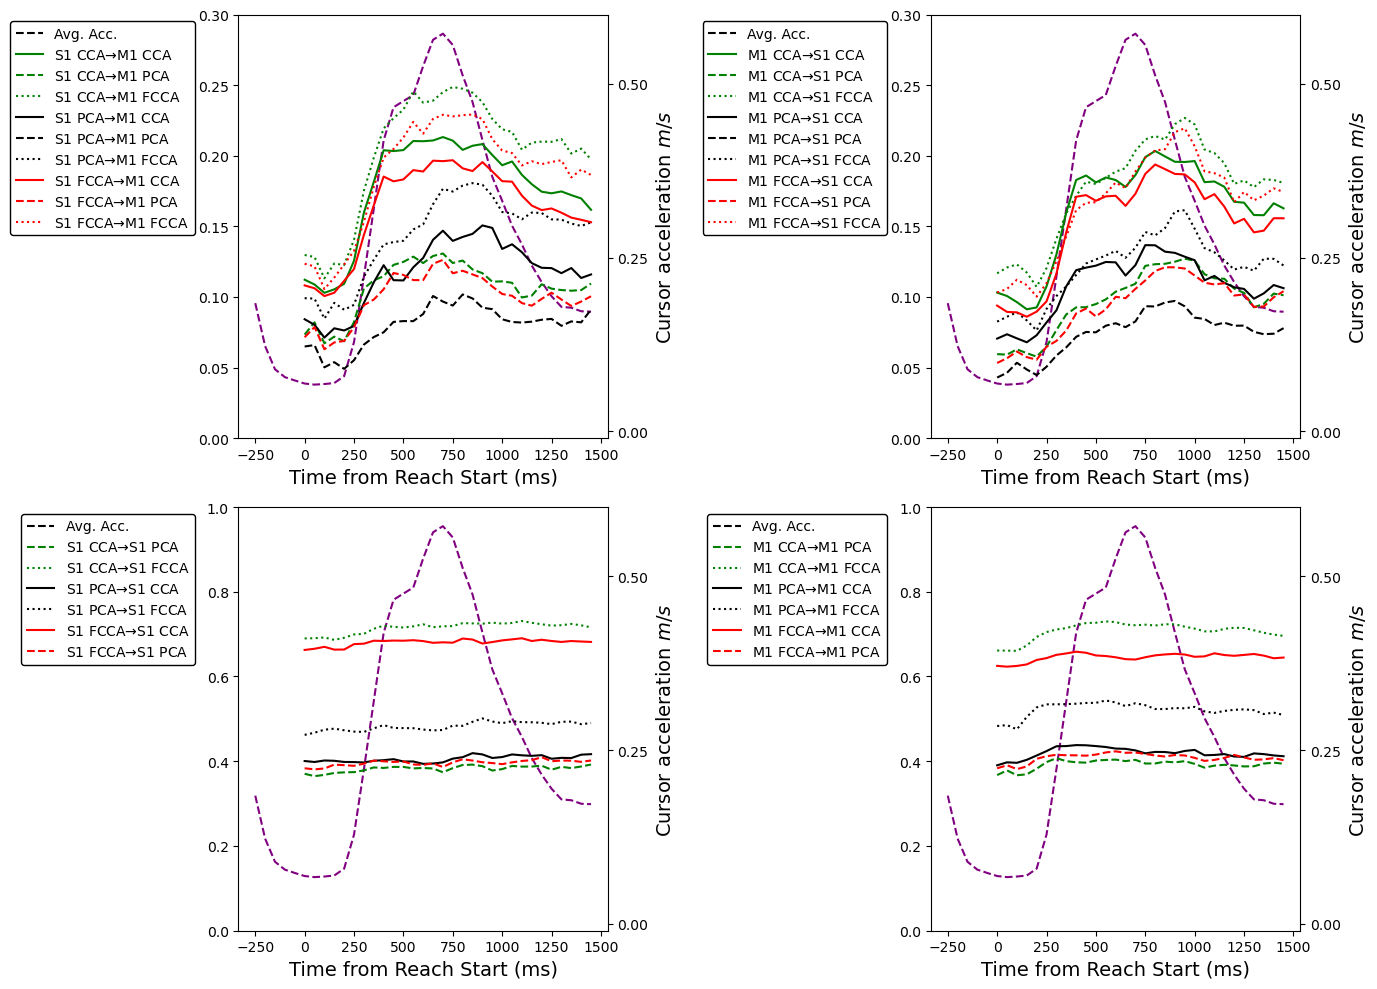

In [8]:
#fig, ax = plt.subplots(1, 3, figsize=(12, 4))
fig, ax = plt.subplots(2, 2, figsize=(14, 10))

#windows = dvt_df.iloc[0]['window']
#window_centers = np.linspace(0, 35, 15)[0:9]

DIM = 4
ntr = np.array(ntr)
# Dense windows
window_centers = np.arange(30)
#df_ = apply_df_filters(dvt_df, error_thresh=1, error_op='le', filter_type=0, q=0, op='le', dim=DIM)
df_ = dvt_df

a = []
for i in range(2):
    for j in range(2):  
        a.append(ax[i, j].twinx())

# Filter transition times by those that survived all windows ()
d = apply_df_filters(df_, didx=7)
# error_filter = d.iloc[0]['error_filter']
# reach_filter = d.iloc[0]['reach_filter']
# window_filter = d.iloc[0]['window_filter']

for a_ in a:
    a_.set_ylabel('Cursor acceleration ' r'$m/s$', fontsize=14)

# Flatten
velall = np.array([elem for v in vel_all for elem in v])
ntr = np.array([len(v) for v in vel_all])
aall = [elem for ac in acc_all for elem in ac]
velall = np.array(velall)
accall = np.array(aall)
# Use fill between to plot the confidence bands
#a.fill_between(50 * np.arange(-5, 23), np.mean(acc_all, axis=0) - np.std(acc_all, axis=0), np.mean(acc_all, axis=0) + np.std(acc_all, axis=0), color='k', alpha=0.1)

for a_ in a:
    a_.plot(50 * np.arange(-5, 30), np.mean(accall, axis=0), linestyle='--', color='purple')

# Dummy for legend
for i in range(2):
    for j in range(2):
        ax[i, j].plot(np.nan, linestyle='--', color='k', label='Avg. Acc.') 
#ax.plot(np.nan, linestyle='--', color='k', label='Avg. Vel.') 

# Segment in the same way as in the .py file to allow for comparison

rdict = {'rS1M1': {}, 'rM1S1': {}, 'rS1': {}, 'rM1': {}}
features = {'rS1M1': ['xcca', 'xpca', 'xfcca'], 'rM1S1': ['ycca', 'ypca', 'yfcca'], 'rS1': ['xcca', 'xpca', 'xfcca'], 'rM1': ['ycca', 'ypca', 'yfcca']}
targets = {'rS1M1': ['ycca', 'ypca', 'yfcca'], 'rM1S1': ['xcca', 'xpca', 'xfcca'], 'rS1': ['xcca', 'xpca', 'xfcca'], 'rM1': ['ycca', 'ypca', 'yfcca']}

legend_map = {'xcca':'S1 CCA', 'xpca': 'S1 PCA', 'xfcca': 'S1 FCCA', 'ycca': 'M1 CCA', 'ypca': 'M1 PCA', 'yfcca': 'M1 FCCA'}


# S1 -> M1
for k, v in features.items():
    for f in v:
        for t in targets[k]:
            rdict[k]['r2_%s_%s' % (f, t)] = []

for data_idx in np.unique(df_['didx'].values):
    d = apply_df_filters(df_, didx=data_idx)

    for ke in rdict.keys():
        r = {}
        for f in features[ke]:
            for t in targets[ke]:
                r['r2_%s_%s' % (f, t)] = []

        wc = []
        for k in range(d.shape[0]):
            win = d.iloc[k]['window']
            if win.ndim == 1:
                wc.extend([np.mean(win)])
            else:
                wc.extend(np.mean(win, axis=1))

            idx = 0
            for i, f in enumerate(features[ke]):
                for j, t in enumerate(targets[ke]):
                    if f == t:
                        continue
                    r['r2_%s_%s' % (f, t)].extend(np.nanmean(d.iloc[k]['_'.join(['r2', ke.split('r')[1]])][:, :, idx+1, 0], axis=1))
                    idx += 2
                    
        win_order = np.argsort(wc)
        for k, v in r.items():
            f = k.split('_')[1]
            t = k.split('_')[2]
            if f == t:
                continue
            r[k] = np.array(v)[win_order]

        for f in features[ke]:
            for t in targets[ke]:
                rdict[ke]['r2_%s_%s' % (f, t)].append(r['r2_%s_%s' % (f, t)])

for k, v in features.items():
    for f in v:
        for t in targets[k]:
            rdict[k]['r2_%s_%s' % (f, t)] = np.array(rdict[k]['r2_%s_%s' % (f, t)]).T      


def plot_trace(r2, col, linestyle, label, axis):
    # axis.fill_between(50 * window_centers, np.array([np.sum(np.multiply(r, ntr))/np.sum(ntr) for r in r2]) - np.array([np.sqrt(np.var(r) * np.sum(ntr**2)/np.sum(ntr)**2) for r in r2]), 
    #                 np.array([np.sum(np.multiply(r, ntr))/np.sum(ntr) for r in r2]) + np.array([np.sqrt(np.var(r) * np.sum(ntr**2)/np.sum(ntr)**2) for r in r2]),
    #                 color=col, alpha=0.25, zorder=100)

    axis.plot(50 * window_centers, [np.sum(np.multiply(r, ntr))/np.sum(ntr) for r in r2], '-', color=col, label=label, linestyle=linestyle)

colors = ['g', 'g', 'g', 'k', 'k', 'k', 'r', 'r', 'r']
ls = ['-', '--', ':', '-', '--', ':', '-', '--', ':']

for i, (key, value) in enumerate(rdict['rS1M1'].items()):
    label = legend_map[key.split('_')[1]] + r'$\to$' + legend_map[key.split('_')[2]]
    plot_trace(value, colors[i], ls[i], label, ax[0, 0])

for i, (key, value) in enumerate(rdict['rM1S1'].items()):
    label = legend_map[key.split('_')[1]] + r'$\to$' + legend_map[key.split('_')[2]]
    plot_trace(value, colors[i], ls[i], label, ax[0, 1])

colors = ['g', 'g', 'k', 'k', 'r', 'r']
ls = ['--', ':', '-', ':', '-', '--']

idx = 0
for i, (key, value) in enumerate(rdict['rS1'].items()):
    s1 = key.split('_')[1]
    s2 = key.split('_')[2]
    if s1 == s2:
        continue

    label = legend_map[key.split('_')[1]] + r'$\to$' + legend_map[key.split('_')[2]]
    plot_trace(value, colors[idx], ls[idx], label, ax[1, 0])
    idx += 1

colors = ['g', 'g', 'k', 'k', 'r', 'r']
ls = ['--', ':', '-', ':', '-', '--']
idx = 0
for i, (key, value) in enumerate(rdict['rM1'].items()):
    s1 = key.split('_')[1]
    s2 = key.split('_')[2]
    if s1 == s2:
        continue
    
    label = legend_map[key.split('_')[1]] + r'$\to$' + legend_map[key.split('_')[2]]
    plot_trace(value, colors[idx], ls[idx], label, ax[1, 1])
    idx += 1
# plot_trace(r2_M1CtoPCA, 'k', 'M1CC' + r'$\to$' + ' PCA')
# plot_trace(r2_M1CtoFCA, 'r', 'M1CC' + r'$\to$' + ' FCCA')
# plot_trace(r2_S1toM1C, 'g', 'S1CC' + r'$\to$' + ' M1CC')
#plot_trace(r2f - r2p, 'g', r'$\Delta$' + ' FCCA/PCA decoding')

for a_ in a:
    a_.set_ylim([-0.01, 0.6])  
    a_.set_yticks([0., 0.25, 0.5])
    a_.set_frame_on(True) # make sure there is any background

#ax.set_xlim([0, 950])
#ax.set_ylabel('Prediction ' + r'$r^2$', fontsize=14)
#ax.set_xlabel('Time from Reach Start (ms)', fontsize=14)
#ax.set_title('Projection Dimension %d' % DIM, fontsize=14)
for i in range(2):
    for j in range(2):
        lg = ax[i, j].legend(fontsize=10, ncol=1, frameon=True,  edgecolor=(0, 0, 0, 1.), bbox_to_anchor=(-0.1, 1.0))
        lg.get_frame().set_alpha(1.)

        ax[i, j].set_zorder(1) # make it on top
        ax[i, j].set_frame_on(False) # make it transparent
        ax[i, j].set_xlabel('Time from Reach Start (ms)', fontsize=14)

        if i == 0:
            ax[i, j].set_ylim([0, 0.3])
        else:
            ax[i, j].set_ylim([0, 1.0])

# ax.vlines(50 * np.arange(-5, 25)[np.argmax(np.mean(accall, axis=0))], 0, 0.725, linestyles='dotted', color='#535454', alpha=0.75)

# Find the local peak time of the green trace
# trace = np.array([np.sum(np.multiply(r, ntr))/np.sum(ntr) for r in r2_S1toM1C])
# pk = scipy.signal.find_peaks(trace)

# ax.vlines(50 * np.arange(20)[pk[0][1]], 0, 0.725, linestyles='dashed', color='g', alpha=0.75)

# lg1 = ax[1].legend(loc='lower right', fontsize=10, bbox_to_anchor=(0.14, -0.015, 0.25, 0.25), frameon=True, edgecolor=(0, 0, 0, 1.), facecolor=(1, 1, 1, 1.))
# lg2 = ax[2].legend(loc='lower left', fontsize=10, frameon=True, edgecolor=(0, 0, 0, 1.), facecolor=(1, 1, 1, 1.))


fig.tight_layout()
fig.savefig('/home/akumar/nse/neural_control/figs/cca/decoding_vs_t_allpairwise_d%d.pdf' % DIM, bbox_inches='tight', pad_inches=0)

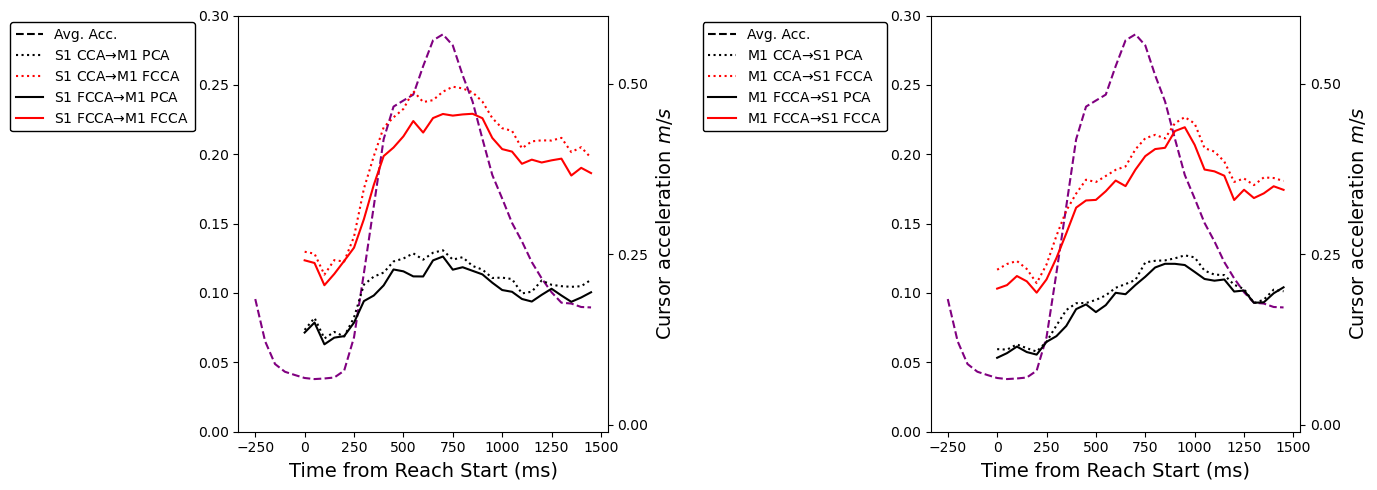

In [27]:
# Abridges version - cross area only and no CCA/PCA traces

#fig, ax = plt.subplots(1, 3, figsize=(12, 4))
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

#windows = dvt_df.iloc[0]['window']
#window_centers = np.linspace(0, 35, 15)[0:9]

DIM = 4
ntr = np.array(ntr)
# Dense windows
window_centers = np.arange(30)
#df_ = apply_df_filters(dvt_df, error_thresh=1, error_op='le', filter_type=0, q=0, op='le', dim=DIM)
df_ = dvt_df

a = []
for j in range(2):  
    a.append(ax[j].twinx())

# Filter transition times by those that survived all windows ()
d = apply_df_filters(df_, didx=7)
# error_filter = d.iloc[0]['error_filter']
# reach_filter = d.iloc[0]['reach_filter']
# window_filter = d.iloc[0]['window_filter']

for a_ in a:
    a_.set_ylabel('Cursor acceleration ' r'$m/s$', fontsize=14)

# Flatten
velall = np.array([elem for v in vel_all for elem in v])
ntr = np.array([len(v) for v in vel_all])
aall = [elem for ac in acc_all for elem in ac]
velall = np.array(velall)
accall = np.array(aall)
# Use fill between to plot the confidence bands
#a.fill_between(50 * np.arange(-5, 23), np.mean(acc_all, axis=0) - np.std(acc_all, axis=0), np.mean(acc_all, axis=0) + np.std(acc_all, axis=0), color='k', alpha=0.1)

for a_ in a:
    a_.plot(50 * np.arange(-5, 30), np.mean(accall, axis=0), linestyle='--', color='purple')

# Dummy for legend
for j in range(2):
    ax[j].plot(np.nan, linestyle='--', color='k', label='Avg. Acc.') 
#ax.plot(np.nan, linestyle='--', color='k', label='Avg. Vel.') 

# Segment in the same way as in the .py file to allow for comparison

rdict = {'rS1M1': {}, 'rM1S1': {}, 'rS1': {}, 'rM1': {}}
features = {'rS1M1': ['xcca', 'xpca', 'xfcca'], 'rM1S1': ['ycca', 'ypca', 'yfcca'], 'rS1': ['xcca', 'xpca', 'xfcca'], 'rM1': ['ycca', 'ypca', 'yfcca']}
targets = {'rS1M1': ['ycca', 'ypca', 'yfcca'], 'rM1S1': ['xcca', 'xpca', 'xfcca'], 'rS1': ['xcca', 'xpca', 'xfcca'], 'rM1': ['ycca', 'ypca', 'yfcca']}

legend_map = {'xcca':'S1 CCA', 'xpca': 'S1 PCA', 'xfcca': 'S1 FCCA', 'ycca': 'M1 CCA', 'ypca': 'M1 PCA', 'yfcca': 'M1 FCCA'}


# S1 -> M1
for k, v in features.items():
    for f in v:
        for t in targets[k]:
            rdict[k]['r2_%s_%s' % (f, t)] = []

for data_idx in np.unique(df_['didx'].values):
    d = apply_df_filters(df_, didx=data_idx)

    for ke in rdict.keys():
        r = {}
        for f in features[ke]:
            for t in targets[ke]:
                r['r2_%s_%s' % (f, t)] = []

        wc = []
        for k in range(d.shape[0]):
            win = d.iloc[k]['window']
            if win.ndim == 1:
                wc.extend([np.mean(win)])
            else:
                wc.extend(np.mean(win, axis=1))

            idx = 0
            for i, f in enumerate(features[ke]):
                for j, t in enumerate(targets[ke]):
                    if f == t:
                        continue
                    r['r2_%s_%s' % (f, t)].extend(np.nanmean(d.iloc[k]['_'.join(['r2', ke.split('r')[1]])][:, :, idx+1, 0], axis=1))
                    idx += 2
                    
        win_order = np.argsort(wc)
        for k, v in r.items():
            f = k.split('_')[1]
            t = k.split('_')[2]
            if f == t:
                continue
            r[k] = np.array(v)[win_order]

        for f in features[ke]:
            for t in targets[ke]:
                rdict[ke]['r2_%s_%s' % (f, t)].append(r['r2_%s_%s' % (f, t)])

for k, v in features.items():
    for f in v:
        for t in targets[k]:
            rdict[k]['r2_%s_%s' % (f, t)] = np.array(rdict[k]['r2_%s_%s' % (f, t)]).T      


def plot_trace(r2, col, linestyle, label, axis):
    # axis.fill_between(50 * window_centers, np.array([np.sum(np.multiply(r, ntr))/np.sum(ntr) for r in r2]) - np.array([np.sqrt(np.var(r) * np.sum(ntr**2)/np.sum(ntr)**2) for r in r2]), 
    #                 np.array([np.sum(np.multiply(r, ntr))/np.sum(ntr) for r in r2]) + np.array([np.sqrt(np.var(r) * np.sum(ntr**2)/np.sum(ntr)**2) for r in r2]),
    #                 color=col, alpha=0.25, zorder=100)

    axis.plot(50 * window_centers, [np.sum(np.multiply(r, ntr))/np.sum(ntr) for r in r2], '-', color=col, label=label, linestyle=linestyle)

colors = ['k', 'r', 'k', 'r']
ls = [':', ':', '-', '-']

idx = 0
for i, (key, value) in enumerate(rdict['rS1M1'].items()):
    if 'ycca' in key or 'xpca' in key:
        continue

    label = legend_map[key.split('_')[1]] + r'$\to$' + legend_map[key.split('_')[2]]
    plot_trace(value, colors[idx], ls[idx], label, ax[0])
    idx += 1

idx = 0
for i, (key, value) in enumerate(rdict['rM1S1'].items()):
    if 'xcca' in key or 'ypca' in key:
        continue

    label = legend_map[key.split('_')[1]] + r'$\to$' + legend_map[key.split('_')[2]]
    plot_trace(value, colors[idx], ls[idx], label, ax[1])
    idx += 1


for a_ in a:
    a_.set_ylim([-0.01, 0.6])  
    a_.set_yticks([0., 0.25, 0.5])
    a_.set_frame_on(True) # make sure there is any background

#ax.set_xlim([0, 950])
#ax.set_ylabel('Prediction ' + r'$r^2$', fontsize=14)
#ax.set_xlabel('Time from Reach Start (ms)', fontsize=14)
#ax.set_title('Projection Dimension %d' % DIM, fontsize=14)
for j in range(2):
    lg = ax[j].legend(fontsize=10, ncol=1, frameon=True,  edgecolor=(0, 0, 0, 1.), bbox_to_anchor=(-0.1, 1.0))
    lg.get_frame().set_alpha(1.)

    ax[j].set_zorder(1) # make it on top
    ax[j].set_frame_on(False) # make it transparent
    ax[j].set_xlabel('Time from Reach Start (ms)', fontsize=14)

    ax[j].set_ylim([0, 0.3])

# ax.vlines(50 * np.arange(-5, 25)[np.argmax(np.mean(accall, axis=0))], 0, 0.725, linestyles='dotted', color='#535454', alpha=0.75)

# Find the local peak time of the green trace
# trace = np.array([np.sum(np.multiply(r, ntr))/np.sum(ntr) for r in r2_S1toM1C])
# pk = scipy.signal.find_peaks(trace)

# ax.vlines(50 * np.arange(20)[pk[0][1]], 0, 0.725, linestyles='dashed', color='g', alpha=0.75)

# lg1 = ax[1].legend(loc='lower right', fontsize=10, bbox_to_anchor=(0.14, -0.015, 0.25, 0.25), frameon=True, edgecolor=(0, 0, 0, 1.), facecolor=(1, 1, 1, 1.))
# lg2 = ax[2].legend(loc='lower left', fontsize=10, frameon=True, edgecolor=(0, 0, 0, 1.), facecolor=(1, 1, 1, 1.))


fig.tight_layout()
fig.savefig('/home/akumar/nse/neural_control/figs/cca/decoding_vs_t_allpairwise_abridged.pdf', bbox_inches='tight', pad_inches=0)

(0.0, 0.3)

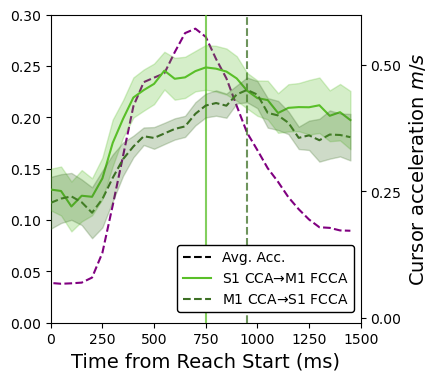

In [10]:
# Final version for use in panel 7(d)
# Abridges version - cross area only and no CCA/PCA traces

#fig, ax = plt.subplots(1, 3, figsize=(12, 4))
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

#windows = dvt_df.iloc[0]['window']
#window_centers = np.linspace(0, 35, 15)[0:9]

DIM = 4
ntr = np.array(ntr)
# Dense windows
window_centers = np.arange(30)
#df_ = apply_df_filters(dvt_df, error_thresh=1, error_op='le', filter_type=0, q=0, op='le', dim=DIM)
df_ = dvt_df

a = ax.twinx()

# Filter transition times by those that survived all windows ()
d = apply_df_filters(df_, didx=7)
# error_filter = d.iloc[0]['error_filter']
# reach_filter = d.iloc[0]['reach_filter']
# window_filter = d.iloc[0]['window_filter']

a.set_ylabel('Cursor acceleration ' r'$m/s$', fontsize=14)

# Flatten
velall = np.array([elem for v in vel_all for elem in v])
ntr = np.array([len(v) for v in vel_all])
aall = [elem for ac in acc_all for elem in ac]
velall = np.array(velall)
accall = np.array(aall)
# Use fill between to plot the confidence bands
#a.fill_between(50 * np.arange(-5, 23), np.mean(acc_all, axis=0) - np.std(acc_all, axis=0), np.mean(acc_all, axis=0) + np.std(acc_all, axis=0), color='k', alpha=0.1)

a.plot(50 * np.arange(-5, 30), np.mean(accall, axis=0), linestyle='--', color='purple')

# Dummy for legend
ax.plot(np.nan, linestyle='--', color='k', label='Avg. Acc.') 

# Segment in the same way as in the .py file to allow for comparison

rdict = {'rS1M1': {}, 'rM1S1': {}, 'rS1': {}, 'rM1': {}}
features = {'rS1M1': ['xcca', 'xpca', 'xfcca'], 'rM1S1': ['ycca', 'ypca', 'yfcca'], 'rS1': ['xcca', 'xpca', 'xfcca'], 'rM1': ['ycca', 'ypca', 'yfcca']}
targets = {'rS1M1': ['ycca', 'ypca', 'yfcca'], 'rM1S1': ['xcca', 'xpca', 'xfcca'], 'rS1': ['xcca', 'xpca', 'xfcca'], 'rM1': ['ycca', 'ypca', 'yfcca']}

legend_map = {'xcca':'S1 CCA', 'xpca': 'S1 PCA', 'xfcca': 'S1 FCCA', 'ycca': 'M1 CCA', 'ypca': 'M1 PCA', 'yfcca': 'M1 FCCA'}


# S1 -> M1
for k, v in features.items():
    for f in v:
        for t in targets[k]:
            rdict[k]['r2_%s_%s' % (f, t)] = []

for data_idx in np.unique(df_['didx'].values):
    d = apply_df_filters(df_, didx=data_idx)

    for ke in rdict.keys():
        r = {}
        for f in features[ke]:
            for t in targets[ke]:
                r['r2_%s_%s' % (f, t)] = []

        wc = []
        for k in range(d.shape[0]):
            win = d.iloc[k]['window']
            if win.ndim == 1:
                wc.extend([np.mean(win)])
            else:
                wc.extend(np.mean(win, axis=1))

            idx = 0
            for i, f in enumerate(features[ke]):
                for j, t in enumerate(targets[ke]):
                    if f == t:
                        continue
                    r['r2_%s_%s' % (f, t)].extend(np.nanmean(d.iloc[k]['_'.join(['r2', ke.split('r')[1]])][:, :, idx+1, 0], axis=1))
                    idx += 2
                    
        win_order = np.argsort(wc)
        for k, v in r.items():
            f = k.split('_')[1]
            t = k.split('_')[2]
            if f == t:
                continue
            r[k] = np.array(v)[win_order]

        for f in features[ke]:
            for t in targets[ke]:
                rdict[ke]['r2_%s_%s' % (f, t)].append(r['r2_%s_%s' % (f, t)])

for k, v in features.items():
    for f in v:
        for t in targets[k]:
            rdict[k]['r2_%s_%s' % (f, t)] = np.array(rdict[k]['r2_%s_%s' % (f, t)]).T      


def plot_trace(r2, col, linestyle, label, axis):
    axis.fill_between(50 * window_centers, np.array([np.sum(np.multiply(r, ntr))/np.sum(ntr) for r in r2]) - np.array([np.sqrt(np.var(r) * np.sum(ntr**2)/np.sum(ntr)**2) for r in r2]), 
                    np.array([np.sum(np.multiply(r, ntr))/np.sum(ntr) for r in r2]) + np.array([np.sqrt(np.var(r) * np.sum(ntr**2)/np.sum(ntr)**2) for r in r2]),
                    color=col, alpha=0.25, zorder=100)

    axis.plot(50 * window_centers, [np.sum(np.multiply(r, ntr))/np.sum(ntr) for r in r2], 
              color=col, label=label, linestyle=linestyle)

colors = ['#59bf28', '#3d7025', 'k', 'k']
ls = ['-', '--', '-', '--']
#markers = ['o', '^', 'o', '^']

idx = 0
keys = ['r2_xcca_yfcca', 'r2_ycca_xfcca']# 'r2_xcca_ypca', 'r2_ycca_xpca']

r2s = []
for i, key in enumerate(keys):
    if key.split('r2_')[1][0] == 'x':
        value = rdict['rS1M1'][key]
    else:
        value = rdict['rM1S1'][key]

    label = legend_map[key.split('_')[1]] + r'$\to$' + legend_map[key.split('_')[2]]
    plot_trace(value, colors[idx], ls[idx], label, ax)

    # Indicate time to hit 80 percent of maximum
    dr2_threshold = 1. * np.max([np.sum(np.multiply(r, ntr))/np.sum(ntr) for r in value])
    dr2_idxs = np.argwhere(np.array([np.sum(np.multiply(r, ntr))/np.sum(ntr) for r in value]) >= dr2_threshold)[[0, -1], 0]
    ax.vlines(50 * window_centers[dr2_idxs[0]], 0, 1, linestyles=ls[idx], color=colors[idx], alpha=0.75)
    # ax.vlines(50 * window_centers[dr2_idxs[1]], 0, 1, linestyles=[(4, (3, 6))], color='blue', alpha=0.75)
    r2s.append(value)
    idx += 1

a.set_ylim([-0.01, 0.6])  
a.set_yticks([0., 0.25, 0.5])
a.set_frame_on(True) # make sure there is any background

lg = ax.legend(fontsize=10, ncol=1, frameon=True,  edgecolor=(0, 0, 0, 1.), bbox_to_anchor=(1.0, 0.275))
lg.get_frame().set_alpha(1.)

ax.set_zorder(1) # make it on top
ax.set_frame_on(False) # make it transparent
ax.set_xlabel('Time from Reach Start (ms)', fontsize=14)
a.set_xlim([0, 1500])
ax.set_ylim([0, 0.3])

#fig.tight_layout()
#fig.savefig('/home/akumar/nse/neural_control/figs/cca/decoding_vs_t_s1m1final.pdf', bbox_inches='tight', pad_inches=0)

In [9]:
# Cross correlation with acceleration
avg_acc = []

for i in range(8):

    a = [a_ for a_ in acc_all[i] if a_.size == 35]
    a = np.array(a)[:, 5:]
    avg_acc.append(np.mean(a, axis=0))

avg_acc = np.array(avg_acc).T

In [13]:
np.divide(r2s[0], np.max(r2s[0], axis=0)).shape

(30, 8)

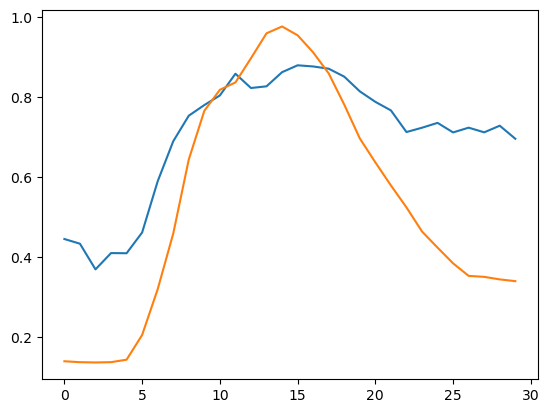

In [17]:
plt.plot(np.mean(r1, axis=1))
plt.plot(np.mean(avg_acc_01, axis=1))

In [19]:
np.max(np.mean(acf_coef[:, :, 1], axis=1))

0.9229780695164811

Text(0, 0.5, 'Correlation Coefficient')

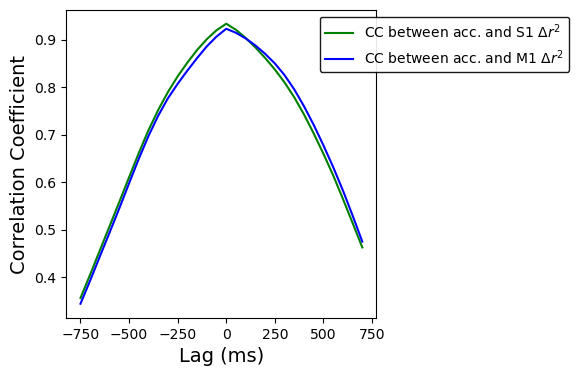

In [14]:
# Normalize delta r and avg_acc to a 0-1 scale
avg_acc_01 = np.divide(avg_acc, np.max(avg_acc, axis=0)[np.newaxis, :])
r1 = np.divide(r2s[0], np.max(r2s[0], axis=0))
r2 = np.divide(r2s[1], np.max(r2s[1], axis=0))

T = 30

acf_coef = np.zeros((T, 8, 2))
for k in range(8):        
    acf_coef[:, k, 0] = np.correlate(r1[0:T, k], avg_acc_01[0:T, k], mode='same')/np.sqrt(np.max(np.correlate(r1[0:T, k], r1[0:T, k], mode='same')) * np.max(np.correlate(avg_acc_01[0:T, k], avg_acc_01[0:T, k], mode='same')))
    acf_coef[:, k, 1] = np.correlate(r2[0:T, k], avg_acc_01[0:T, k], mode='same')/np.sqrt(np.max(np.correlate(r2[0:T, k], r2[0:T, k], mode='same')) * np.max(np.correlate(avg_acc_01[0:T, k], avg_acc_01[0:T, k], mode='same')))

np.max(np.mean(acf_coef[:, :, 0], axis=1))

fig, ax = plt.subplots(figsize=(4, 4))
ax.plot(50 * np.arange(-15, 15), np.mean(acf_coef[:, :, 0], axis=1), 'g', label='CC between acc. and S1 ' + r'$\Delta r^2$')
ax.plot(50 * np.arange(-15, 15), np.mean(acf_coef[:, :, 1], axis=1), 'b', label='CC between acc. and M1 ' + r'$\Delta r^2$')

lg = fig.legend(bbox_to_anchor=(1.4, 0.88), fontsize=10, frameon=True, facecolor=(1, 1, 1, 1.), edgecolor=(0, 0, 0, 1.))
lg.get_frame().set_alpha(0.9)
ax.set_xlabel('Lag (ms)', fontsize=14)
ax.set_ylabel('Correlation Coefficient', fontsize=14)

In [ ]:
#59bf28', zorder=0, label='S1C')
ax.plot(50 * window_centers, [np.sum(np.multiply(r, ntr))/np.sum(ntr) for r in r2p], '--', color='#3d7025

In [11]:
rdict['rS1M1'].keys()

dict_keys(['r2_xcca_ycca', 'r2_xcca_ypca', 'r2_xcca_yfcca', 'r2_xpca_ycca', 'r2_xpca_ypca', 'r2_xpca_yfcca', 'r2_xfcca_ycca', 'r2_xfcca_ypca', 'r2_xfcca_yfcca'])

{'whiskers': [<matplotlib.lines.Line2D at 0x7fb1ea89bd60>,
 'caps': [<matplotlib.lines.Line2D at 0x7fb1ea8a4310>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fb1ea89b9a0>],
 'medians': [<matplotlib.lines.Line2D at 0x7fb1ea8a4a90>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fb1ea8a4e50>],
 'means': []}

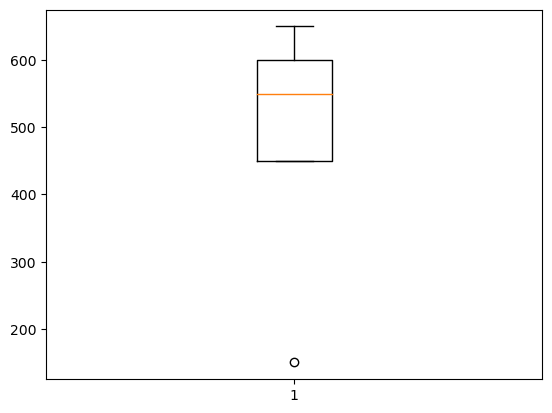

In [90]:
# Get time to 80% maximum and save. Co-plot in decodingvt notebook
r2_thresholds = [0.8 * np.max(r) for r in r2_S1toM1C.T]
r2_idxs = [np.argwhere(r > r2t)[0, 0] for r, r2t in zip(r2_S1toM1C.T, r2_thresholds)]
plt.boxplot(50 * np.array(r2_idxs))

In [91]:
with open('s1m1c80pct_timings.pkl', 'wb') as f:
    f.write(pickle.dumps(r2_idxs))

### Time-resolved with variable CCA dimension

In [9]:
data_file = '/mnt/Secondary/data/sabes/indy_20160426_01.mat'
dat = load_sabes(data_file)
dat = reach_segment_sabes(dat, data_file=data_file.split('/')[-1].split('.mat')[0])

fls = glob.glob('/home/akumar/nse/neural_control/data/s1m1vt2/*.dat')
rl = []

didxs = np.arange(8)
for i, didx in enumerate(didxs):

    dfls = [f for f in fls if 'didx%d' % didx in f]
    s = dfls[0].split('_')[3:]

    filter_params = {}
    filter_params['error_thresh'] = float(s[7])/100
    filter_params['error_op'] = s[-2]
    filter_params['filter_type'] = int(s[1])
    filter_params['op'] = s[3]
    filter_params['q'] = float(s[5])/100

    measure_from_end = bool(int(s[-1].split('.dat')[0]))

    result = {}
    result['didx'] = didx
    for k, v in filter_params.items():
        result[k] = v

    r2_M1 = []
    r2_S1 = []
    r2_CCA = []

    windows = []

    for j, fl_ in enumerate(dfls):
        with open(fl_, 'rb') as f:
            wr2_S1 = pickle.load(f) 
            wr2_M1 = pickle.load(f)
            wr2_CCA = pickle.load(f)
            error_filter = pickle.load(f)
            reach_filter = pickle.load(f)
            window_filter = pickle.load(f)
            windows_ = pickle.load(f)

        r2_M1.append(wr2_M1)
        r2_S1.append(wr2_S1)
        r2_CCA.append(wr2_CCA)
        windows.extend(windows_)

    window_centers = [np.mean(w) for w in windows]
    window_ordering = np.argsort(window_centers)
    r2_M1 = np.concatenate(r2_M1, axis=0)
    r2_S1 = np.concatenate(r2_S1, axis=0)
    r2_CCA = np.concatenate(r2_CCA, axis=0)
    
    r2_M1 = r2_M1[window_ordering]
    r2_S1 = r2_S1[window_ordering]
    r2_CCA = r2_CCA[window_ordering]

    result['error_filter'] = error_filter
    result['reach_filter'] = reach_filter
    result['window_filter'] = window_filter
    result['r2_M1'] = r2_M1
    result['r2_S1'] = r2_S1
    result['r2_CCA'] = r2_CCA
    result['window_centers'] = np.array(window_centers)[window_ordering]
    rl.append(result)

dvt_df = pd.DataFrame(rl)

Reminder that start times depend on the bin size


/home/akumar/nse/neural_control/segmentation.py:68: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


In [52]:
dvt_df.iloc[0]['r2_CCA'].shape

(20, 5, 2, 5, 5)

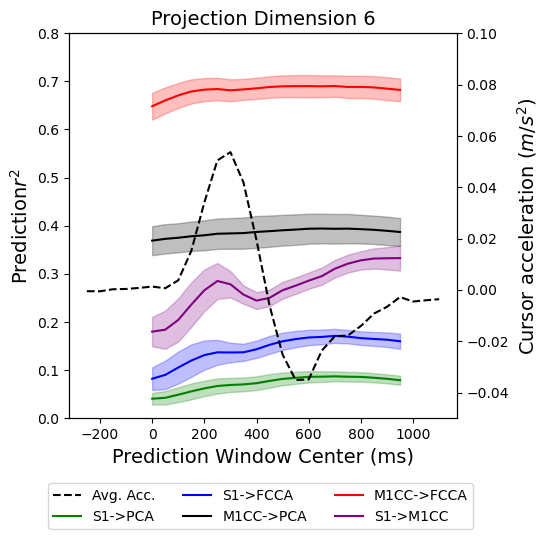

In [15]:
#fig, ax = plt.subplots(1, 3, figsize=(12, 4))
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

#windows = dvt_df.iloc[0]['window']
#window_centers = np.linspace(0, 35, 15)[0:9]

# Dense windows
window_centers = np.array(dvt_df.iloc[0]['window_centers'])
a = ax.twinx()

# Filter transition times by those that survived all windows ()
df_ = dvt_df
d = apply_df_filters(df_, didx=7)
error_filter = d.iloc[0]['error_filter']
reach_filter = d.iloc[0]['reach_filter']
window_filter = d.iloc[0]['window_filter']

# Intersection
transition_times = np.array(dat['transition_times'])[error_filter][reach_filter][window_filter]

vel_all = []
acc_all = []
for tt in transition_times[::2]:
    vel = np.linalg.norm(np.diff(dat['behavior'][tt[0] - 5:tt[0] + 25], axis=0), axis=1)/(1e3 * 0.05)
    acc = np.diff(vel)
    acc_all.append(acc)
    vel_all.append(vel)
    #a.plot(50 * np.arange(-5, 23), acc, color='#6e6e6e', alpha=0.1, zorder=-100)
    a.set_ylabel('Cursor acceleration ' r'$(m/s^2)$', fontsize=14)

vel_all = np.array(vel_all)
vel_all = np.mean(vel_all, axis=0)
acc_all = np.array(acc_all)
acc_all = np.mean(acc_all, axis=0)

a.plot(50 * np.arange(-5, 23), acc_all, linestyle='--', color='k')
# Dummy for legend
ax.plot(np.nan, linestyle='--', color='k', label='Avg. Acc.') 
a.set_ylim([-0.05, 0.1])

r2_S1toPCA = []
r2_S1toFCA = []
r2_M1CtoPCA = []
r2_M1CtoFCA = []
r2_S1toM1C = []

# See s1m1vt.py
#    ccadims = np.array([1, 2, 6, 10, -1])

for j in range(df_.shape[0]):
    r2_S1toPCA.append(np.nanmean(df_.iloc[j]['r2_S1'][:, :, 1, 2], axis=1))
    r2_S1toFCA.append(np.nanmean(df_.iloc[j]['r2_S1'][:, :, 3, 2], axis=1))
    r2_M1CtoPCA.append(np.nanmean(df_.iloc[j]['r2_M1'][:, :, 1, 2], axis=1))
    r2_M1CtoFCA.append(np.nanmean(df_.iloc[j]['r2_M1'][:, :, 3, 2], axis=1))
    r2_S1toM1C.append(np.nanmean(df_.iloc[j]['r2_CCA'][:, :, 1, 0, 2], axis=1))

r2_S1toPCA = np.array(r2_S1toPCA).T
r2_S1toFCA = np.array(r2_S1toFCA).T
r2_M1CtoPCA = np.array(r2_M1CtoPCA).T
r2_M1CtoFCA = np.array(r2_M1CtoFCA).T
r2_S1toM1C = np.array(r2_S1toM1C).T

def plot_trace(r2, col, label):
    ax.fill_between(50 * window_centers, np.array([np.mean(r) for r in r2]) - np.array([np.std(r)/np.sqrt(8) for r in r2]), 
                    np.array([np.mean(r) for r in r2]) + np.array([np.std(r)/np.sqrt(8) for r in r2]),
                    color=col, alpha=0.25, zorder=100)
    ax.plot(50 * window_centers, [np.mean(r) for r in r2], '-', color=col, label=label)

plot_trace(r2_S1toPCA, 'g', 'S1->PCA')
plot_trace(r2_S1toFCA, 'g', 'S1->FCCA')
plot_trace(r2_M1CtoPCA, 'k', 'M1CC->PCA')
plot_trace(r2_M1CtoFCA, 'r', 'M1CC->FCCA')
plot_trace(r2_S1toM1C, 'g', 'S1->M1CC')

ax.set_ylim([0, 0.8])
ax.set_ylabel('Prediction' + r'$r^2$', fontsize=14)
ax.set_xlabel('Prediction Window Center (ms)', fontsize=14)
ax.set_title('Projection Dimension 6', fontsize=14)
ax.legend(bbox_to_anchor=(1.06, -0.15), fontsize=10, ncol=3)

# fig.tight_layout()
fig.savefig('/home/akumar/nse/neural_control/figs/cca/decoding_vs_td6.pdf', bbox_inches='tight', pad_inches=0)

### Final (non-time resolved) figures

In [ ]:
# remaining questions
# (1) All pairwise regressions for several dimensionalities
# (2) Is the decoding accuracy of M1 CC --> M1 FCCA due to the overlap neurons?

In [5]:
with open('/mnt/Secondary/data/postprocessed/sabes_cca50cv_df.dat', 'rb') as f:
    ccadf = pickle.load(f)

/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator CCA from version 1.0.1 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [6]:
with open('/mnt/Secondary/data/postprocessed/indy_decoding_df2.dat', 'rb') as f:
    indy_df = pickle.load(f)
indy_df = pd.DataFrame(indy_df)

/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LinearRegression from version 0.24.2 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [7]:
with open('/mnt/Secondary/data/postprocessed/loco_decoding_df.dat', 'rb') as f:
    loco_df = pickle.load(f)
loco_df = pd.DataFrame(loco_df)
loco_df = apply_df_filters(loco_df,
                        loader_args={'bin_width': 50, 'filter_fn': 'none', 'filter_kwargs': {}, 'boxcox': 0.5, 'spike_threshold': 100, 'region': 'M1'},
                        decoder_args={'trainlag': 4, 'testlag': 4, 'decoding_window': 5})


/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LinearRegression from version 0.24.2 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [8]:
fls = np.unique(ccadf['fl'].values)

8it [00:00, 1707.17it/s]


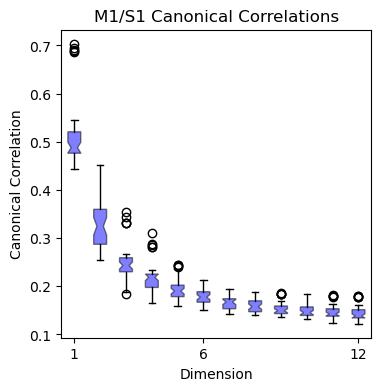

In [8]:
# Canonical correlation coefficients
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

cc_coefs = np.zeros((8, 5, 12))
for i, fl in tqdm(enumerate(fls)):
    dc_ = apply_df_filters(ccadf, fl=fl)
    for j in range(dc_.shape[0]):
        cc_coefs[i, j, :] = dc_.iloc[j]['cc_coefs']

medianprops = dict(linewidth=0)
bplot = ax.boxplot(np.reshape(cc_coefs, (-1, 12)), patch_artist=True, medianprops=medianprops, notch=True)

for patch in bplot['boxes']:
    patch.set_facecolor('g')
    patch.set_alpha(0.5)

ax.set_title('M1/S1 Canonical Correlations')
ax.set_ylabel('Canonical Correlation')
ax.set_xlabel('Dimension')
ax.set_xticks([1, 6, 12])
ax.set_xticklabels([1, 6, 12])

fig.savefig('/home/akumar/nse/neural_control/figs/cca/cc_coef.pdf', bbox_inches='tight', pad_inches=0)

In [171]:
data_file = fls[0].split('/')[-1].split('.pkl')[0]
data_file += '.mat'
d1 = apply_df_filters(indy_df, data_file=data_file, dimreduc_method='PCA', dim=1, fold_idx=0)
d2 = apply_df_filters(indy_df, data_file=data_file, dimreduc_method='LQGCA', dim=1, dimreduc_args={'T':3, 'loss_type':'trace', 'n_init':10}, fold_idx=1)

In [175]:
scipy.linalg.subspace_angles(d1.iloc[0]['coef'], d2.iloc[0]['coef'])

array([1.48603808e-15])

In [257]:
# CC to SS regression
lag = 0
w = 3
dims = np.array([1, 2, 6, 8, 12])
cc2ssM1 = np.zeros((fls.size, 6, dims.size, 5))
cc2ssM1coef = np.zeros((fls.size, 6, dims.size, 5), dtype=np.object)

for i, fl in tqdm(enumerate(fls)):
    with open(fl, 'rb') as f:
        datM1 = pickle.load(f)
        datS1 = pickle.load(f)

    y = datM1['spike_rates'].squeeze()
    x = datS1['spike_rates'].squeeze()


    # Get the subspaces
    data_file = fl.split('/')[-1].split('.pkl')[0]
    data_file += '.mat'

    for j, dim in enumerate(dims):
        if 'indy' in data_file:
            pcadf = apply_df_filters(indy_df, data_file=data_file, dimreduc_method='PCA', dim=dim)
        elif 'loco' in data_file:
            pcadf = apply_df_filters(loco_df, data_file=data_file, dimreduc_method='PCA', dim=dim)

        assert(pcadf.shape[0] == 5)

        if 'indy' in data_file:
            lqgdf = apply_df_filters(indy_df, data_file=data_file, dimreduc_method='LQGCA', dim=dim, dimreduc_args={'T':3, 'loss_type':'trace', 'n_init':10})
        elif 'loco' in data_file:
            lqgdf = apply_df_filters(loco_df, data_file=data_file, dimreduc_method='LQGCA', dim=dim, dimreduc_args={'T':3, 'loss_type':'trace', 'n_init':10})

        assert(lqgdf.shape[0] == 5)

        # For each fold, and dimensions 2-6, measure the min and average subspace angle
        for fold in range(5):
            d_ = apply_df_filters(pcadf, fold_idx=fold)
            dc_ = apply_df_filters(ccadf2, fold_idx=fold, fl=fl)
            model = dc_.iloc[0]['ccamodel']

            # Vpca = d_.iloc[0]['coef']

            d_ = apply_df_filters(lqgdf, fold_idx=fold)

            # Vlqg = d_.iloc[0]['coef']
            pcamodel = PCA().fit(y[d_.iloc[0]['train_idxs']])
            Vpca = pcamodel.components_.T[:, 0:dim]
            lqgmodel = LQGCA(d=dim, T=3, n_init=10, rng_or_seed=124).fit(y[d_.iloc[0]['train_idxs']])
            Vlqg = lqgmodel.coef_

            # M1 PCA
            ytrainp = y[d_.iloc[0]['train_idxs']] @ Vpca
            ytestp = y[d_.iloc[0]['test_idxs']] @ Vpca        

            # M1 LGQ
            ytrainf = y[d_.iloc[0]['train_idxs']] @ Vlqg
            ytestf = y[d_.iloc[0]['test_idxs']] @ Vlqg      

            # M1 CCA
            xtrain = y[d_.iloc[0]['train_idxs']] @ model.y_rotations_[:, 0:dim]
            xtest = y[d_.iloc[0]['test_idxs']] @ model.y_rotations_[:, 0:dim]

            # Window: regress x onto y
            if w > 1:
                xtrain = form_lag_matrix(xtrain, w)
                xtest = form_lag_matrix(xtest, w)
                
                ytrainp = ytrainp[w//2:]
                ytrainp = ytrainp[:xtrain.shape[0]]
                ytestp = ytestp[w//2:]
                ytestp = ytestp[:xtest.shape[0]]

                ytrainf = ytrainf[w//2:]
                ytrainf = ytrainf[:xtrain.shape[0]]
                ytestf = ytestf[w//2:]
                ytestf = ytestf[:xtest.shape[0]]

            ytrainp = StandardScaler().fit_transform(ytrainp)
            ytrainf = StandardScaler().fit_transform(ytrainf)
            xtrain = StandardScaler().fit_transform(xtrain)

            ytestp = StandardScaler().fit_transform(ytestp)
            ytestf = StandardScaler().fit_transform(ytestf)
            xtest = StandardScaler().fit_transform(xtest)

            linmodel = RidgeCV()
            linmodel.fit(xtrain, ytrainp)
            cc2ssM1[i, 0, j, fold] = linmodel.score(xtest, ytestp)
            cc2ssM1coef[i, 0, j, fold] = linmodel.coef_

            linmodel = RidgeCV()
            linmodel.fit(xtrain, ytrainf)
            cc2ssM1[i, 2, j, fold] = linmodel.score(xtest, ytestf)
            cc2ssM1coef[i, 2, j, fold] = linmodel.coef_

            # Regress PCA onto FCA
            ytrainp = y[d_.iloc[0]['train_idxs']] @ Vpca
            ytestp = y[d_.iloc[0]['test_idxs']] @ Vpca        

            ytrainp = form_lag_matrix(ytrainp, w)
            ytestp = form_lag_matrix(ytestp, w)

            linmodel = RidgeCV()
            linmodel.fit(ytrainp, ytrainf)
            cc2ssM1[i, 4, j, fold] = linmodel.score(ytestp, ytestf)
            cc2ssM1coef[i, 4, j, fold] = linmodel.coef_

            #####################################################################################################3

            # M1 PCA
            ytrainp = y[d_.iloc[0]['train_idxs']] @ Vpca
            ytestp = y[d_.iloc[0]['test_idxs']] @ Vpca        

            # M1 LGQ
            ytrainf = y[d_.iloc[0]['train_idxs']] @ Vlqg
            ytestf = y[d_.iloc[0]['test_idxs']] @ Vlqg      

            # M1 CCA
            xtrain = y[d_.iloc[0]['train_idxs']] @ model.y_rotations_[:, 0:dim]
            xtest = y[d_.iloc[0]['test_idxs']] @ model.y_rotations_[:, 0:dim]

            # Window: regress y onto x
            if w > 1:
                ytrainp = form_lag_matrix(ytrainp, w)
                ytestp = form_lag_matrix(ytestp, w)

                ytrainf = form_lag_matrix(ytrainf, w)
                ytestf = form_lag_matrix(ytestf, w)

                xtrain = xtrain[w//2:]
                xtrain = xtrain[:ytrainp.shape[0]] 
                xtest = xtest[w//2:]
                xtest = xtest[:ytestp.shape[0]]

            ytrainp = StandardScaler().fit_transform(ytrainp)
            ytrainf = StandardScaler().fit_transform(ytrainf)
            xtrain = StandardScaler().fit_transform(xtrain)

            ytestp = StandardScaler().fit_transform(ytestp)
            ytestf = StandardScaler().fit_transform(ytestf)
            xtest = StandardScaler().fit_transform(xtest)

            linmodel = RidgeCV()
            linmodel.fit(ytrainp, xtrain)
            cc2ssM1[i, 1, j, fold] = linmodel.score(ytestp, xtest)
            cc2ssM1coef[i, 1, j, fold] = linmodel.coef_

            linmodel = RidgeCV()
            linmodel.fit(ytrainf, xtrain)
            cc2ssM1[i, 3, j, fold] = linmodel.score(ytestf, xtest)
            cc2ssM1coef[i, 3, j, fold] = linmodel.coef_

            # Regress yfca onto ypca
            ytrainp = y[d_.iloc[0]['train_idxs']] @ Vpca
            ytestp = y[d_.iloc[0]['test_idxs']] @ Vpca        

            ytrainp = ytrainp[w//2:]
            ytrainp = ytrainp[:ytrainf.shape[0]]
            ytestp = ytestp[w//2:]
            ytestp = ytestp[:ytestf.shape[0]]

            linmodel = RidgeCV()
            linmodel.fit(ytrainf, ytrainp)
            cc2ssM1[i, 5, j, fold] = linmodel.score(ytestf, ytestp)
            cc2ssM1coef[i, 5, j, fold] = linmodel.coef_


/tmp/ipykernel_19801/4237504417.py:6: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cc2ssM1coef = np.zeros((fls.size, 6, dims.size, 5), dtype=np.object)
8it [08:08, 61.03s/it]


In [177]:
stat, p = scipy.stats.wilcoxon(cc2ssM1[:, 2, :].ravel(), cc2ssM1[:, 0, :].ravel())


In [178]:
p

2.0605994648315418e-34

In [132]:
cc2ssM1[:, 2, :].ravel()

array([0.03123558, 0.03179876, 0.03212568, 0.0318304 , 0.02593169,
       0.30361382, 0.31180748, 0.28031725, 0.3144898 , 0.33219598,
       0.46120687, 0.4673318 , 0.47471617, 0.478623  , 0.48659538,
       0.24303942, 0.23100931, 0.24209467, 0.25702219, 0.23500302,
       0.31536314, 0.3158824 , 0.32554457, 0.31596233, 0.30163785,
       0.33533767, 0.33620022, 0.34636763, 0.31902268, 0.3342707 ,
       0.32010642, 0.32776842, 0.32278854, 0.31913147, 0.33070033,
       0.24627578, 0.281584  , 0.26796883, 0.29026778, 0.26750524])

Text(0, 0.5, 'Prediction $r^2$ from M1 CCA subspace')

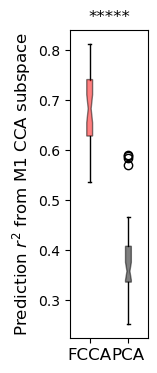

In [192]:
fig, ax = plt.subplots(figsize=(1, 4))
medianprops = dict(linewidth=0)
bplot = ax.boxplot([cc2ssM1[:, 2, 2, :].ravel(), cc2ssM1[:, 0, 2, :].ravel()], patch_artist=True, medianprops=medianprops, notch=True)

bplot['boxes'][0].set_facecolor('r')
bplot['boxes'][1].set_facecolor('k')

for patch in bplot['boxes']:
    patch.set_alpha(0.5)
ax.set_title('*****')
ax.set_xticklabels(['FCCA', 'PCA'], fontsize=12)
ax.set_ylabel('Prediction ' + r'$r^2$' + ' from M1 CCA subspace', fontsize=12)
#fig.savefig('/home/akumar/nse/neural_control/figs/cca/m1cc2ss.pdf', bbox_inches='tight', pad_inches=0)

In [190]:
cc2ssM1[:, 3, 0, :]

array([[0.7963379 , 0.81149793, 0.81040299, 0.82295727, 0.79751292],
       [0.75259776, 0.7146025 , 0.70662403, 0.71305366, 0.68262234],
       [0.78062209, 0.76063581, 0.81955195, 0.80220649, 0.79772743],
       [0.84832855, 0.82738571, 0.8376708 , 0.84039519, 0.85064653],
       [0.8589642 , 0.88740636, 0.87915455, 0.87511499, 0.87546796],
       [0.81435146, 0.82504562, 0.81326745, 0.83074544, 0.83409292],
       [0.79372248, 0.80932374, 0.78472448, 0.76404839, 0.81905114],
       [0.86647072, 0.88552086, 0.88849423, 0.88044861, 0.85627535]])

In [34]:
# Follow up question:Can we reproduce the zero subspace angle between d =1 FCCA and PCA

(40, 11)

In [163]:
with open(fls[0], 'rb') as f:
    datM1 = pickle.load(f)
    datS1 = pickle.load(f)

y = datM1['spike_rates'].squeeze()
x = datS1['spike_rates'].squeeze()


In [168]:
pcamodel = PCA().fit(y)
lqgmodel = LQGCA(T=3, d=1, n_init=10).fit(y)

In [169]:
scipy.linalg.subspace_angles(pcamodel.components_.T[:, 0:1], lqgmodel.coef_)

array([0.85716507])

In [13]:
from utils import calc_loadings

In [18]:
# Leverage scores and subspace angles
dim = 6

cca_loadings = []
pca_loadings = []
fcca_loadings = []
for i, fl in tqdm(enumerate(fls)):
    ccalf = []
    pcalf = []
    fcclf = []
    for fold in range(5):
        dfc_ = apply_df_filters(ccadf, fl=fl, fold_idx=fold)
        data_file = fl.split('/')[-1].split('.pkl')[0]
        data_file += '.mat'

        if 'indy' in data_file:
            pcadf = apply_df_filters(indy_df, data_file=data_file, dimreduc_method='PCA', dim=dim, fold_idx=fold)
        elif 'loco' in data_file:
            pcadf = apply_df_filters(loco_df, data_file=data_file, dimreduc_method='PCA', dim=dim, fold_idx=fold)

        if 'indy' in data_file:
            lqgdf = apply_df_filters(indy_df, data_file=data_file, dimreduc_method='LQGCA', dim=6, fold_idx=fold)
        elif 'loco' in data_file:
            lqgdf = apply_df_filters(loco_df, data_file=data_file, dimreduc_method='LQGCA', dim=6, fold_idx=fold)

        assert(dfc_.shape[0] == 1)
        assert(pcadf.shape[0] == 1)
        assert(lqgdf.shape[0] == 1)

        model = dfc_.iloc[0]['ccamodel']
        ccalf.append(calc_loadings(model.y_loadings_[:, 0:dim]))
        pcalf.append(calc_loadings(pcadf.iloc[0]['coef'][:, 0:dim]))
        fcclf.append(calc_loadings(lqgdf.iloc[0]['coef'][:, 0:dim]))

    ccalf = np.mean(np.array(ccalf), axis=0)
    pcalf = np.mean(np.array(pcalf), axis=0)
    fcclf = np.mean(np.array(fcclf), axis=0)

    cca_loadings.extend(ccalf)
    pca_loadings.extend(pcalf)
    fcca_loadings.extend(fcclf)

8it [00:00, 77.95it/s]


In [203]:
# Leverage scores and subspace angles
dims = np.array([1, 2, 6, 8, 12])
cca_pca_ssa = np.zeros((len(fls), dims.size))
cca_fcca_ssa = np.zeros((len(fls), dims.size))
pca_fcca_ssa = np.zeros((len(fls), dims.size))
for i, fl in tqdm(enumerate(fls)):
    for j, dim in enumerate(dims):

        cca_pca_ssaf = []
        cca_fcca_ssaf = []
        pca_fcca_ssaf = []
        for fold in range(5):
            dfc_ = apply_df_filters(ccadf2, fl=fl, fold_idx=fold)
            data_file = fl.split('/')[-1].split('.pkl')[0]
            data_file += '.mat'

            if 'indy' in data_file:
                pcadf = apply_df_filters(indy_df, data_file=data_file, dimreduc_method='PCA', dim=dim, fold_idx=fold)
            elif 'loco' in data_file:
                pcadf = apply_df_filters(loco_df, data_file=data_file, dimreduc_method='PCA', dim=dim, fold_idx=fold)

            if 'indy' in data_file:
                lqgdf = apply_df_filters(indy_df, data_file=data_file, dimreduc_method='LQGCA', dim=dim, fold_idx=fold)
            elif 'loco' in data_file:
                lqgdf = apply_df_filters(loco_df, data_file=data_file, dimreduc_method='LQGCA', dim=dim, fold_idx=fold)

            assert(dfc_.shape[0] == 1)
            assert(pcadf.shape[0] == 1)
            assert(lqgdf.shape[0] == 1)
            model = dfc_.iloc[0]['ccamodel']
            cca_pca_ssaf.append(scipy.linalg.subspace_angles(model.y_rotations_[:, 0:dim], pcadf.iloc[0]['coef'][:, 0:dim]))
            cca_fcca_ssaf.append(scipy.linalg.subspace_angles(model.y_rotations_[:, 0:dim], lqgdf.iloc[0]['coef'][:, 0:dim]))
            pca_fcca_ssaf.append(scipy.linalg.subspace_angles(pcadf.iloc[0]['coef'][:, 0:dim], lqgdf.iloc[0]['coef'][:, 0:dim]))
        cca_pca_ssa[i, j] = np.mean(np.array(cca_pca_ssaf))
        cca_fcca_ssa[i, j] = np.mean(np.array(cca_fcca_ssaf))
        pca_fcca_ssa[i, j] = np.mean(np.array(pca_fcca_ssaf))

8it [00:00, 10.43it/s]


Text(0, 0.5, 'Subspace Angle')

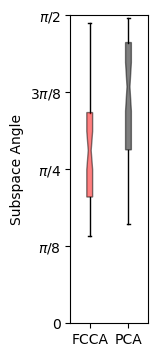

In [16]:
# Just the boxplots
fig, ax = plt.subplots(figsize=(1, 4))
bplot = ax.boxplot([cca_fcca_ssa, cca_pca_ssa], medianprops={'linewidth':0}, notch=True, patch_artist=True)

bplot['boxes'][0].set_facecolor('r')
bplot['boxes'][1].set_facecolor('k')

bplot['boxes'][0].set_alpha(0.5)
bplot['boxes'][1].set_alpha(0.5)

ax.set_xticklabels(['FCCA', 'PCA'])
ax.set_yticks([0, np.pi/8, np.pi/4, 3*np.pi/8, np.pi/2])
ax.set_yticklabels(['0', r'$\pi/8$', r'$\pi/4$', r'$3\pi/8$', r'$\pi/2$'])
ax.set_ylim([0, np.pi/2])
ax.set_ylabel('Subspace Angle')

#fig.savefig('/home/akumar/nse/neural_control/figs/cca/ss_angles_only.pdf', bbox_inches='tight', pad_inches=0)

(0.0, 1.5707963267948966)

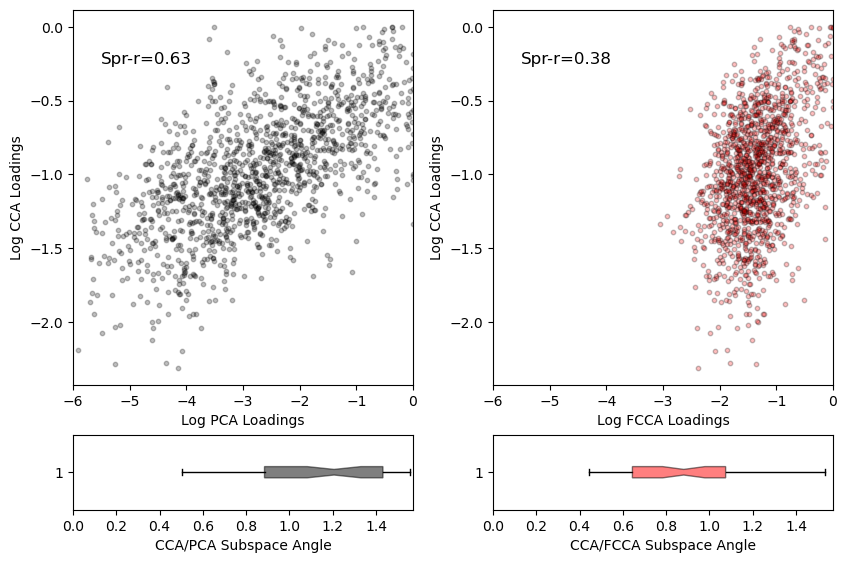

In [19]:
fig = plt.figure(figsize=(8, 5))

eps = 5e-2

rect1 = [0, 1./5. + eps, 0.425, 4./5 - eps]
rect2 = [0.525, 1./5. + eps, 0.425, 4./5. - eps]

rect3 = [0, 0, 0.425, 1./5. - eps]
rect4 = [0.525, 0, 0.425, 1./5. - eps]

ax00 = fig.add_axes(rect1)
ax01 = fig.add_axes(rect2)
ax10 = fig.add_axes(rect3)
ax11 = fig.add_axes(rect4)

ax00.scatter(np.log10(pca_loadings), np.log10(cca_loadings), color='k', alpha=0.25, s=10, edgecolors='k')
ax01.scatter(np.log10(fcca_loadings), np.log10(cca_loadings), color='r', alpha=0.25, s=10, edgecolors='k')
ax01.set_xlim([-6, 0])
ax00.set_xlim([-6, 0])
r1 = scipy.stats.spearmanr(np.log10(pca_loadings), np.log10(cca_loadings))[0]
r2 = scipy.stats.spearmanr(np.log10(fcca_loadings), np.log10(cca_loadings))[0]

ax00.annotate('Spr-r=%.2f' % r1, (-5.5, -0.25), fontsize=12)
ax01.annotate('Spr-r=%.2f' % r2, (-5.5, -0.25), fontsize=12)
ax00.set_ylabel('Log CCA Loadings')
ax00.set_xlabel('Log PCA Loadings')
ax01.set_ylabel('Log CCA Loadings')
ax01.set_xlabel('Log FCCA Loadings')

bplot1 = ax10.boxplot(cca_pca_ssa, vert=False, medianprops={'linewidth':0}, notch=True, patch_artist=True)
bplot2 = ax11.boxplot(cca_fcca_ssa, vert=False, medianprops={'linewidth':0}, notch=True, patch_artist=True)

bplot1['boxes'][0].set_facecolor('k')
bplot2['boxes'][0].set_facecolor('r')

bplot1['boxes'][0].set_alpha(0.5)
bplot2['boxes'][0].set_alpha(0.5)

ax10.set_xlim([0, np.pi/2])
ax11.set_xlim([0, np.pi/2])

ax10.set_xlabel('CCA/PCA Subspace Angle')
ax10.set_xlim([0, np.pi/2])

ax11.set_xlabel('CCA/FCCA Subspace Angle')
ax11.set_xlim([0, np.pi/2])

#fig.savefig('/home/akumar/nse/neural_control/figs/cca/loadings_ss_angles.pdf', bbox_inches='tight', pad_inches=0)

In [11]:
data_path = '/mnt/Secondary/data/sabes'
data_file = 'loco_20170210_03.mat'

In [12]:
# Raw neural data from both M1 and S1
datM1 = load_sabes('%s/%s' % (data_path, data_file), boxcox=None, high_pass=False, bin_width=10, filter_fn='gaussian', filter_kwargs={'sigma':1.5}, region='M1')
datS1 = load_sabes('%s/%s' % (data_path, data_file), boxcox=None, high_pass=False, bin_width=10, filter_fn='gaussian', filter_kwargs={'sigma':1.5}, region='S1')
#dat = load_sabes('%s/%s' % (data_path, data_files[3]), boxcox=None, high_pass=False, bin_width=5)

datM1_segment = reach_segment_sabes(datM1, data_file=data_file.split('.mat')[0])
datS1_segment = reach_segment_sabes(datS1, data_file=data_file.split('.mat')[0])

T = 100
t = np.array([t_[1] - t_[0] for t_ in datM1_segment['transition_times']])
valid_transitions = np.arange(t.size)[t >= T]

x_ = np.array([datM1['spike_rates'][0, datM1_segment['transition_times'][idx][0]:datM1_segment['transition_times'][idx][0] + T] 
            for idx in valid_transitions])
y_ = np.array([datS1['spike_rates'][0, datS1_segment['transition_times'][idx][0]:datS1_segment['transition_times'][idx][0] + T] 
            for idx in valid_transitions])

96
Reminder that start times depend on the bin size


/home/akumar/nse/neural_control/segmentation.py:68: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


Reminder that start times depend on the bin size


/tmp/ipykernel_25900/3316215056.py:38: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "pad_inhces" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig('/home/akumar/nse/neural_control/figs/loco_indy_merge/M1_traces.pdf', bbox_inches='tight', pad_inhces=0)


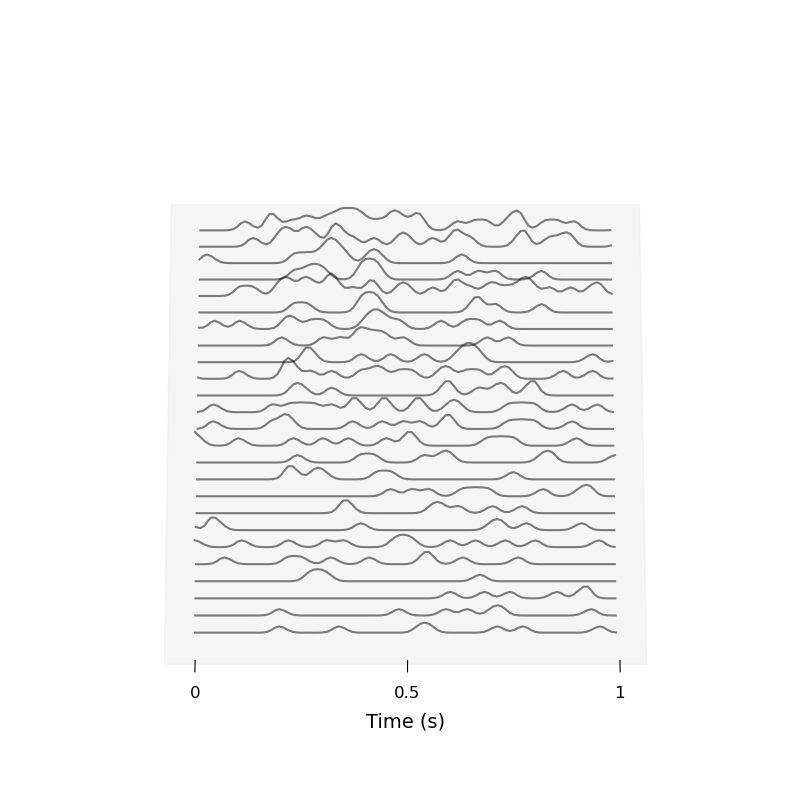

In [26]:
fig = plt.figure(figsize=(20,10))
ax = plt.axes(projection='3d')

idx = 3
# sort by variancec
var = np.var(x_[idx], axis=0)
#order = np.argsort(np.max(x_[idx], axis=0))
#order = np.argsort(np.mean(x_[idx], axis=0))
order = np.argsort(var)[::-1]
ax.view_init(elev=75, azim=0)

# Transparent spines
ax.grid(False)

ax.w_xaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.w_yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.w_zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))

# Transparent panes
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

for j, i in enumerate(order[0:25]):
    xx = x_[idx, :, i]
    # xx[xx <= -1] = np.nan
    ax.plot((2*j) * np.ones(x_.shape[1]), np.arange(x_.shape[1]), xx, 'k', alpha=0.5)
ax.set_zlim([0, 3])
ax.set_zticks([])
ax.set_xticks([])
#ax.set_xlabel('Neurons')
ax.set_yticks([0, 50, 100])
ax.set_yticklabels([0, 0.5, 1], fontsize=12)
#ax.tick_params(axis='y', labelize=14)
#ax.set_ylabel('Time (s)')
# fig, ax = lt.subplots(1, 1, figsize=(5, 5))
# ax.pcolor(x_[0].T, cmap='Greys')
ax.set_ylabel('Time (s)', fontsize=14, labelpad=10)
fig.savefig('/home/akumar/nse/neural_control/figs/loco_indy_merge/M1_traces.pdf', bbox_inches='tight', pad_inhces=0)

/tmp/ipykernel_25900/2596312562.py:38: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "pad_inhces" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig('/home/akumar/nse/neural_control/figs/loco_indy_merge/S1_traces.pdf', bbox_inches='tight', pad_inhces=0)


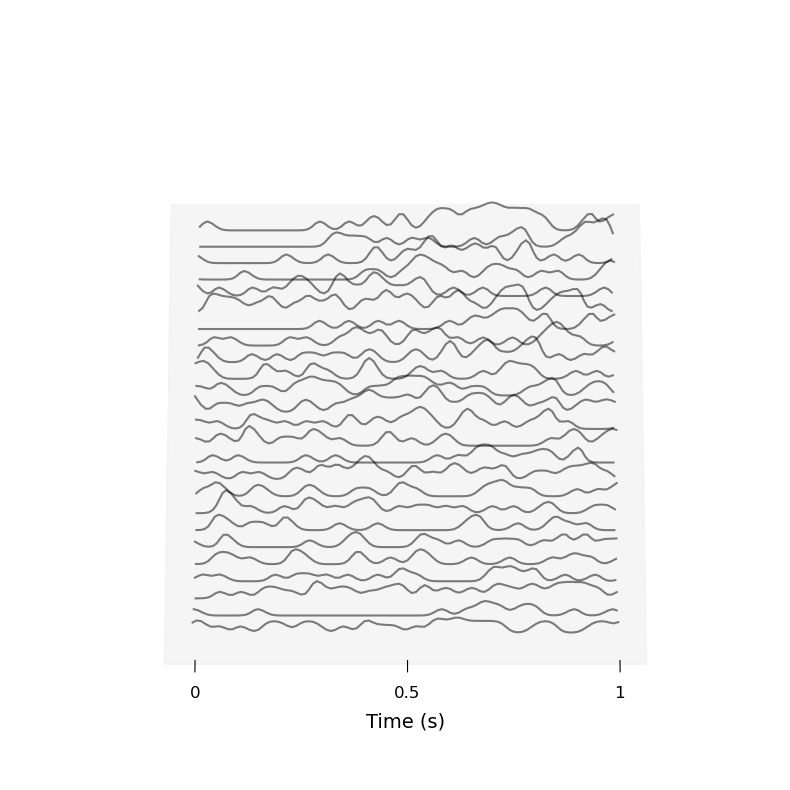

In [24]:
fig = plt.figure(figsize=(20,10))
ax = plt.axes(projection='3d')

idx = 3
# sort by variancec
var = np.var(y_[idx], axis=0)
#order = np.argsort(np.max(x_[idx], axis=0))
#order = np.argsort(np.mean(x_[idx], axis=0))
order = np.argsort(var)[::-1]
ax.view_init(elev=75, azim=0)

# Transparent spines
ax.grid(False)

ax.w_xaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.w_yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.w_zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))

# Transparent panes
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

for j, i in enumerate(order[0:25]):
    xx = y_[idx, :, i]
    # xx[xx <= -1] = np.nan
    ax.plot((2*j) * np.ones(y_.shape[1]), np.arange(y_.shape[1]), xx, 'k', alpha=0.5)
ax.set_zlim([0, 3])
ax.set_zticks([])
ax.set_xticks([])
#ax.set_xlabel('Neurons')
ax.set_yticks([0, 50, 100])
ax.set_yticklabels([0, 0.5, 1], fontsize=12)
#ax.tick_params(axis='y', labelize=14)
#ax.set_ylabel('Time (s)')
# fig, ax = lt.subplots(1, 1, figsize=(5, 5))
# ax.pcolor(x_[0].T, cmap='Greys')
ax.set_ylabel('Time (s)', fontsize=14, labelpad=10)
fig.savefig('/home/akumar/nse/neural_control/figs/loco_indy_merge/S1_traces.pdf', bbox_inches='tight', pad_inhces=0)

In [13]:
y_.shape

(491, 100, 153)

In [ ]:
# Traces of d = 6 projections onto PCA/FCCA/CCA subspaces:
fig = plt.figure(figsize=(20,10))
ax = plt.axes(projection='3d')

idx = 3

# Project onto PCA/FCCA subspaces



var = np.var(y_[idx], axis=0)
#order = np.argsort(np.max(x_[idx], axis=0))
#order = np.argsort(np.mean(x_[idx], axis=0))
order = np.argsort(var)[::-1]
ax.view_init(elev=75, azim=0)

# Transparent spines
ax.grid(False)

ax.w_xaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.w_yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.w_zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))

# Transparent panes
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

for j, i in enumerate(order[0:25]):
    xx = y_[idx, :, i]
    # xx[xx <= -1] = np.nan
    ax.plot((2*j) * np.ones(y_.shape[1]), np.arange(y_.shape[1]), xx, 'k', alpha=0.5)
ax.set_zlim([0, 3])
ax.set_zticks([])
ax.set_xticks([])
#ax.set_xlabel('Neurons')
ax.set_yticks([0, 50, 100])
ax.set_yticklabels([0, 0.5, 1], fontsize=12)
#ax.tick_params(axis='y', labelize=14)
#ax.set_ylabel('Time (s)')
# fig, ax = lt.subplots(1, 1, figsize=(5, 5))
# ax.pcolor(x_[0].T, cmap='Greys')
ax.set_ylabel('Time (s)', fontsize=14, labelpad=10)
fig.savefig('/home/akumar/nse/neural_control/figs/loco_indy_merge/S1_traces.pdf', bbox_inches='tight', pad_inhces=0)

In [ ]:
# Save as separate figures to be able tao adjust spacing...

### Regression of FCCA/PCA in S1 onto FCCA/PCA onto M1 (and vice versa), as well as S1 FCCA/PCA onto M1 CC, S1 CC (vice versa)

In [11]:
with open('/mnt/Secondary/data/postprocessed/loco_decoding_df.dat', 'rb') as f:
    result_list = pickle.load(f)
with open('/mnt/Secondary/data/postprocessed/indy_S1_df.dat', 'rb') as f:
    rl2 = pickle.load(f)

/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator LinearRegression from version 0.24.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [12]:
loco_S1df = pd.DataFrame(result_list)
indy_S1df = pd.DataFrame(rl2)

In [91]:
with open('/mnt/Secondary/data/postprocessed/indy_decoding_df2.dat', 'rb') as f:
    indy_df = pickle.load(f)
indy_df = pd.DataFrame(indy_df)

/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator LinearRegression from version 0.24.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [13]:
with open('/mnt/Secondary/data/postprocessed/loco_decoding_df.dat', 'rb') as f:
    loco_df = pickle.load(f)
loco_df = pd.DataFrame(loco_df)
loco_df = apply_df_filters(loco_df,
                        loader_args={'bin_width': 50, 'filter_fn': 'none', 'filter_kwargs': {}, 'boxcox': 0.5, 'spike_threshold': 100, 'region': 'M1'},
                        decoder_args={'trainlag': 4, 'testlag': 4, 'decoding_window': 5})

/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator LinearRegression from version 0.24.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [14]:
with open('/mnt/Secondary/data/postprocessed/sabes_cca50cv_df.dat', 'rb') as f:
    ccadf = pickle.load(f)

In [15]:
with open('/mnt/Secondary/data/postprocessed/sabes_cca50_cvall.dat', 'rb') as f:
    ccadf2 = pickle.load(f)

In [26]:
fls = np.unique(ccadf['fl'].values)

In [56]:
np.unique(loco_S1df['data_file'].values)

array(['loco_20170210_03.mat', 'loco_20170213_02.mat',
       'loco_20170214_02.mat', 'loco_20170215_02.mat',
       'loco_20170216_02.mat', 'loco_20170217_02.mat',
       'loco_20170227_04.mat', 'loco_20170228_02.mat',
       'loco_20170301_05.mat', 'loco_20170302_02.mat'], dtype=object)

In [310]:
fls

array(['/mnt/Secondary/data/sabes_tmp50/indy_20160426_01.pkl',
       '/mnt/Secondary/data/sabes_tmp50/loco_20170210_03.pkl',
       '/mnt/Secondary/data/sabes_tmp50/loco_20170213_02.pkl',
       '/mnt/Secondary/data/sabes_tmp50/loco_20170215_02.pkl',
       '/mnt/Secondary/data/sabes_tmp50/loco_20170227_04.pkl',
       '/mnt/Secondary/data/sabes_tmp50/loco_20170228_02.pkl',
       '/mnt/Secondary/data/sabes_tmp50/loco_20170301_05.pkl',
       '/mnt/Secondary/data/sabes_tmp50/loco_20170302_02.pkl'],
      dtype=object)

In [307]:
# S1 Subspaces -> S1 CC subspaces (and vice-versa)
ss2cc_S1 = np.zeros((fls.size, 6, 3, 5, 5))
ss2cc_S1coef = np.zeros((fls.size, 6, 3, 5, 5), dtype=object)
ss2cc_S1coef_cascaded = np.zeros((fls.size, 6, 3, 5, 5), dtype=object)
dims = np.array([1, 2, 6, 8, 12])

# We observed lags do not matter, so don't overcomplicate things
lags = np.array([0, 0, 0])
w = 3

# S1 subspace angles/loading correlations
ss_anglesS1 = np.zeros((fls.size, 3, 5, 5))
ss_anglesS1_raw = np.zeros((fls.size, 3, 5, 5), dtype=object)

lcorrS1 = np.zeros((fls.size, 3, 5, 5))
lcorrS1_raw = np.zeros((fls.size, 3, 5, 5, 2), dtype=object)

for i, fl in tqdm(enumerate(fls)):
    with open(fl, 'rb') as f:
        _ = pickle.load(f)
        datS1 = pickle.load(f)

    x = datS1['spike_rates'].squeeze()

    # Get the subspaces
    data_file = fl.split('/')[-1].split('.pkl')[0]
    data_file += '.mat'

    for j, dim in enumerate(dims):

        if 'indy' in data_file:
            pcadf = apply_df_filters(indy_S1df, data_file=data_file, dimreduc_method='PCA', dim=dim)
        elif 'loco' in data_file:
            pcadf = apply_df_filters(loco_S1df, data_file=data_file, dimreduc_method='PCA', dim=dim, 
                                     decoder_args={'trainlag':4, 'testlag':4, 'decoding_window':5},
                                     loader_args={'bin_width': 50,
                                                  'filter_fn': 'none',
                                                  'filter_kwargs': {},
                                                  'boxcox': 0.5,
                                                  'spike_threshold': 100,
                                                  'region': 'S1'})

        assert(pcadf.shape[0] == 5)

        if 'indy' in data_file:
            lqgdf = apply_df_filters(indy_S1df, data_file=data_file, dimreduc_method='LQGCA', dim=dim, dimreduc_args={'T':3, 'loss_type':'trace', 'n_init':10})
        elif 'loco' in data_file:
            lqgdf = apply_df_filters(loco_S1df, data_file=data_file, dimreduc_method='LQGCA', dim=dim, 
            dimreduc_args={'T':3, 'loss_type':'trace', 'n_init':10},
            decoder_args={'trainlag':4, 'testlag':4, 'decoding_window':5},
            loader_args={'bin_width': 50,
                        'filter_fn': 'none',
                        'filter_kwargs': {},
                        'boxcox': 0.5,
                        'spike_threshold': 100,
                        'region': 'S1'})

        assert(lqgdf.shape[0] == 5)

        for fold in range(5):
            d1_ = apply_df_filters(pcadf, fold_idx=fold)
            d2_ = apply_df_filters(lqgdf, fold_idx=fold)
            dc_ = apply_df_filters(ccadf2, fold_idx=fold, fl=fl)

            model = dc_.iloc[0]['ccamodel']
            Vpca = d1_.iloc[0]['coef']
            Vfca = d2_.iloc[0]['coef']
            Vcca = model.x_rotations_[:, 0:dim]

            # Subspace angles/loadings correlations
            ss_anglesS1[i, 0, j, fold] = np.mean(scipy.linalg.subspace_angles(Vpca, Vcca))
            ss_anglesS1[i, 1, j, fold] = np.mean(scipy.linalg.subspace_angles(Vfca, Vcca))
            ss_anglesS1[i, 2, j, fold] = np.mean(scipy.linalg.subspace_angles(Vpca, Vfca))

            ss_anglesS1_raw[i, 0, j, fold] = scipy.linalg.subspace_angles(Vpca, Vcca)
            ss_anglesS1_raw[i, 1, j, fold] = scipy.linalg.subspace_angles(Vfca, Vcca)
            ss_anglesS1_raw[i, 2, j, fold] = scipy.linalg.subspace_angles(Vpca, Vfca)


            lcorrS1[i, 0, j, fold] = scipy.stats.spearmanr(calc_loadings(Vpca), calc_loadings(Vcca))[0]
            lcorrS1[i, 1, j, fold] = scipy.stats.spearmanr(calc_loadings(Vfca), calc_loadings(Vcca))[0]
            lcorrS1[i, 2, j, fold] = scipy.stats.spearmanr(calc_loadings(Vpca), calc_loadings(Vfca))[0]

            lcorrS1_raw[i, 0, j, fold, 0] = calc_loadings(Vpca)
            lcorrS1_raw[i, 0, j, fold, 1] = calc_loadings(Vcca)

            lcorrS1_raw[i, 1, j, fold, 0] = calc_loadings(Vfca)
            lcorrS1_raw[i, 1, j, fold, 1] = calc_loadings(Vcca)

            lcorrS1_raw[i, 2, j, fold, 0] = calc_loadings(Vpca)
            lcorrS1_raw[i, 2, j, fold, 1] = calc_loadings(Vfca)

            # Regression

            # M1 PCA
            ytrainp = x[d1_.iloc[0]['train_idxs']] @ Vpca
            ytestp = x[d1_.iloc[0]['test_idxs']] @ Vpca        

            ytrainf = x[d1_.iloc[0]['train_idxs']] @ Vfca
            ytestf = x[d1_.iloc[0]['test_idxs']] @ Vfca        

            # M1 CCA
            xtrain = x[d1_.iloc[0]['train_idxs']] @ Vcca
            xtest = x[d1_.iloc[0]['test_idxs']] @ Vcca

            # Lag
            for k, lag_ in enumerate(lags):
                # Have this be PCA lagging CCA
                if lag_ > 0:
                    ytrainp_lag = ytrainp[:-lag_]
                    ytestp_lag = ytestp[:-lag_]

                    ytrainf_lag = ytrainf[:-lag_]
                    ytestf_lag = ytestf[:-lag_]

                    xtrain_lag = xtrain[lag_:]
                    xtest_lag = xtest[lag_:]
                elif lag_ < 0:
                    xtrain_lag = xtrain[:lag_]
                    xtest_lag = xtest[:lag_]

                    ytrainp_lag = ytrainp[-lag_:]
                    ytestp_lag = ytestp[-lag_:]

                    ytrainf_lag = ytrainf[-lag_:]
                    ytestf_lag = ytestf[-lag_:]
                else:
                    xtrain_lag = xtrain
                    xtest_lag = xtest

                    ytrainp_lag = ytrainp
                    ytestp_lag = ytestp

                    ytrainf_lag = ytrainf
                    ytestf_lag = ytestf

                # Window (x regresses onto y)
                if w > 1:
                    xtrain_lag_win = form_lag_matrix(xtrain_lag, w)
                    xtest_lag_win = form_lag_matrix(xtest_lag, w)

                    ytrainp_lag_win = ytrainp_lag[w//2:]
                    ytrainp_lag_win = ytrainp_lag_win[:xtrain_lag_win.shape[0]]
                    ytestp_lag_win = ytestp_lag[w//2:]
                    ytestp_lag_win = ytestp_lag_win[:xtest_lag_win.shape[0]]

                    ytrainf_lag_win = ytrainf_lag[w//2:]
                    ytrainf_lag_win = ytrainf_lag_win[:xtrain_lag_win.shape[0]]
                    ytestf_lag_win = ytestf_lag[w//2:]
                    ytestf_lag_win = ytestf_lag_win[:xtest_lag_win.shape[0]]

                ytrainp_lag_win = StandardScaler().fit_transform(ytrainp_lag_win)                
                ytestp_lag_win = StandardScaler().fit_transform(ytestp_lag_win)
                
                ytrainf_lag_win = StandardScaler().fit_transform(ytrainf_lag_win)                
                ytestf_lag_win = StandardScaler().fit_transform(ytestf_lag_win)

                xtrain_lag_win = StandardScaler().fit_transform(xtrain_lag_win)
                xtest_lag_win = StandardScaler().fit_transform(xtest_lag_win)

                linmodel = RidgeCV()
                linmodel.fit(xtrain_lag_win, ytrainp_lag_win)
                ss2cc_S1[i, 0, k, j, fold] = linmodel.score(xtest_lag_win, ytestp_lag_win)
                ss2cc_S1coef[i, 0, k, j, fold] = linmodel.coef_
                ss2cc_S1coef_cascaded[i, 0, k, j, fold] = np.tile(Vcca, (1, w)) @ linmodel.coef_.T

                linmodel = RidgeCV()
                linmodel.fit(xtrain_lag_win, ytrainf_lag_win)
                ss2cc_S1[i, 2, k, j, fold] = linmodel.score(xtest_lag_win, ytestf_lag_win)
                ss2cc_S1coef[i, 2, k, j, fold] = linmodel.coef_
                ss2cc_S1coef_cascaded[i, 2, k, j, fold] = np.tile(Vcca, (1, w)) @ linmodel.coef_.T

                ytrainf_win = form_lag_matrix(ytrainf, w)
                ytestf_win = form_lag_matrix(ytestf, w)

                linmodel = RidgeCV()
                linmodel.fit(ytrainf_win, ytrainp_lag_win)
                ss2cc_S1[i, 4, k, j, fold] = linmodel.score(ytestf_win, ytestp_lag_win)
                ss2cc_S1coef[i, 4, k, j, fold] = linmodel.coef_
                ss2cc_S1coef_cascaded[i, 4, k, j, fold] = np.tile(Vfca, (1, w)) @ linmodel.coef_.T

                # Window (y regresses onto x)
                if w > 1:
                    ytrainp_lag_win = form_lag_matrix(ytrainp_lag, w)
                    ytestp_lag_win = form_lag_matrix(ytestp_lag, w)

                    ytrainf_lag_win = form_lag_matrix(ytrainf_lag, w)
                    ytestf_lag_win = form_lag_matrix(ytestf_lag, w)
                    
                    xtrain_lag_win = xtrain_lag[w//2:]
                    xtrain_lag_win = xtrain_lag_win[:ytrainp_lag_win.shape[0]]

                    xtest_lag_win = xtest_lag[w//2:]
                    xtest_lag_win = xtest_lag_win[:ytestp_lag_win.shape[0]]

                ytrainp_lag_win = StandardScaler().fit_transform(ytrainp_lag_win)                
                ytestp_lag_win = StandardScaler().fit_transform(ytestp_lag_win)
                
                ytrainf_lag_win = StandardScaler().fit_transform(ytrainf_lag_win)                
                ytestf_lag_win = StandardScaler().fit_transform(ytestf_lag_win)

                xtrain_lag_win = StandardScaler().fit_transform(xtrain_lag_win)
                xtest_lag_win = StandardScaler().fit_transform(xtest_lag_win)

                linmodel = RidgeCV()
                linmodel.fit(ytrainp_lag_win, xtrain_lag_win)
                ss2cc_S1[i, 1, k, j, fold] = linmodel.score(ytestp_lag_win, xtest_lag_win)
                ss2cc_S1coef[i, 1, k, j, fold] = linmodel.coef_
                ss2cc_S1coef_cascaded[i, 1, k, j, fold] = np.tile(Vpca, (1, w)) @ linmodel.coef_.T

                linmodel = RidgeCV()
                linmodel.fit(ytrainf_lag_win, xtrain_lag_win)
                ss2cc_S1[i, 3, k, j, fold] = linmodel.score(ytestf_lag_win, xtest_lag_win)
                ss2cc_S1coef[i, 3, k, j, fold] = linmodel.coef_
                ss2cc_S1coef_cascaded[i, 3, k, j, fold] = np.tile(Vfca, (1, w)) @ linmodel.coef_.T

                ytrainf_win = ytrainf[w//2:]
                ytrainf_win = ytrainf[:ytrainp_lag_win.shape[0]]
                ytestf_win = ytestf[w//2:]
                ytestf_win = ytestf[:ytestp_lag_win.shape[0]]

                linmodel = RidgeCV()
                linmodel.fit(ytrainp_lag_win, ytrainf_win)
                ss2cc_S1[i, 5, k, j, fold] = linmodel.score(ytestp_lag_win, ytestf_win)
                ss2cc_S1coef[i, 5, k, j, fold] = linmodel.coef_
                ss2cc_S1coef_cascaded[i, 5, k, j, fold] = np.tile(Vpca, (1, w)) @ linmodel.coef_.T


8it [01:02,  7.83s/it]


In [79]:
ss_angles.shape

(8, 3, 5, 5)

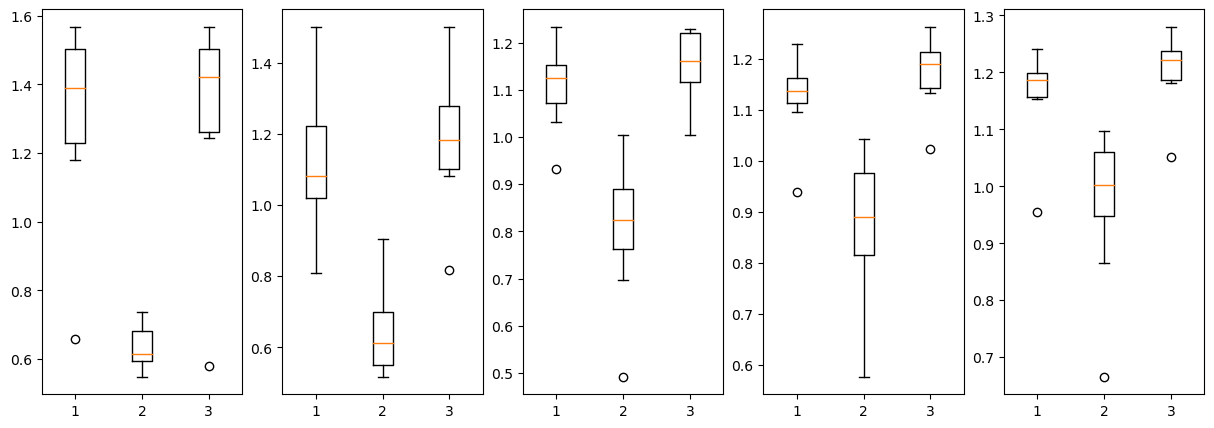

In [81]:
# Visualize subspace angles and loading correlations
fig, ax = plt.subplots(1, 5, figsize=(15, 5))
for j in range(5):
    a = ax[j]
    a.boxplot(np.mean(ss_angles[:, :, j, :], axis=-1))

In [82]:
lcorr.shape

(8, 3, 5, 5)

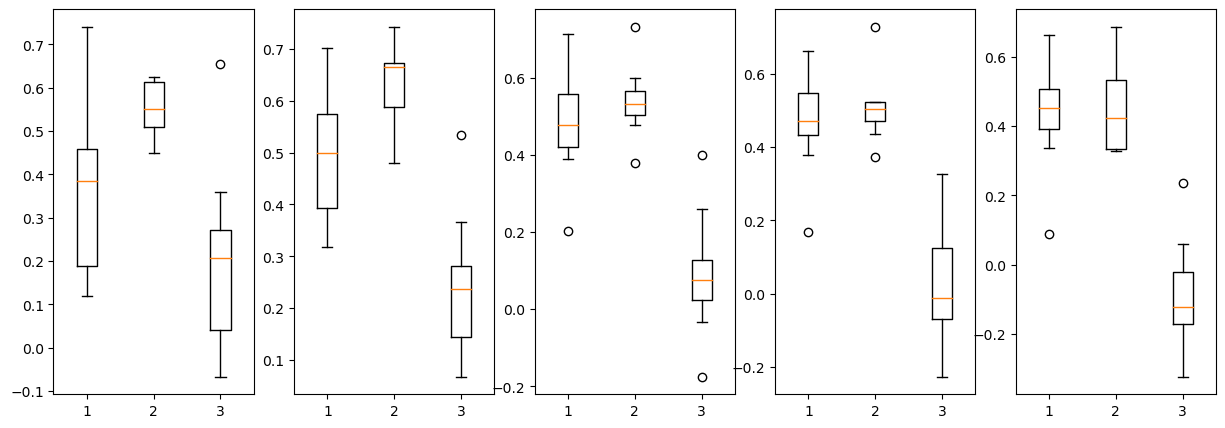

In [84]:
# Visualize subspace angles and loading correlations
fig, ax = plt.subplots(1, 5, figsize=(15, 5))
for j in range(5):
    a = ax[j]
    a.boxplot(np.mean(lcorr[:, :, j, :], axis=-1))

In [85]:
ss2cc_S1.shape

(8, 6, 3, 5, 5)

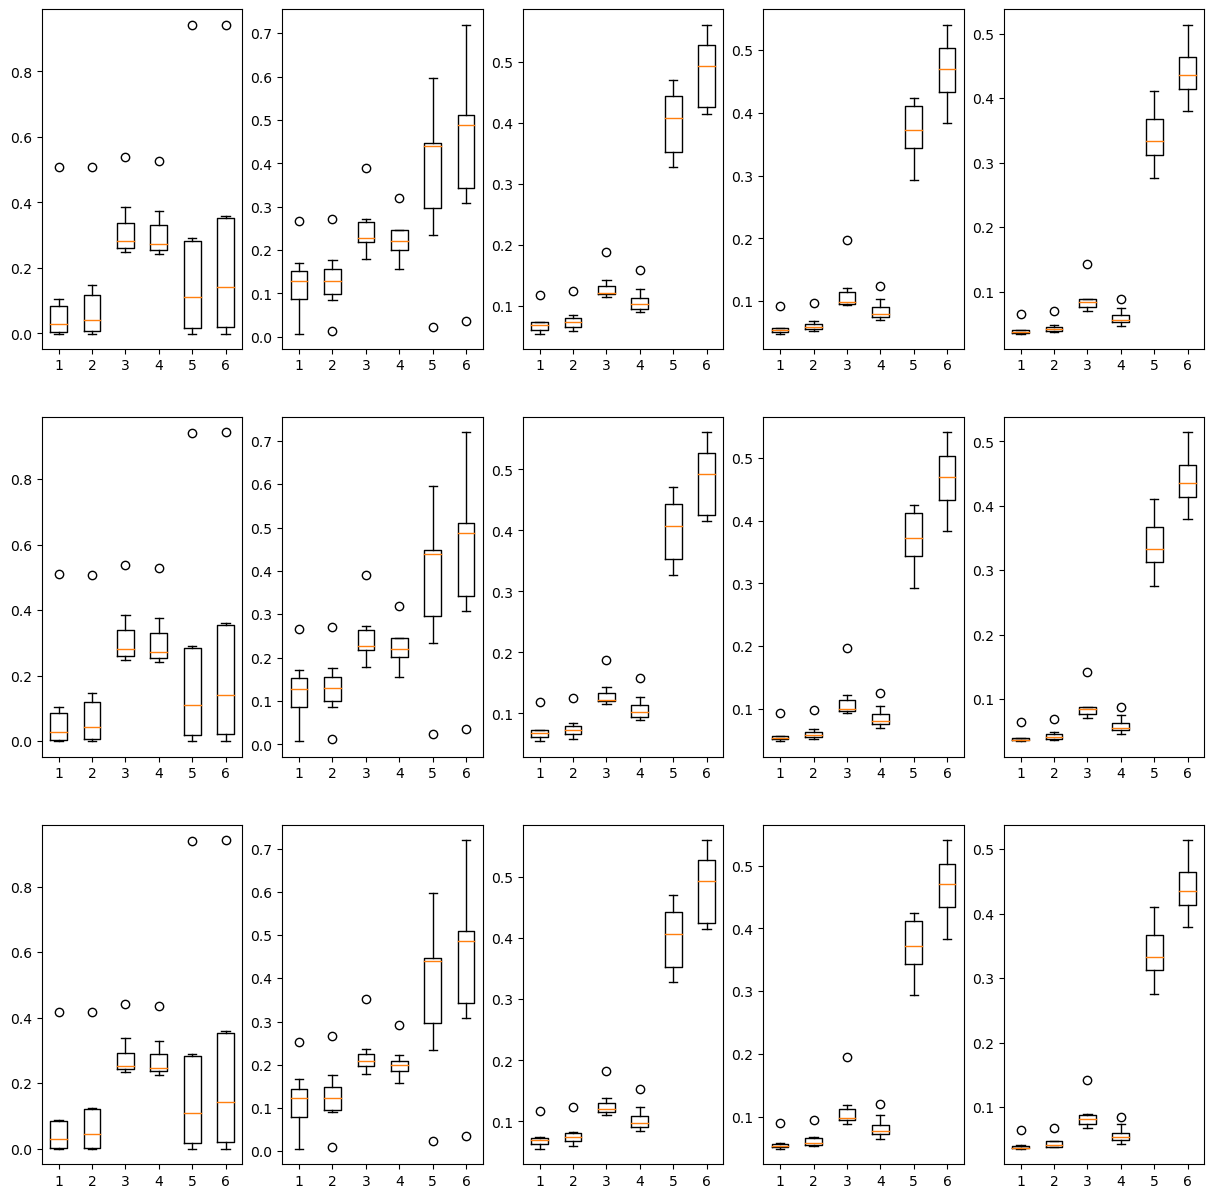

In [89]:
# Visualize regressions 
# Visualize subspace angles and loading correlations
fig, ax = plt.subplots(3, 5, figsize=(15, 15))
for i in range(3):
    for j in range(5):
        a = ax[i, j]
        a.boxplot(np.mean(ss2cc_S1[..., i, j, :], axis=-1))

In [98]:
# Is there any predictability between S1 subspaces and M1 subspaces?

ss2ss = np.zeros((fls.size, 18, 3, 5, 5))
dims = np.array([1, 2, 6, 8, 12])
lags = np.array([-2, 0, 2])
w = 3

for i, fl in tqdm(enumerate(fls)):
    with open(fl, 'rb') as f:
        datM1 = pickle.load(f)
        datS1 = pickle.load(f)

    x = datS1['spike_rates'].squeeze()
    y = datM1['spike_rates'].squeeze()

    # Get the subspaces
    data_file = fl.split('/')[-1].split('.pkl')[0]
    data_file += '.mat'

    for j, dim in enumerate(dims):

        if 'indy' in data_file:
            pcadfS1 = apply_df_filters(indy_S1df, data_file=data_file, dimreduc_method='PCA', dim=dim)
            pcadfM1 = apply_df_filters(indy_df, data_file=data_file, dimreduc_method='PCA', dim=dim)

        elif 'loco' in data_file:
            pcadfS1 = apply_df_filters(loco_S1df, data_file=data_file, dimreduc_method='PCA', dim=dim, 
                                     decoder_args={'trainlag':4, 'testlag':4, 'decoding_window':5},
                                     loader_args={'bin_width': 50,
                                                  'filter_fn': 'none',
                                                  'filter_kwargs': {},
                                                  'boxcox': 0.5,
                                                  'spike_threshold': 100,
                                                  'region': 'S1'})
            pcadfM1 = apply_df_filters(loco_df, data_file=data_file, dimreduc_method='PCA', dim=dim)

        assert(pcadfS1.shape[0] == 5)
        assert(pcadfM1.shape[0] == 5)

        if 'indy' in data_file:
            lqgdfS1 = apply_df_filters(indy_S1df, data_file=data_file, dimreduc_method='LQGCA', dim=dim, dimreduc_args={'T':3, 'loss_type':'trace', 'n_init':10})
            lqgdfM1 = apply_df_filters(indy_df, data_file=data_file, dimreduc_method='LQGCA', dim=dim, dimreduc_args={'T':3, 'loss_type':'trace', 'n_init':10})
        elif 'loco' in data_file:
            lqgdfS1 = apply_df_filters(loco_S1df, data_file=data_file, dimreduc_method='LQGCA', dim=dim, 
                                       dimreduc_args={'T':3, 'loss_type':'trace', 'n_init':10},
                                       decoder_args={'trainlag':4, 'testlag':4, 'decoding_window':5},
                                       loader_args={'bin_width': 50,
                                                    'filter_fn': 'none',
                                                    'filter_kwargs': {},
                                                    'boxcox': 0.5,
                                                    'spike_threshold': 100,
                                                    'region': 'S1'})
            lqgdfM1 = apply_df_filters(loco_df, data_file=data_file, dimreduc_method='LQGCA', dim=dim, dimreduc_args={'T':3, 'loss_type':'trace', 'n_init':10})

        assert(lqgdfS1.shape[0] == 5)
        assert(lqgdfM1.shape[0] == 5)

        for fold in range(5):
            d1s_ = apply_df_filters(pcadfS1, fold_idx=fold)
            d2s_ = apply_df_filters(lqgdfS1, fold_idx=fold)

            d1m_ = apply_df_filters(pcadfM1, fold_idx=fold)
            d2m_ = apply_df_filters(lqgdfM1, fold_idx=fold)

            dc_ = apply_df_filters(ccadf2, fold_idx=fold, fl=fl)

            model = dc_.iloc[0]['ccamodel']
            VpcaS1 = d1s_.iloc[0]['coef']
            VfcaS1 = d2s_.iloc[0]['coef']
            VpcaM1 = d1m_.iloc[0]['coef']
            VfcaM1 = d2m_.iloc[0]['coef']

            VccaS1 = model.x_rotations_[:, 0:dim]
            VccaM1 = model.y_rotations_[:, 0:dim]
            
            # Regression

            # S1 PCA
            xtrainp = x[d1s_.iloc[0]['train_idxs']] @ VpcaS1
            xtestp = x[d1s_.iloc[0]['test_idxs']] @ VpcaS1        

            # S1 FCCA
            xtrainf = x[d2s_.iloc[0]['train_idxs']] @ VfcaS1
            xtestf = x[d2s_.iloc[0]['test_idxs']] @ VfcaS1     

            # S1 CCA
            xtrainc = x[d1s_.iloc[0]['train_idxs']] @ VccaS1
            xtestc = x[d1s_.iloc[0]['test_idxs']] @ VccaS1 

            # M1 PCA
            ytrainp = y[d1m_.iloc[0]['train_idxs']] @ VpcaM1
            ytestp = y[d1m_.iloc[0]['test_idxs']] @ VpcaM1        

            # M1 FCCA
            ytrainf = y[d1m_.iloc[0]['train_idxs']] @ VfcaM1
            ytestf = y[d1m_.iloc[0]['test_idxs']] @ VfcaM1     

            # M1 CCA
            ytrainc = y[d1m_.iloc[0]['train_idxs']] @ VccaM1
            ytestc = y[d1m_.iloc[0]['test_idxs']] @ VccaM1 

            # Lag
            for k, lag_ in enumerate(lags):
                # Have this be PCA lagging CCA
                if lag_ > 0:
                    xtrainp_lag = xtrainp[:-lag_]
                    xtestp_lag = xtestp[:-lag_]

                    xtrainf_lag = xtrainf[:-lag_]
                    xtestf_lag = xtestf[:-lag_]

                    xtrainc_lag = xtrainc[:-lag_]
                    xtestc_lag = xtestc[:-lag_]

                    ytrainp_lag = ytrainp[lag_:]
                    ytestp_lag = ytestp[lag_:]

                    ytrainf_lag = ytrainf[lag_:]
                    ytestf_lag = ytestf[lag_:]

                    ytrainc_lag = ytrainc[lag_:]
                    ytestc_lag = ytestc[lag_:]

                elif lag_ < 0:
                    xtrainp_lag = xtrainp[-lag_:]
                    xtestp_lag = xtestp[-lag_:]

                    xtrainf_lag = xtrainf[-lag_:]
                    xtestf_lag = xtestf[-lag_:]

                    xtrainc_lag = xtrainc[-lag_:]
                    xtestc_lag = xtestc[-lag_:]

                    ytrainp_lag = ytrainp[:lag_]
                    ytestp_lag = ytestp[:lag_]

                    ytrainf_lag = ytrainf[:lag_]
                    ytestf_lag = ytestf[:lag_]

                    ytrainc_lag = ytrainc[:lag_]
                    ytestc_lag = ytestc[:lag_]


                # Window (x regresses onto y)
                if w > 1:
                    xtrainp_lag_win = form_lag_matrix(xtrainp_lag, w)
                    xtestp_lag_win = form_lag_matrix(xtestp_lag, w)

                    xtrainf_lag_win = form_lag_matrix(xtrainf_lag, w)
                    xtestf_lag_win = form_lag_matrix(xtestf_lag, w)

                    xtrainc_lag_win = form_lag_matrix(xtrainc_lag, w)
                    xtestc_lag_win = form_lag_matrix(xtestc_lag, w)

                    ytrainp_lag_win = ytrainp_lag[w//2:]
                    ytrainp_lag_win = ytrainp_lag_win[:xtrainp_lag_win.shape[0]]
                    ytestp_lag_win = ytestp_lag[w//2:]
                    ytestp_lag_win = ytestp_lag_win[:xtestp_lag_win.shape[0]]

                    ytrainf_lag_win = ytrainf_lag[w//2:]
                    ytrainf_lag_win = ytrainf_lag_win[:xtrainp_lag_win.shape[0]]
                    ytestf_lag_win = ytestf_lag[w//2:]
                    ytestf_lag_win = ytestf_lag_win[:xtestp_lag_win.shape[0]]

                    ytrainc_lag_win = ytrainc_lag[w//2:]
                    ytrainc_lag_win = ytrainc_lag_win[:xtrainp_lag_win.shape[0]]
                    ytestc_lag_win = ytestc_lag[w//2:]
                    ytestc_lag_win = ytestc_lag_win[:xtestp_lag_win.shape[0]]


                ytrainp_lag_win = StandardScaler().fit_transform(ytrainp_lag_win)                
                ytestp_lag_win = StandardScaler().fit_transform(ytestp_lag_win)
                
                ytrainf_lag_win = StandardScaler().fit_transform(ytrainf_lag_win)                
                ytestf_lag_win = StandardScaler().fit_transform(ytestf_lag_win)

                ytrainc_lag_win = StandardScaler().fit_transform(ytrainc_lag_win)                
                ytestc_lag_win = StandardScaler().fit_transform(ytestc_lag_win)

                xtrainp_lag_win = StandardScaler().fit_transform(xtrainp_lag_win)
                xtestp_lag_win = StandardScaler().fit_transform(xtestp_lag_win)

                xtrainf_lag_win = StandardScaler().fit_transform(xtrainf_lag_win)
                xtestf_lag_win = StandardScaler().fit_transform(xtestf_lag_win)

                xtrainc_lag_win = StandardScaler().fit_transform(xtrainc_lag_win)
                xtestc_lag_win = StandardScaler().fit_transform(xtestc_lag_win)

                linmodel = RidgeCV()
                linmodel.fit(xtrainp_lag_win, ytrainp_lag_win)
                ss2ss[i, 0, k, j, fold] = linmodel.score(xtestp_lag_win, ytestp_lag_win)

                linmodel = RidgeCV()
                linmodel.fit(xtrainp_lag_win, ytrainf_lag_win)
                ss2ss[i, 2, k, j, fold] = linmodel.score(xtestp_lag_win, ytestf_lag_win)

                linmodel = RidgeCV()
                linmodel.fit(xtrainp_lag_win, ytrainc_lag_win)
                ss2ss[i, 4, k, j, fold] = linmodel.score(xtestp_lag_win, ytestc_lag_win)

                linmodel = RidgeCV()
                linmodel.fit(xtrainf_lag_win, ytrainp_lag_win)
                ss2ss[i, 6, k, j, fold] = linmodel.score(xtestf_lag_win, ytestp_lag_win)

                linmodel = RidgeCV()
                linmodel.fit(xtrainf_lag_win, ytrainf_lag_win)
                ss2ss[i, 8, k, j, fold] = linmodel.score(xtestf_lag_win, ytestf_lag_win)

                linmodel = RidgeCV()
                linmodel.fit(xtrainf_lag_win, ytrainc_lag_win)
                ss2ss[i, 10, k, j, fold] = linmodel.score(xtestf_lag_win, ytestc_lag_win)

                linmodel = RidgeCV()
                linmodel.fit(xtrainc_lag_win, ytrainp_lag_win)
                ss2ss[i, 12, k, j, fold] = linmodel.score(xtestc_lag_win, ytestp_lag_win)

                linmodel = RidgeCV()
                linmodel.fit(xtrainc_lag_win, ytrainf_lag_win)
                ss2ss[i, 14, k, j, fold] = linmodel.score(xtestc_lag_win, ytestf_lag_win)

                linmodel = RidgeCV()
                linmodel.fit(xtrainc_lag_win, ytrainc_lag_win)
                ss2ss[i, 16, k, j, fold] = linmodel.score(xtestc_lag_win, ytestc_lag_win)

                # Window (y regresses onto x)
                if w > 1:
                    ytrainp_lag_win = form_lag_matrix(ytrainp_lag, w)
                    ytestp_lag_win = form_lag_matrix(ytestp_lag, w)

                    ytrainf_lag_win = form_lag_matrix(ytrainf_lag, w)
                    ytestf_lag_win = form_lag_matrix(ytestf_lag, w)
                    
                    ytrainc_lag_win = form_lag_matrix(ytrainc_lag, w)
                    ytestc_lag_win = form_lag_matrix(ytestc_lag, w)

                    xtrainp_lag_win = xtrainp_lag[w//2:]
                    xtrainp_lag_win = xtrainp_lag_win[:ytrainp_lag_win.shape[0]]
                    xtestp_lag_win = xtestp_lag[w//2:]
                    xtestp_lag_win = xtestp_lag_win[:ytestp_lag_win.shape[0]]

                    xtrainf_lag_win = xtrainf_lag[w//2:]
                    xtrainf_lag_win = xtrainf_lag_win[:ytrainp_lag_win.shape[0]]
                    xtestf_lag_win = xtestf_lag[w//2:]
                    xtestf_lag_win = xtestf_lag_win[:ytestp_lag_win.shape[0]]

                    xtrainc_lag_win = xtrainc_lag[w//2:]
                    xtrainc_lag_win = xtrainc_lag_win[:ytrainp_lag_win.shape[0]]
                    xtestc_lag_win = xtestc_lag[w//2:]
                    xtestc_lag_win = xtestc_lag_win[:ytestp_lag_win.shape[0]]


                ytrainp_lag_win = StandardScaler().fit_transform(ytrainp_lag_win)                
                ytestp_lag_win = StandardScaler().fit_transform(ytestp_lag_win)
                
                ytrainf_lag_win = StandardScaler().fit_transform(ytrainf_lag_win)                
                ytestf_lag_win = StandardScaler().fit_transform(ytestf_lag_win)

                xtrainp_lag_win = StandardScaler().fit_transform(xtrainp_lag_win)
                xtestp_lag_win = StandardScaler().fit_transform(xtestp_lag_win)

                xtrainf_lag_win = StandardScaler().fit_transform(xtrainf_lag_win)
                xtestf_lag_win = StandardScaler().fit_transform(xtestf_lag_win)

                xtrainc_lag_win = StandardScaler().fit_transform(xtrainc_lag_win)
                xtestc_lag_win = StandardScaler().fit_transform(xtestc_lag_win)

                linmodel = RidgeCV()
                linmodel.fit(ytrainp_lag_win, xtrainp_lag_win)
                ss2ss[i, 1, k, j, fold] = linmodel.score(ytestp_lag_win, xtestp_lag_win)

                linmodel = RidgeCV()
                linmodel.fit(ytrainf_lag_win, xtrainp_lag_win)
                ss2ss[i, 3, k, j, fold] = linmodel.score(ytestf_lag_win, xtestp_lag_win)

                linmodel = RidgeCV()
                linmodel.fit(ytrainc_lag_win, xtrainp_lag_win)
                ss2ss[i, 5, k, j, fold] = linmodel.score(ytestc_lag_win, xtestp_lag_win)

                linmodel = RidgeCV()
                linmodel.fit(ytrainp_lag_win, xtrainf_lag_win)
                ss2ss[i, 7, k, j, fold] = linmodel.score(ytestp_lag_win, xtestf_lag_win)

                linmodel = RidgeCV()
                linmodel.fit(ytrainf_lag_win, xtrainf_lag_win)
                ss2ss[i, 9, k, j, fold] = linmodel.score(ytestf_lag_win, xtestf_lag_win)

                linmodel = RidgeCV()
                linmodel.fit(ytrainc_lag_win, xtrainf_lag_win)
                ss2ss[i, 11, k, j, fold] = linmodel.score(ytestc_lag_win, xtestf_lag_win)

                linmodel = RidgeCV()
                linmodel.fit(ytrainp_lag_win, xtrainc_lag_win)
                ss2ss[i, 13, k, j, fold] = linmodel.score(ytestp_lag_win, xtestc_lag_win)

                linmodel = RidgeCV()
                linmodel.fit(ytrainf_lag_win, xtrainc_lag_win)
                ss2ss[i, 15, k, j, fold] = linmodel.score(ytestf_lag_win, xtestc_lag_win)

                linmodel = RidgeCV()
                linmodel.fit(ytrainc_lag_win, xtrainc_lag_win)
                ss2ss[i, 17, k, j, fold] = linmodel.score(ytestc_lag_win, xtestc_lag_win)



8it [05:02, 37.86s/it]


In [99]:
ss2ss.shape

(8, 18, 3, 5, 5)

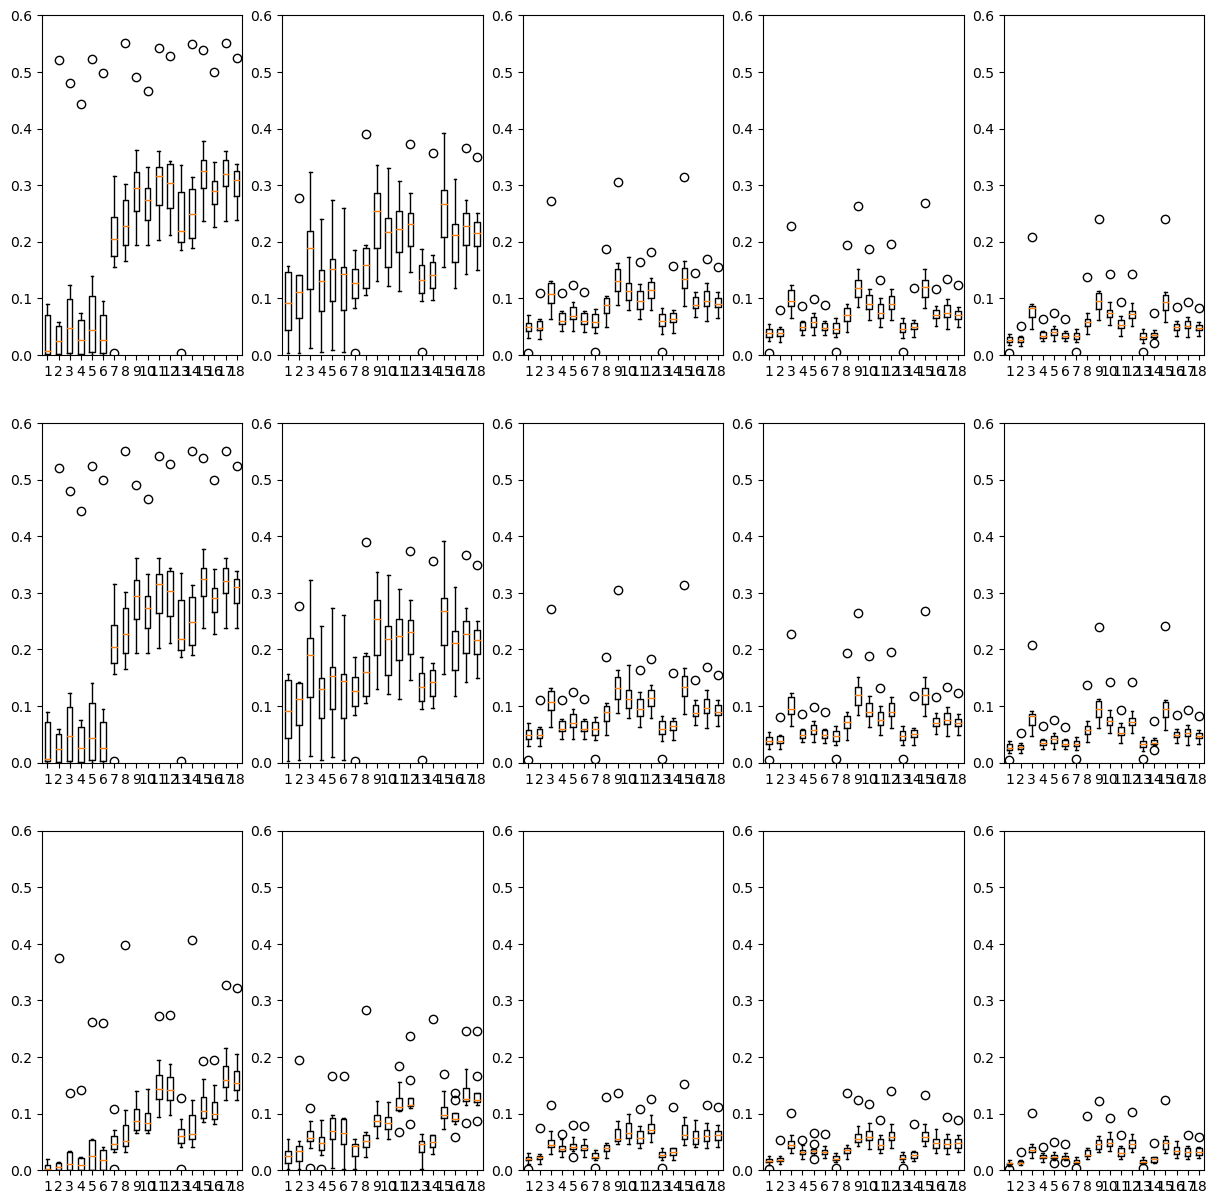

In [103]:
# Visualize regressions 
# Visualize subspace angles and loading correlations
fig, ax = plt.subplots(3, 5, figsize=(15, 15))
for i in range(3):
    for j in range(5):
        a = ax[i, j]
        a.boxplot(np.mean(ss2ss[..., i, j, :], axis=-1))
        a.set_ylim([0, 0.6])

In [259]:
# Save
with open('ss_mm_regressions_tmp.dat', 'wb') as f:
    f.write(pickle.dumps(ss2cc_S1))
    f.write(pickle.dumps(ss2ss))
    f.write(pickle.dumps(cc2ssM1))
    f.write(pickle.dumps(ss_anglesS1))
    f.write(pickle.dumps(cca_pca_ssa))
    f.write(pickle.dumps(cca_fcca_ssa))
    f.write(pickle.dumps(pca_fcca_ssa))
    f.write(pickle.dumps(cc2ssM1coef))
    f.write(pickle.dumps(ss2cc_S1coef))

In [207]:
dims

array([ 1,  2,  6,  8, 12])

In [254]:
# Arrange array to be fed into pcolor
subspaces = ['S1 PCA', 'S1 FCCA', 'S1 CC', 'M1 CC', 'M1 FCCA', 'M1 PCA']
r2_array = np.zeros((len(subspaces), len(subspaces)))

# Manually arrange this
dim_idx = 2
# S1 PCA -> 
r2_array[0, 1] = np.mean(ss2cc_S1[:, 5, 1, dim_idx, :])
r2_array[1, 0] = np.mean(ss2cc_S1[:, 4, 1, dim_idx, :])

r2_array[0, 2] = np.mean(ss2cc_S1[:, 1, 1, dim_idx, :])
r2_array[2, 0] = np.mean(ss2cc_S1[:, 0, 1, dim_idx, :])

r2_array[0, 3] = np.mean(ss2cc_S1[:, 1, 1, dim_idx, :])
r2_array[3, 0] = np.mean(ss2cc_S1[:, 0, 1, dim_idx, :])

r2_array[0, 3] = np.mean(ss2ss[:, 1, 1, dim_idx, :])
r2_array[3, 0] = np.mean(ss2ss[:, 0, 1, dim_idx, :])

r2_array[0, 3] = np.mean(ss2ss[:, 4, 1, dim_idx, :])
r2_array[3, 0] = np.mean(ss2ss[:, 5, 1, dim_idx, :])

r2_array[0, 4] = np.mean(ss2ss[:, 2, 1, dim_idx, :])
r2_array[4, 0] = np.mean(ss2ss[:, 3, 1, dim_idx, :])

r2_array[0, 5] = np.mean(ss2ss[:, 0, 1, dim_idx, :])
r2_array[5, 0] = np.mean(ss2ss[:, 1, 1, dim_idx, :])

# S1 FCCA -> 
r2_array[1, 2] = np.mean(ss2cc_S1[:, 3, 1, dim_idx, :])
r2_array[2, 1] = np.mean(ss2cc_S1[:, 2, 1, dim_idx, :])

r2_array[1, 3] = np.mean(ss2ss[:, 10, 1, dim_idx, :])
r2_array[3, 1] = np.mean(ss2ss[:, 11, 1, dim_idx, :])

r2_array[1, 4] = np.mean(ss2ss[:, 8, 1, dim_idx, :])
r2_array[4, 1] = np.mean(ss2ss[:, 9, 1, dim_idx, :])

r2_array[1, 5] = np.mean(ss2ss[:, 6, 1, dim_idx, :])
r2_array[5, 1] = np.mean(ss2ss[:, 7, 1, dim_idx, :])

# S1 CCA -> 
r2_array[2, 3] = np.mean(ss2ss[:, 16, 1, dim_idx, :])
r2_array[3, 2] = np.mean(ss2ss[:, 17, 1, dim_idx, :])

r2_array[2, 4] = np.mean(ss2ss[:, 14, 1, dim_idx, :])
r2_array[4, 2] = np.mean(ss2ss[:, 15, 1, dim_idx, :])

r2_array[2, 5] = np.mean(ss2ss[:, 12, 1, dim_idx, :])
r2_array[5, 2] = np.mean(ss2ss[:, 13, 1, dim_idx, :])

# M1 CCA -> 
r2_array[3, 4] = np.mean(cc2ssM1[:, 2, dim_idx, :])
r2_array[4, 3] = np.mean(cc2ssM1[:, 3, dim_idx, :])

r2_array[3, 5] = np.mean(cc2ssM1[:, 0, dim_idx, :])
r2_array[5, 3] = np.mean(cc2ssM1[:, 1, dim_idx, :])

# M1 FCCA ->
r2_array[4, 5] = np.mean(cc2ssM1[:, 4, dim_idx, :])
r2_array[5, 4] = np.mean(cc2ssM1[:, 5, dim_idx, :])

In [255]:
ss_array = np.zeros((len(subspaces), len(subspaces)))

# Only populate the within subspace blocks
# S1 PCA -> S1 FCCA
ss_array[0, 1] = np.mean(ss_anglesS1[:, 2, dim_idx, :])
ss_array[1, 0] = np.mean(ss_anglesS1[:, 2, dim_idx, :])

# S1 PCA --> S1 CCA
ss_array[0, 2] = np.mean(ss_anglesS1[:, 0, dim_idx, :])
ss_array[2, 0] = np.mean(ss_anglesS1[:, 0, dim_idx, :])

# S1 FCCA -> S1 CCA
ss_array[1, 2] = np.mean(ss_anglesS1[:, 1, dim_idx, :])
ss_array[2, 1] = np.mean(ss_anglesS1[:, 1, dim_idx, :])

# Already has been averaged over folds
# M1 CCA -> M1 FCCA
ss_array[3, 4] = np.mean(cca_fcca_ssa[:, dim_idx])
ss_array[4, 3] = np.mean(cca_fcca_ssa[:, dim_idx])

# M1 CCA --> M1 PCA
ss_array[3, 5] = np.mean(cca_pca_ssa[:, dim_idx])
ss_array[5, 3] = np.mean(cca_pca_ssa[:, dim_idx])

# M1 FCCA ->
ss_array[4, 5] = np.mean(pca_fcca_ssa[:, dim_idx])
ss_array[5, 4] = np.mean(pca_fcca_ssa[:, dim_idx])

In [251]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

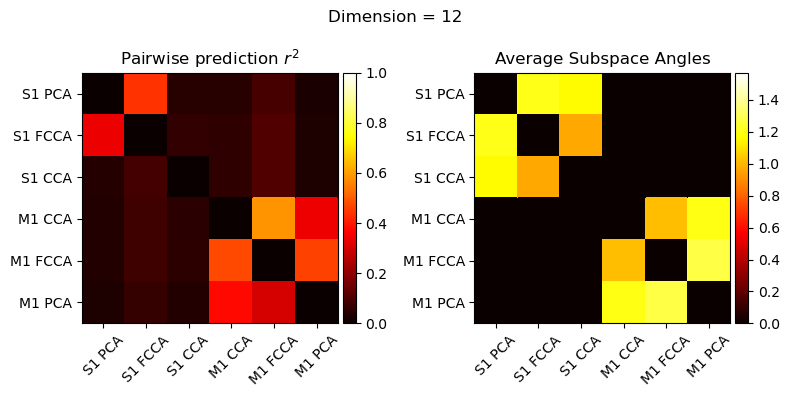

In [252]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

im1 = ax[0].pcolor(r2_array, vmin=0, vmax=1, cmap='hot')
ax[0].invert_yaxis()
ax[0].set_xticks([0.5, 1.5, 2.5, 3.5, 4.5, 5.5])
ax[0].set_xticklabels(['S1 PCA', 'S1 FCCA', 'S1 CCA', 'M1 CCA', 'M1 FCCA', 'M1 PCA'], rotation=45)
ax[0].set_yticks([0.5, 1.5, 2.5, 3.5, 4.5, 5.5])
ax[0].set_yticklabels(['S1 PCA', 'S1 FCCA', 'S1 CCA', 'M1 CCA', 'M1 FCCA', 'M1 PCA'])
ax[0].set_title('Pairwise prediction ' + r'$r^2$')

divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')

im2 = ax[1].pcolor(ss_array, vmin=0, vmax=np.pi/2, cmap='hot')
ax[1].invert_yaxis()
ax[1].set_xticks([0.5, 1.5, 2.5, 3.5, 4.5, 5.5])
ax[1].set_xticklabels(['S1 PCA', 'S1 FCCA', 'S1 CCA', 'M1 CCA', 'M1 FCCA', 'M1 PCA'], rotation=45)
ax[1].set_yticks([0.5, 1.5, 2.5, 3.5, 4.5, 5.5])
ax[1].set_yticklabels(['S1 PCA', 'S1 FCCA', 'S1 CCA', 'M1 CCA', 'M1 FCCA', 'M1 PCA'])
ax[1].set_title('Average Subspace Angles')

divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical')

fig.suptitle('Dimension = 12')
fig.tight_layout()
fig.savefig('/home/akumar/nse/neural_control/figs/cca/pairwise_r2ssd12.pdf', bbox_inches='tight', pad_inches=0)

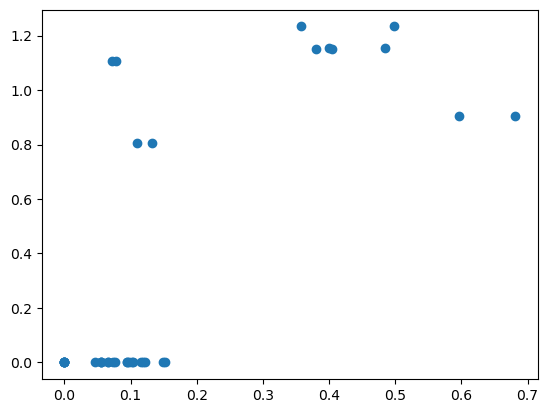

In [256]:
# Is there a relationship between subspace angle and prediction?
plt.scatter(r2_array.ravel(), ss_array.ravel())
# Basically no - plot is not needed

In [ ]:

# Can we isolate which dimensions/neurons are most accounting for the predictive power? --> sensitivity analysis (coefficient magnitude)
# Need all subspace predictions of behavior (sweeping over lags)    

In [ ]:
# Scatter 
# (1) regression coefficient against the subspace angle
# (2) regression coefficient against the 2 loadings (3D plot (?))

In [279]:
x = np.zeros((10, 2))
x[:, 0] = 1
x[:, 1] = 2

In [276]:
beta = np.array([[1, 2, 1, 2, 1, 2], [1, 2, 1, 2, 1, 2]])

In [281]:
beta.reshape((-1, 2, 3), order='F')[0, ...]

array([[1, 1, 1],
       [2, 2, 2]])

In [285]:
ss_anglesS1.shape

(8, 3, 5, 5)

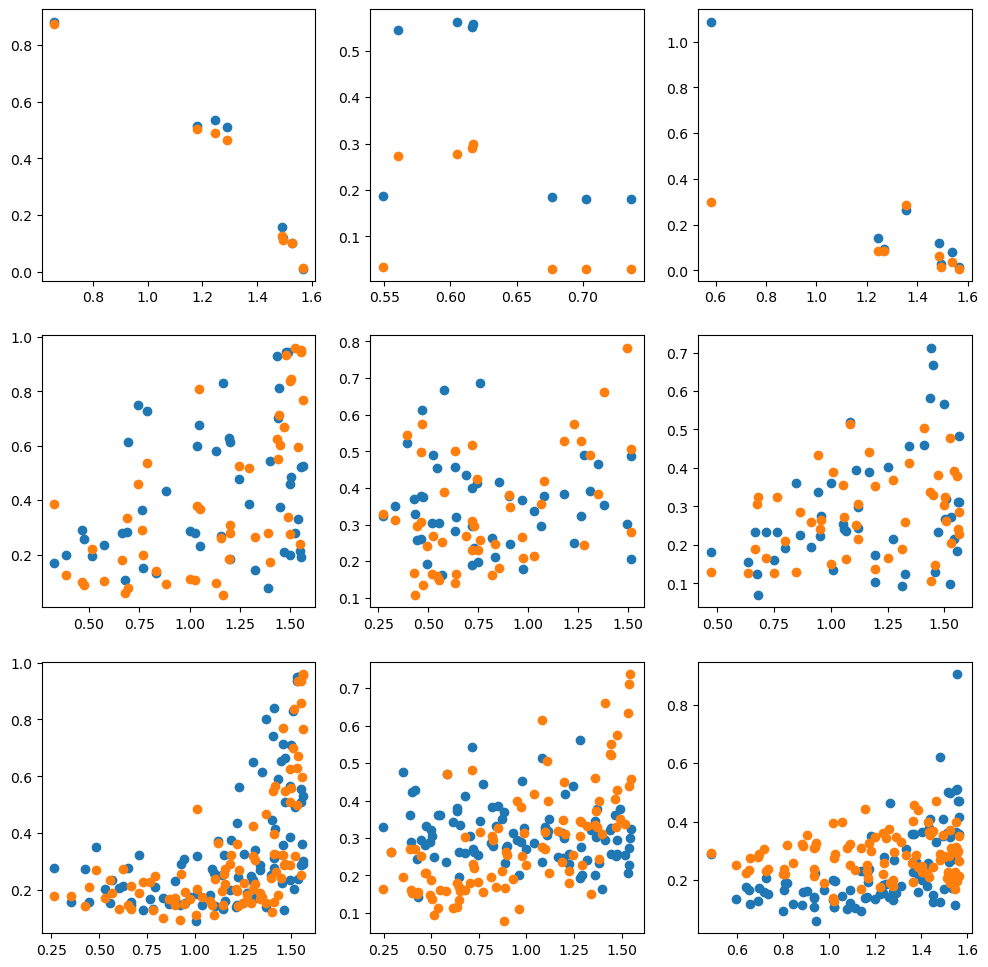

In [308]:
# S1 
dims = np.array([1, 2, 6, 8, 12])
dim_idxs = [0, 2, 4]
fig, ax = plt.subplots(3, 3, figsize=(12, 12))
w = 3
for i in range(3):

# r2_array[0, 3] = np.mean(ss2cc_S1[:, 1, 1, dim_idx, :])
# r2_array[3, 0] = np.mean(ss2cc_S1[:, 0, 1, dim_idx, :])

    # PCA <--> CCA regression vs. subspace angle 
     y1 = [np.mean([ss2cc_S1coef_cascaded[ii, 1, 1, dim_idxs[i], k] for k in range(5)], axis=0)
           for ii in range(ss2cc_S1coef_cascaded.shape[0])]
     Y1 = []
     for y_ in y1:
          if dims[dim_idxs[i]] == 1:
               Y1.append(np.linalg.norm(y_, axis=-1).squeeze())
          else:
               Y1.extend(np.linalg.norm(np.linalg.norm(y_, axis=-1), axis=0).squeeze())

     y2 = [np.mean([ss2cc_S1coef_cascaded[ii, 0, 1, dim_idxs[i], k] for k in range(5)], axis=0)
           for ii in range(ss2cc_S1coef_cascaded.shape[0])]
     Y2 = []
     for y_ in y2:
          if dims[dim_idxs[i]] == 1:
               Y2.append(np.linalg.norm(y_, axis=-1).squeeze())
          else:
               Y2.extend(np.linalg.norm(np.linalg.norm(y_, axis=-1), axis=0).squeeze())

# ss_array[0, 2] = np.mean(ss_anglesS1[:, 0, dim_idx, :])
# ss_array[2, 0] = np.mean(ss_anglesS1[:, 0, dim_idx, :])

     X = []
     for j in range(ss_anglesS1.shape[0]):
          X.extend(np.mean([ss_anglesS1_raw[j, 0, dim_idxs[i], f] for f in range(5)], axis=0))
     ax[i, 0].scatter(X, Y1)
     ax[i, 0].scatter(X, Y2)

# r2_array[1, 2] = np.mean(ss2cc_S1[:, 3, 1, dim_idx, :])
# r2_array[2, 1] = np.mean(ss2cc_S1[:, 2, 1, dim_idx, :])

    # FCA <--> CCA regression vs. subspace angle 
     y1 = [np.mean([ss2cc_S1coef_cascaded[ii, 3, 1, dim_idxs[i], k] for k in range(5)], axis=0)
          for ii in range(ss2cc_S1coef_cascaded.shape[0])]
     Y1 = []
     for y_ in y1:
          if dims[dim_idxs[i]] == 1:
               Y1.append(np.linalg.norm(y_, axis=-1).squeeze())
          else:
               Y1.extend(np.linalg.norm(np.linalg.norm(y_, axis=-1), axis=0).squeeze())

     y2 = [np.mean([ss2cc_S1coef_cascaded[ii, 2, 1, dim_idxs[i], k] for k in range(5)], axis=0)
          for ii in range(ss2cc_S1coef_cascaded.shape[0])]
     Y2 = []
     for y_ in y2:
          if dims[dim_idxs[i]] == 1:
               Y2.append(np.power(np.linalg.norm(y_, axis=-1), 2).squeeze())
          else:
               Y2.extend(np.linalg.norm(np.linalg.norm(y_, axis=-1), axis=0).squeeze())


# ss_array[1, 2] = np.mean(ss_anglesS1[:, 1, dim_idx, :])
# ss_array[2, 1] = np.mean(ss_anglesS1[:, 1, dim_idx, :])

     X = []
     for j in range(ss_anglesS1.shape[0]):
          X.extend(np.mean([ss_anglesS1_raw[j, 1, dim_idxs[i], f] for f in range(5)], axis=0))
     ax[i, 1].scatter(X, Y1)
     ax[i, 1].scatter(X, Y2)

# r2_array[0, 1] = np.mean(ss2cc_S1[:, 5, 1, dim_idx, :])
# r2_array[1, 0] = np.mean(ss2cc_S1[:, 4, 1, dim_idx, :])

    # PCA <--> FCCCA regression vs. subspace angle 
     y1 = [np.mean([ss2cc_S1coef_cascaded[ii, 5, 1, dim_idxs[i], k] for k in range(5)], axis=0)
          for ii in range(ss2cc_S1coef_cascaded.shape[0])]
     Y1 = []
     for y_ in y1:
          if dims[dim_idxs[i]] == 1:
               Y1.append(np.linalg.norm(y_, axis=-1).squeeze())
          else:
               Y1.extend(np.linalg.norm(np.linalg.norm(y_, axis=-1), axis=0).squeeze())

     y2 = [np.mean([ss2cc_S1coef_cascaded[ii, 4, 1, dim_idxs[i], k] for k in range(5)], axis=0)
          for ii in range(ss2cc_S1coef_cascaded.shape[0])]
     Y2 = []
     for y_ in y2:
          if dims[dim_idxs[i]] == 1:
               Y2.append(np.linalg.norm(y_, axis=-1).squeeze())
          else:
               Y2.extend(np.linalg.norm(np.linalg.norm(y_, axis=-1), axis=0).squeeze())


# ss_array[1, 2] = np.mean(ss_anglesS1[:, 2, dim_idx, :])
# ss_array[2, 1] = np.mean(ss_anglesS1[:, 2, dim_idx, :])

     X = []
     for j in range(ss_anglesS1.shape[0]):
          X.extend(np.mean([ss_anglesS1_raw[j, 2, dim_idxs[i], f] for f in range(5)], axis=0))
     ax[i, 2].scatter(X, Y1)
     ax[i, 2].scatter(X, Y2)






In [284]:
# Explicilty verify that the reshaping works!

(1, 1, 3)

In [295]:
np.mean([ss2cc_S1coef[0, 1, 1, 1, k] for k in range(5)], axis=0)#.reshape((2, 2, w), order='F') 

array([[ 5.37136353e-01, -1.33121868e-02,  1.98297314e-01,
        -1.18571292e-02,  4.80605905e-02, -1.46419305e-02],
       [-7.29596989e-02, -8.86308177e-03,  2.32171117e-04,
        -3.31027155e-03,  1.04398781e-02, -2.80551715e-03]])

In [296]:
np.mean([ss2cc_S1coef[0, 1, 1, 1, k] for k in range(5)], axis=0).reshape((2, 2, w), order='F') 

array([[[ 5.37136353e-01,  1.98297314e-01,  4.80605905e-02],
        [-1.33121868e-02, -1.18571292e-02, -1.46419305e-02]],

       [[-7.29596989e-02,  2.32171117e-04,  1.04398781e-02],
        [-8.86308177e-03, -3.31027155e-03, -2.80551715e-03]]])

In [ ]:
# Assemble all possible combinations of interquartile loadings. Then look at the distribution of coefficients in each category

# Assemble loadings
for i, fl in tqdm(enumerate(fls)):
    with open(fl, 'rb') as f:
        _ = pickle.load(f)
        datS1 = pickle.load(f)

    x = datS1['spike_rates'].squeeze()

    # Get the subspaces
    data_file = fl.split('/')[-1].split('.pkl')[0]
    data_file += '.mat'

    for j, dim in enumerate(dims):

        if 'indy' in data_file:
            pcadf = apply_df_filters(indy_S1df, data_file=data_file, dimreduc_method='PCA', dim=dim)
        elif 'loco' in data_file:
            pcadf = apply_df_filters(loco_S1df, data_file=data_file, dimreduc_method='PCA', dim=dim, 
                                     decoder_args={'trainlag':4, 'testlag':4, 'decoding_window':5},
                                     loader_args={'bin_width': 50,
                                                  'filter_fn': 'none',
                                                  'filter_kwargs': {},
                                                  'boxcox': 0.5,
                                                  'spike_threshold': 100,
                                                  'region': 'S1'})

        assert(pcadf.shape[0] == 5)

        if 'indy' in data_file:
            lqgdf = apply_df_filters(indy_S1df, data_file=data_file, dimreduc_method='LQGCA', dim=dim, dimreduc_args={'T':3, 'loss_type':'trace', 'n_init':10})
        elif 'loco' in data_file:
            lqgdf = apply_df_filters(loco_S1df, data_file=data_file, dimreduc_method='LQGCA', dim=dim, 
            dimreduc_args={'T':3, 'loss_type':'trace', 'n_init':10},
            decoder_args={'trainlag':4, 'testlag':4, 'decoding_window':5},
            loader_args={'bin_width': 50,
                        'filter_fn': 'none',
                        'filter_kwargs': {},
                        'boxcox': 0.5,
                        'spike_threshold': 100,
                        'region': 'S1'})

        assert(lqgdf.shape[0] == 5)

        for fold in range(5):
            d1_ = apply_df_filters(pcadf, fold_idx=fold)
            d2_ = apply_df_filters(lqgdf, fold_idx=fold)
            dc_ = apply_df_filters(ccadf2, fold_idx=fold, fl=fl)




### Z-scored activity of S1 neurons and within S1 CCA

In [9]:
# Track 2 quantities: Distribution of peak z-scored activity. Distribution of peak eigenvector activity of Z-scored PCA
good_loco_files = ['loco_20170210_03.mat',
                'loco_20170213_02.mat',
                'loco_20170215_02.mat',
                'loco_20170227_04.mat',
                'loco_20170228_02.mat',
                'loco_20170301_05.mat',
                'loco_20170302_02.mat']

with open('/mnt/Secondary/data/postprocessed/loco_decoding_df.dat', 'rb') as f:
    result_list = pickle.load(f)
with open('/mnt/Secondary/data/postprocessed/indy_S1_df.dat', 'rb') as f:
    rl2 = pickle.load(f)


loco_df = pd.DataFrame(result_list)
indy_df = pd.DataFrame(rl2)
loco_df = apply_df_filters(loco_df, data_file=good_loco_files, decoder_args=loco_df.iloc[0]['decoder_args'])
indy_df = apply_df_filters(indy_df, decoder_args=indy_df.iloc[0]['decoder_args'])
sabes_df = pd.concat([loco_df, indy_df])

/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LinearRegression from version 0.24.2 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [50]:
data_file

'/mnt/Secondary/data/sabes/indy_20160426_01.mat'

In [10]:
from sklearn.preprocessing import StandardScaler

In [55]:
data_files = np.unique(sabes_df['data_file'].values)
PK_su = []
PK_eig = []
for i, data_file in enumerate(data_files):
    dat = load_sabes('/mnt/Secondary/data/sabes/%s' % data_file, region='S1')
    dat = reach_segment_sabes(dat, data_file=data_file.split('.mat')[0])

    # First, fit the z-scored activity of neurons across reaches
    X = np.squeeze(dat['spike_rates'])
    X = StandardScaler().fit_transform(X)
    Xtrans = pcamodel = PCA().fit_transform(X)

    # Now, fit the z-scored activity of neurons across reaches, but only using the first 3 PCs
    transition_times = np.array(dat['transition_times']) 
    pk_su = np.zeros((transition_times.shape[0], X.shape[1]))
    pk_eig = np.zeros((transition_times.shape[0], X.shape[1]))
    for j, tt in enumerate(transition_times):
        x = X[tt[0]:tt[1], :]
        pk_su[j, :] = np.argmax(x, axis=0)
        pk_eig[j, :] = np.argmax(Xtrans[tt[0]:tt[1], :], axis=0)
        
    PK_su.append(pk_su)
    PK_eig.append(pk_eig)        

96
Reminder that start times depend on the bin size


/home/akumar/nse/neural_control/segmentation.py:68: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


96
Reminder that start times depend on the bin size


/home/akumar/nse/neural_control/segmentation.py:68: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


96
Reminder that start times depend on the bin size


/home/akumar/nse/neural_control/segmentation.py:68: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


96
Reminder that start times depend on the bin size


/home/akumar/nse/neural_control/segmentation.py:68: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


96
Reminder that start times depend on the bin size


/home/akumar/nse/neural_control/segmentation.py:68: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


96
Reminder that start times depend on the bin size


/home/akumar/nse/neural_control/segmentation.py:68: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


96
Reminder that start times depend on the bin size


/home/akumar/nse/neural_control/segmentation.py:68: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


96
Reminder that start times depend on the bin size


/home/akumar/nse/neural_control/segmentation.py:68: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


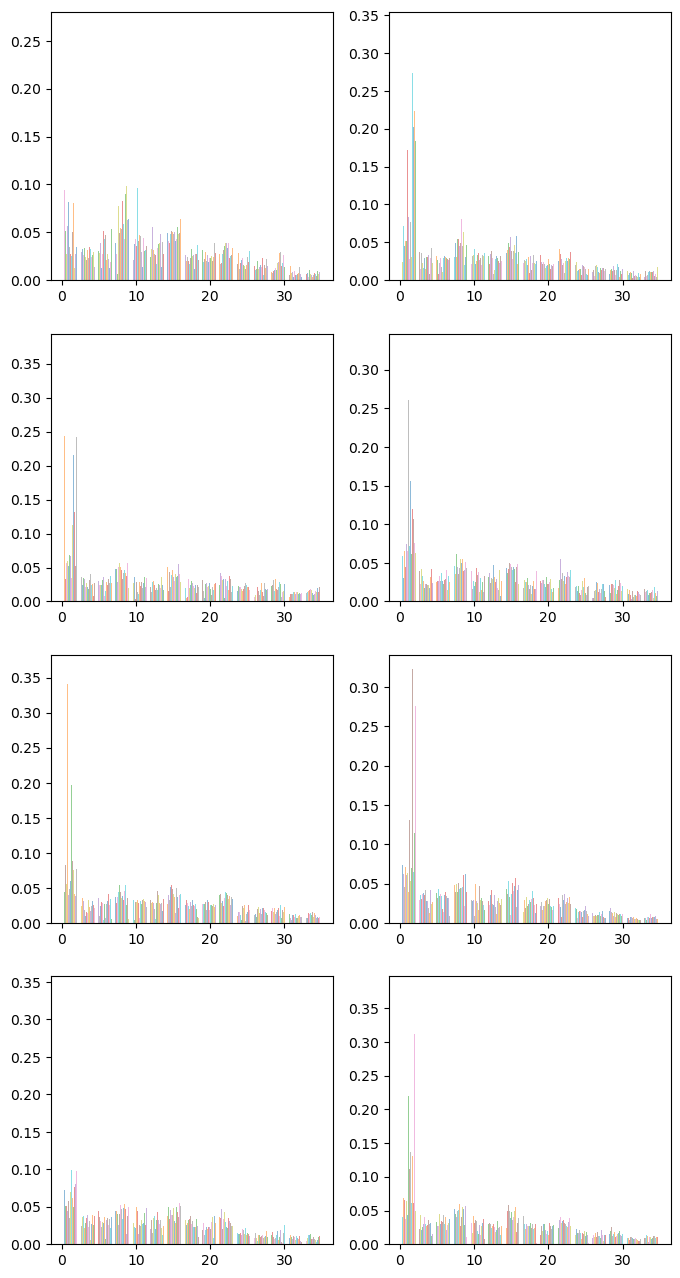

In [62]:
fig, ax = plt.subplots(4, 2, figsize=(8, 16))
for i, data_file in enumerate(data_files):
    a = ax[np.unravel_index(i, (4, 2))]
    a.hist(PK_su[i], bins=15, range=(0, 35), alpha=0.5, label='SU', density=True)

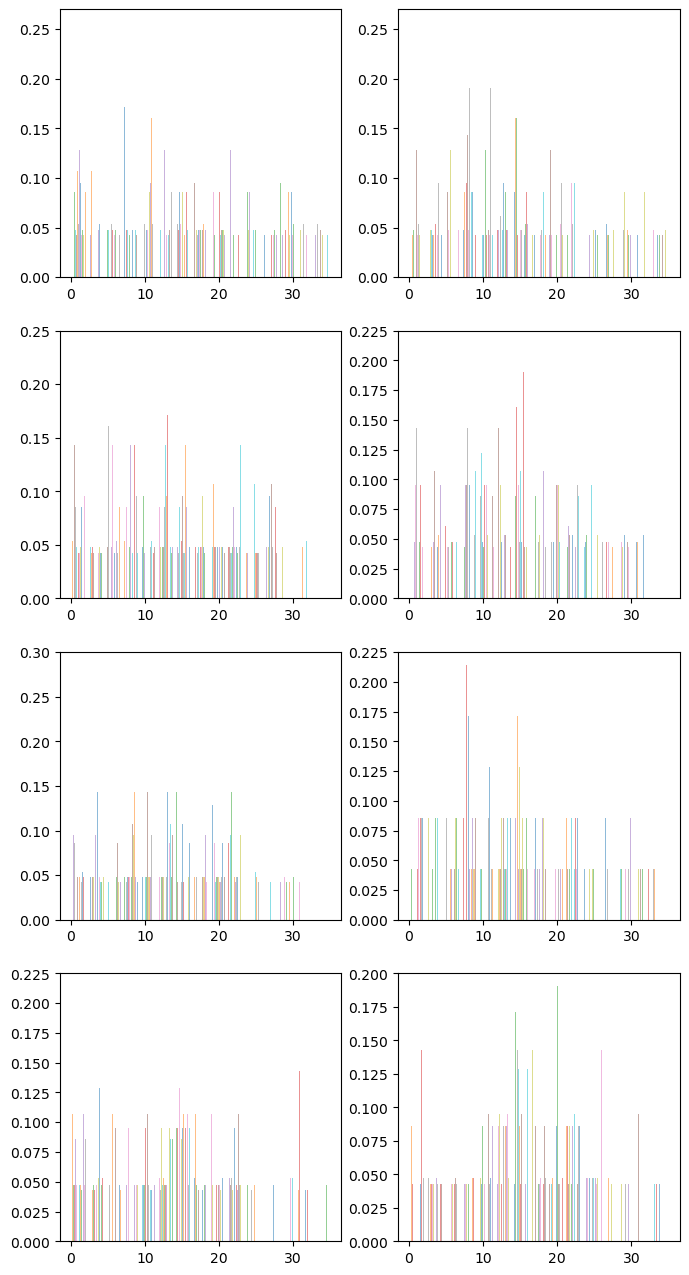

In [61]:
fig, ax = plt.subplots(4, 2, figsize=(8, 16))
for i, data_file in enumerate(data_files):
    a = ax[np.unravel_index(i, (4, 2))]
    a.hist(PK_eig[i][0:10], bins=15, range=(0, 35), alpha=0.5, label='SU', density=True)

In [ ]:
# Can we quantify this with a cross-correlation analysis of the Z-scored activity in the Z-scored PCA eigenvectors and then the S1 -> behavior or S1-> M1 decoding trace?

In [11]:
data_file = '/mnt/Secondary/data/sabes/indy_20160426_01.mat'
dat = load_sabes(data_file)
dat = reach_segment_sabes(dat, data_file=data_file.split('/')[-1].split('.mat')[0])

fls = glob.glob('/home/akumar/nse/neural_control/data/s1m1regvt_allpairsd4w2/*.dat')
rl = []

for fl in fls:

    didx = int(fl.split('didx')[1].split('_')[0])
    # dim = int(fl.split('dim')[1].split('_')[0])
    s = fl.split('_')[3:]

    # filter_params = {}
    # filter_params['error_thresh'] = float(s[7])/100
    # filter_params['error_op'] = s[-2]
    # filter_params['filter_type'] = int(s[1])
    # filter_params['op'] = s[3]
    # filter_params['q'] = float(s[5])/100

    measure_from_end = bool(int(s[-1].split('.dat')[0]))

    with open(fl, 'rb') as f:
        wr2_S1 = pickle.load(f) 
        wr2_M1 = pickle.load(f)
        wr2_M1S1 = pickle.load(f)
        wr2_S1M1 = pickle.load(f)
        error_filter = pickle.load(f)
        reach_filter = pickle.load(f)
        window_filter = pickle.load(f)
        windows = pickle.load(f)
        filter_params = pickle.load(f)

    result = {}
    result['r2_S1'] = wr2_S1
    result['r2_M1'] = wr2_M1
    result['r2_M1S1'] = wr2_M1S1
    result['r2_S1M1'] = wr2_S1M1

    result['error_filter'] = error_filter
    result['window_filter'] = window_filter
    result['window'] = np.squeeze(windows)
    result['reach_filter'] = reach_filter
    result['didx'] = didx
    result['dim'] = 6
    result['measure_from_end'] = measure_from_end

    for k, v in filter_params.items():
        result[k] = v
    
    rl.append(result)
dvt_df = pd.DataFrame(rl)

Reminder that start times depend on the bin size


/home/akumar/nse/neural_control/segmentation.py:68: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


In [12]:
rdict = {'rS1M1': {}, 'rM1S1': {}, 'rS1': {}, 'rM1': {}}
features = {'rS1M1': ['xcca', 'xpca', 'xfcca'], 'rM1S1': ['ycca', 'ypca', 'yfcca'], 'rS1': ['xcca', 'xpca', 'xfcca'], 'rM1': ['ycca', 'ypca', 'yfcca']}
targets = {'rS1M1': ['ycca', 'ypca', 'yfcca'], 'rM1S1': ['xcca', 'xpca', 'xfcca'], 'rS1': ['xcca', 'xpca', 'xfcca'], 'rM1': ['ycca', 'ypca', 'yfcca']}


# S1 -> M1
for k, v in features.items():
    for f in v:
        for t in targets[k]:
            rdict[k]['r2_%s_%s' % (f, t)] = []

for data_idx in np.unique(df_['didx'].values):
    d = apply_df_filters(df_, didx=data_idx)

    for ke in rdict.keys():
        r = {}
        for f in features[ke]:
            for t in targets[ke]:
                r['r2_%s_%s' % (f, t)] = []

        wc = []
        for k in range(d.shape[0]):
            win = d.iloc[k]['window']
            if win.ndim == 1:
                wc.extend([np.mean(win)])
            else:
                wc.extend(np.mean(win, axis=1))

            idx = 0
            for i, f in enumerate(features[ke]):
                for j, t in enumerate(targets[ke]):
                    if f == t:
                        continue
                    r['r2_%s_%s' % (f, t)].extend(np.nanmean(d.iloc[k]['_'.join(['r2', 'r2S1M1'.split('r2')[1]])][:, :, idx+1, 0], axis=1))
                    idx += 2
                    
        win_order = np.argsort(wc)
        for k, v in r.items():
            f = k.split('_')[1]
            t = k.split('_')[2]
            if f == t:
                continue
            r[k] = np.array(v)[win_order]

        for f in features[ke]:
            for t in targets[ke]:
                rdict[ke]['r2_%s_%s' % (f, t)].append(r['r2_%s_%s' % (f, t)])

for k, v in features.items():
    for f in v:
        for t in targets[k]:
            rdict[k]['r2_%s_%s' % (f, t)] = np.array(rdict[k]['r2_%s_%s' % (f, t)]).T      


In [13]:
fls = ['loco_20170210_03.mat',
 'loco_20170213_02.mat',
 'loco_20170215_02.mat',
 'loco_20170227_04.mat',
 'loco_20170228_02.mat',
 'loco_20170301_05.mat',
 'loco_20170302_02.mat',
 'indy_20160426_01.mat']

In [14]:
rdict.keys()

dict_keys(['rS1M1', 'rM1S1', 'rS1', 'rM1'])

In [15]:
rdict['rS1M1']['r2_xcca_ycca'].shape

(30, 8)

In [31]:
# What in the

s1peig_cc = []
s1pzeig_cc = []

Xseg = []
Xzseg = []

for i, data_file in enumerate(fls):
    dat = load_sabes('/mnt/Secondary/data/sabes/%s' % data_file, region='S1')
    dat = reach_segment_sabes(dat, data_file=data_file.split('.mat')[0])

    # First, fit the z-scored activity of neurons across reaches
    X = np.squeeze(dat['spike_rates'])
    Xz = StandardScaler().fit_transform(X)
    Xtrans = PCA().fit_transform(X)
    Xztrans = PCA().fit_transform(Xz)

    # Now, fit the z-scored activity of neurons across reaches, but only using the first 3 PCs
    transition_times = np.array(dat['transition_times']) 
    # Filter transition times by those considered in the decoding v t.
    d = apply_df_filters(dvt_df, didx=i)
    error_filter = d.iloc[0]['error_filter']
    reach_filter = d.iloc[0]['reach_filter']
    window_filter = d.iloc[0]['window_filter']
    transition_times = transition_times[error_filter]
    transition_times = transition_times[window_filter]    


    # Keeping in mind the lag of bin 1

    xseg = []
    xzseg = []

    for j, tt in enumerate(transition_times):

        x = X[tt[0] - 1:tt[0] + 30 -1, :]
        xz = Xz[tt[0] - 1:tt[0] + 30 -1, :]
        xseg.append(x)
        xzseg.append(xz)

    xseg = np.mean(np.array(xseg), axis=0)
    xzseg = np.mean(np.array(xzseg), axis=0)

    Xseg.append(xseg[:, 0:6])
    Xzseg.append(xzseg[:, 0:6])

    # Average across reaches
    # Cross-correlate with the S1 CC -> M1 CC decoding
    r = rdict['rS1M1']['r2_xcca_ycca'][:, i]
    s1peig_cc.append(np.corrcoef(xseg[:, 0:6], r[:, np.newaxis], rowvar=False))    
    s1pzeig_cc.append(np.corrcoef(xzseg[:, 0:6], r[:, np.newaxis], rowvar=False))

96
Reminder that start times depend on the bin size


/home/akumar/nse/neural_control/segmentation.py:68: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


96
Reminder that start times depend on the bin size


/home/akumar/nse/neural_control/segmentation.py:68: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


96
Reminder that start times depend on the bin size


/home/akumar/nse/neural_control/segmentation.py:68: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


96
Reminder that start times depend on the bin size


/home/akumar/nse/neural_control/segmentation.py:68: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


96
Reminder that start times depend on the bin size


/home/akumar/nse/neural_control/segmentation.py:68: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


96
Reminder that start times depend on the bin size


/home/akumar/nse/neural_control/segmentation.py:68: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


96
Reminder that start times depend on the bin size


/home/akumar/nse/neural_control/segmentation.py:68: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


96
Reminder that start times depend on the bin size


/home/akumar/nse/neural_control/segmentation.py:68: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


In [35]:
s1peig_cc[0][:, -1]

array([ 0.29093608,  0.85490448,  0.52098706, -0.19086805,  0.8147165 ,
       -0.53583776,  1.        ])

In [36]:
Xzseg[0].shape

(30, 6)

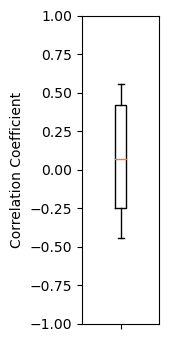

In [45]:
# What is the average correlation between the first 3 PCs of the S1 activity and the S1 -> M1 CC decoding?
fig, ax = plt.subplots(1, 1, figsize=(1, 4))
ax.boxplot([np.mean(s[0:3, -1], axis=0) for s in s1peig_cc])
ax.set_xticklabels([])
ax.set_ylabel('Correlation Coefficient')
ax.set_ylim([-1, 1])
fig.savefig('/home/akumar/nse/neural_control/figs/loco_indy_merge/s1pcs1ccdecoding_correlation.pdf', bbox_inches='tight')

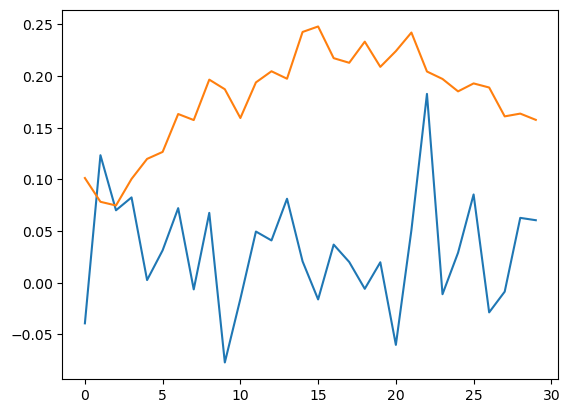

In [40]:
# For particular entries of this matrix that have high correlation, can we plot traces and assess this
plt.plot(Xseg[0][:, 3])
plt.plot(rdict['rS1M1']['r2_xcca_ycca'][:, 0])

### Straight vs. corrective breakdown

In [17]:
fls = glob.glob('/home/akumar/nse/neural_control/data/s1m1regvt_allpairs_strvcorr/*.dat')
rl = []

for fl in fls:

    didx = int(fl.split('didx')[1].split('_')[0])
    # dim = int(fl.split('dim')[1].split('_')[0])
    s = fl.split('_')[3:]

    # filter_params = {}
    # filter_params['error_thresh'] = float(s[7])/100
    # filter_params['error_op'] = s[-2]
    # filter_params['filter_type'] = int(s[1])
    # filter_params['op'] = s[3]
    # filter_params['q'] = float(s[5])/100

    with open(fl, 'rb') as f:
        wr2_S1 = pickle.load(f) 
        wr2_M1 = pickle.load(f)
        wr2_M1S1 = pickle.load(f)
        wr2_S1M1 = pickle.load(f)
        windows = pickle.load(f)
        straight_reaches = pickle.load(f)
        corrective_reaches = pickle.load(f)
        full_straight_reaches_train = pickle.load(f)
        full_straight_reaches_test = pickle.load(f)
        full_corrective_reaches_train = pickle.load(f)
        full_corrective_reaches_test = pickle.load(f)
        behavioral_metrics_array = pickle.load(f)

    result = {}
    result['r2_S1'] = wr2_S1
    result['r2_M1'] = wr2_M1
    result['r2_M1S1'] = wr2_M1S1
    result['r2_S1M1'] = wr2_S1M1

    result['window'] = np.squeeze(windows)
    result['didx'] = didx
    result['dim'] = 2

    result['full_straight_train'] = full_straight_reaches_train
    result['full_straight_test'] = full_straight_reaches_test
    result['full_corrective_train'] = full_corrective_reaches_train
    result['full_corrective_test'] = full_corrective_reaches_test
    result['behavioral_metrics'] = behavioral_metrics_array

    result['straight'] = straight_reaches
    result['corrective'] = corrective_reaches

    rl.append(result)
dvt_df = pd.DataFrame(rl)

In [18]:
# Time-resolved decoding of FCCA/PCA subspaces
#df_ = apply_df_filters(dvt_df, error_thresh=1, error_op='le', filter_type=0, q=0, op='le', dim=6)
df_ = dvt_df
data_idxs = np.unique(df_['didx'].values)

In [19]:
import numpy.ma as ma

In [20]:
# Assemble acceleration/velcocity of reaches across all recording sessions
vel_all = []
acc_all = []
ntr = []
fls = ['loco_20170210_03.mat',
 'loco_20170213_02.mat',
 'loco_20170215_02.mat',
 'loco_20170227_04.mat',
 'loco_20170228_02.mat',
 'loco_20170301_05.mat',
 'loco_20170302_02.mat',
 'indy_20160426_01.mat']

# Straight reach profiles
vel_all = []
acc_all = []
vel_pk = []

# Correction reach profiles
vel_allc = []
acc_allc = []
vel_pkc = []


for data_idx, fl in tqdm(enumerate(fls)):

    dat = load_sabes('/mnt/Secondary/data/sabes/%s' % fl)
    dat = reach_segment_sabes(dat, data_file=fl.split('/')[-1].split('.mat')[0])

    d = apply_df_filters(df_, didx=data_idx)

    # Intersection

    X = dat['spike_rates'].squeeze()
    Z = dat['behavior']

    Z, X = expand_state_space([Z], [X], True, True)
    X = X[0]
    Z = Z[0]


    # Shift all transition times by 2
    transition_times = np.array([(t[0] - 2, t[1] - 2) for t in dat['transition_times']])

    vel_all.append([])
    acc_all.append([])
    vel_pk.append([])

    try:
        assert(d.shape[0] == 8)
    except:
        pdb.set_trace()

    straight_reaches = []
    correction_reaches = []
    for k in range(8):
        # This will have a length of 5 * n_windows + n_windows prior to debugging fix
        full_straight_train = [d.iloc[k]['full_straight_train'][i, 0] for i in range(d.iloc[k]['full_straight_train'].shape[0])]
        fstr = set(full_straight_train[0])
        for i in range(1, len(full_straight_train)):
            fstr = fstr.intersection(full_straight_train[i])

        full_straight_test = [d.iloc[k]['full_straight_test'][i, 0] for i in range(d.iloc[k]['full_straight_test'].shape[0])]
        fste = set(full_straight_test[0])
        for i in range(1, len(full_straight_test)):
            fste = fste.intersection(full_straight_test[i])
        
        full_straight = fstr.union(fste) 

        straight_reaches.append(full_straight)

        # Do the same for corrective reaches
        full_corrective_train = [d.iloc[k]['full_corrective_train'][i, 0] for i in range(d.iloc[k]['full_corrective_train'].shape[0])]
        fctr = set(full_corrective_train[0])
        for i in range(1, len(full_corrective_train)):
            fctr = fctr.intersection(full_corrective_train[i])
        full_corrective_test = [d.iloc[k]['full_corrective_test'][i, 0] for i in range(d.iloc[k]['full_corrective_test'].shape[0])]

        fcte = set(full_corrective_test[0])
        for i in range(1, len(full_corrective_test)):
            fcte = fcte.intersection(full_corrective_test[i])
        
        full_corrective = fctr.union(fcte)
        correction_reaches.append(full_corrective)

    # Intersect over non empty sets
    straight_set = set(d.iloc[0]['straight'])
    for s in straight_reaches:
        if len(s) > 0:
            straight_set = straight_set.intersection(s)

    correction_set = set(d.iloc[0]['corrective'])
    for s in correction_reaches:
        if len(s) > 0:
            corection_set = correction_set.intersection(s)
    
    for tt in transition_times[list(straight_set)]:
    
        # Exclude things that are right at the end
        if tt[0] + 35 > Z.shape[0]:
            continue

        # Mask anything that extends into the subsequent reach. Since we intersected over non-zero sets, there will
        # still be some overlap here
        vel = ma.array(np.linalg.norm(Z[tt[0]:tt[0] + 35, 2:4], axis=1)/(1e3 * 0.05))
        acc = ma.array(np.linalg.norm(Z[tt[0]:tt[0] + 35, 4:6], axis=1)/(1e3 * 0.05 * 0.05))

        next_reach_idxs = np.arange(35)[np.arange(tt[0], tt[0] + 35) > tt[1]]
        vel[next_reach_idxs] = ma.masked
        acc[next_reach_idxs] = ma.masked

        vel_all[data_idx].append(vel)
        acc_all[data_idx].append(acc)

        # Find the peak of velocity, and the rising and falling shoulder of the acceleration
        vpk = ma.argmax(vel)
        vel_pk[data_idx].append(vpk)

    vel_allc.append([])
    acc_allc.append([])
    vel_pkc.append([])

    for tt in transition_times[list(correction_set)]:
        # Exclude things that are right at the end
        if tt[0] + 35 > Z.shape[0]:
            continue

        vel = ma.array(np.linalg.norm(Z[tt[0]:tt[0] + 35, 2:4], axis=1)/(1e3 * 0.05))
        acc = ma.array(np.linalg.norm(Z[tt[0]:tt[0] + 35, 4:6], axis=1)/(1e3 * 0.05 * 0.05))

        next_reach_idxs = np.arange(35)[np.arange(tt[0], tt[0] + 35) > tt[1]]
        vel[next_reach_idxs] = ma.masked
        acc[next_reach_idxs] = ma.masked
                
        vel_allc[data_idx].append(vel)
        acc_allc[data_idx].append(acc)

        # Find the peak of velocity, and the rising and falling shoulder of the acceleration
        vpk = ma.argmax(vel)
        vel_pkc[data_idx].append(vpk)



0it [00:00, ?it/s]/home/akumar/nse/neural_control/segmentation.py:68: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]
1it [00:11, 11.25s/it]

Reminder that start times depend on the bin size
Reminder that start times depend on the bin size


3it [00:33, 10.71s/it]

Reminder that start times depend on the bin size
Reminder that start times depend on the bin size


5it [00:58, 11.73s/it]

Reminder that start times depend on the bin size


6it [01:06, 10.38s/it]

Reminder that start times depend on the bin size


7it [01:21, 11.92s/it]

Reminder that start times depend on the bin size
Reminder that start times depend on the bin size


8it [01:33, 11.69s/it]


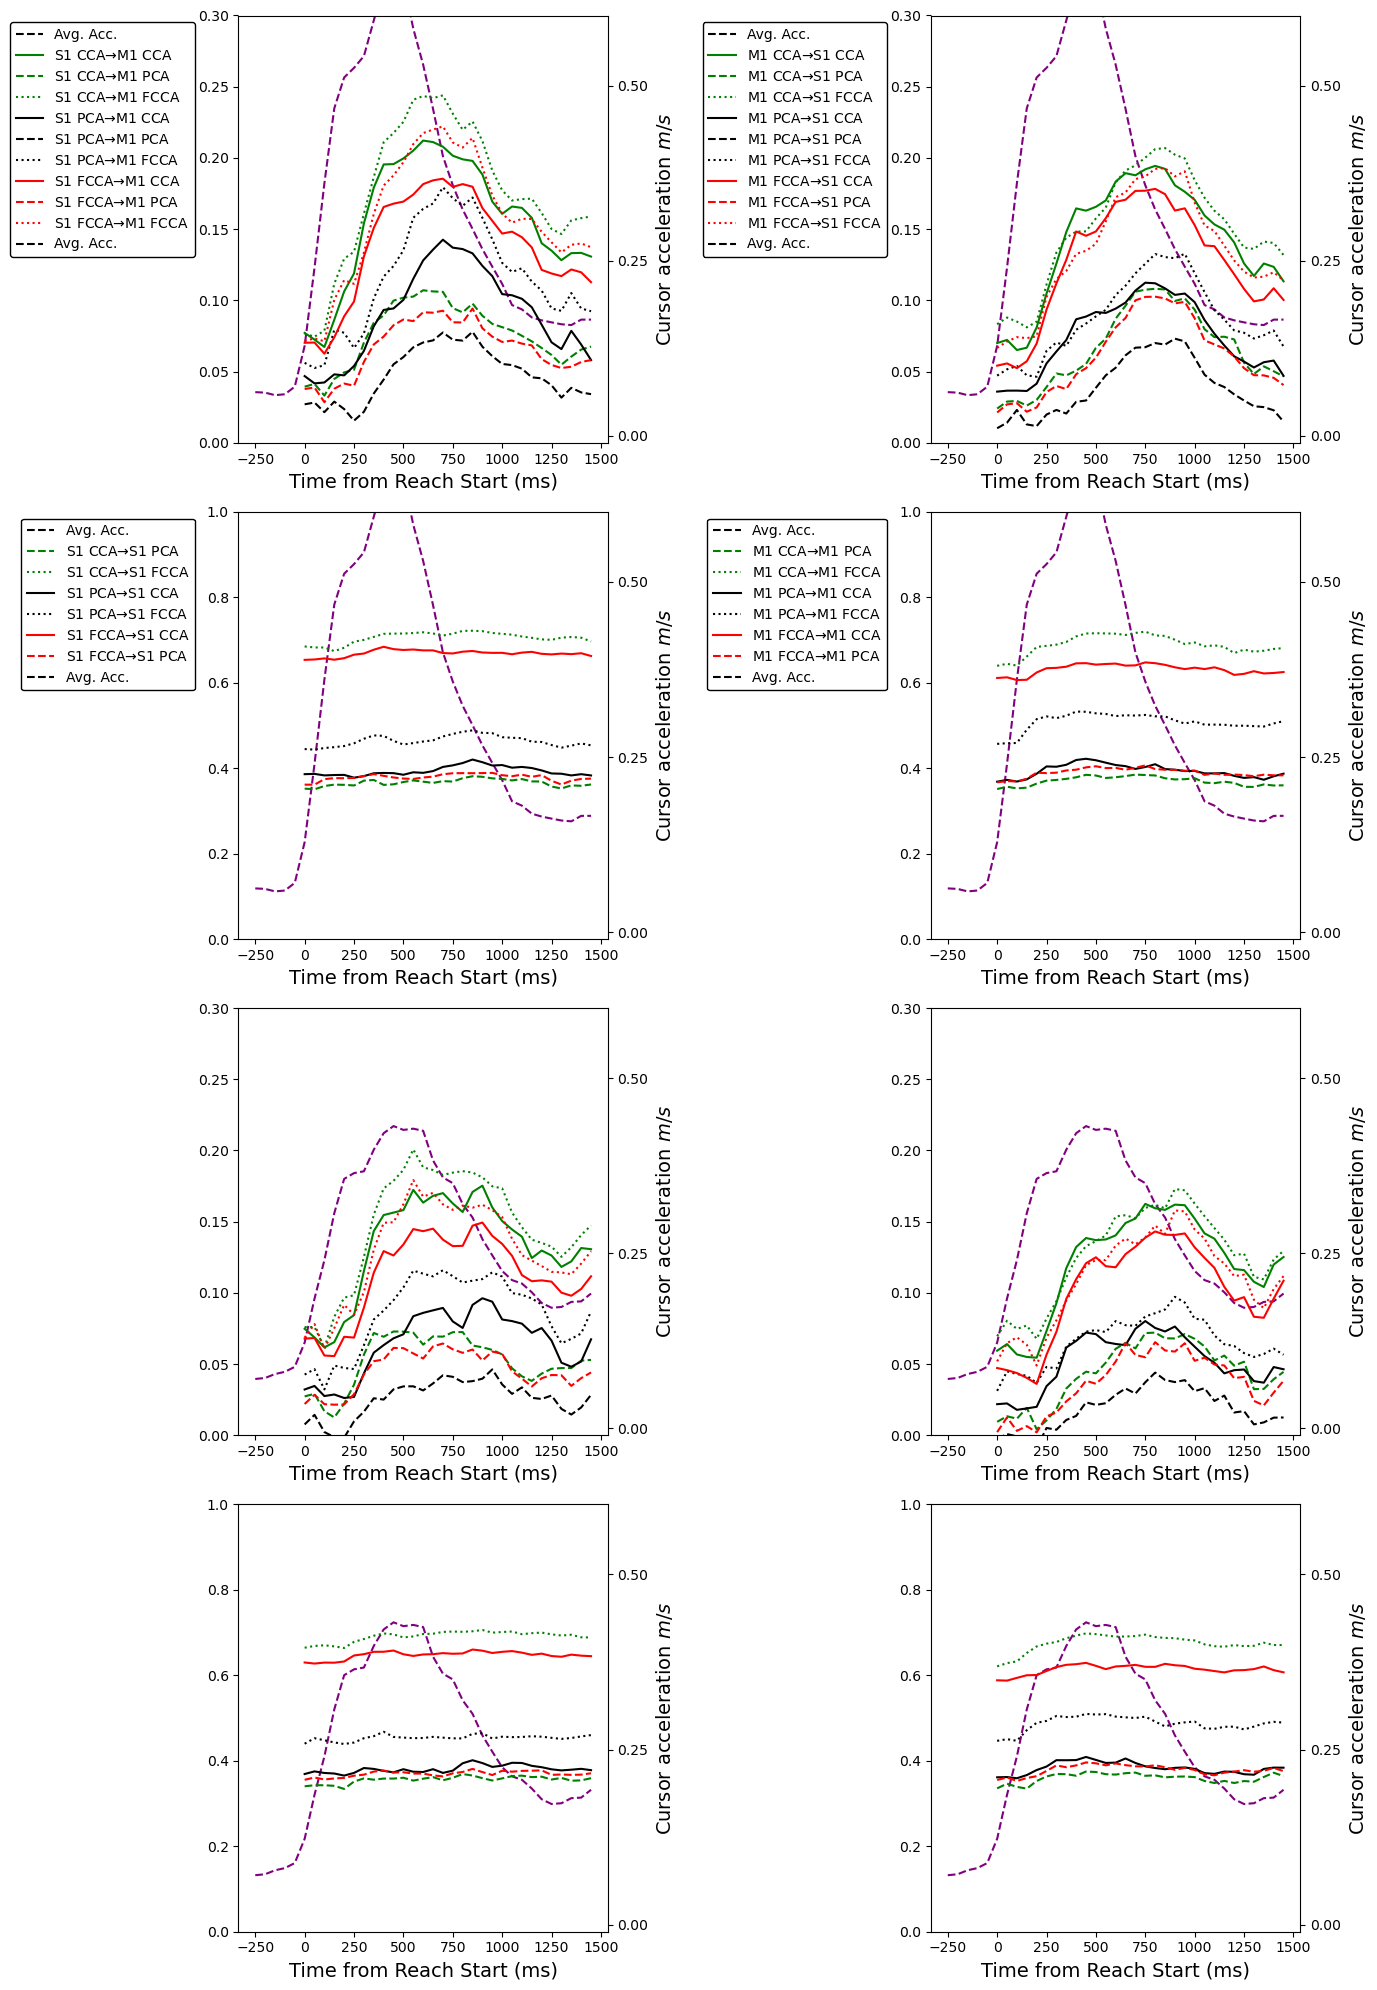

In [36]:
#fig, ax = plt.subplots(1, 3, figsize=(12, 4))
fig, ax = plt.subplots(4, 2, figsize=(14, 20))

#windows = dvt_df.iloc[0]['window']
#window_centers = np.linspace(0, 35, 15)[0:9]

DIM = 4
ntr = np.array(ntr)
# Dense windows
window_centers = np.arange(30)
#df_ = apply_df_filters(dvt_df, error_thresh=1, error_op='le', filter_type=0, q=0, op='le', dim=DIM)
df_ = dvt_df

a = []
for i in range(2):
    for j in range(2):  
        a.append(ax[i, j].twinx())

# Filter transition times by those that survived all windows ()
d = apply_df_filters(df_, didx=7)
# error_filter = d.iloc[0]['error_filter']
# reach_filter = d.iloc[0]['reach_filter']
# window_filter = d.iloc[0]['window_filter']

for a_ in a:
    a_.set_ylabel('Cursor acceleration ' r'$m/s$', fontsize=14)

# Flatten
velall = np.array([elem for v in vel_all for elem in v])
ntr = np.array([len(v) for v in vel_all])
aall = [elem for ac in acc_all for elem in ac]
velall = np.array(velall)
accall = np.array(aall)
# Use fill between to plot the confidence bands
#a.fill_between(50 * np.arange(-5, 23), np.mean(acc_all, axis=0) - np.std(acc_all, axis=0), np.mean(acc_all, axis=0) + np.std(acc_all, axis=0), color='k', alpha=0.1)

for a_ in a:
    a_.plot(50 * np.arange(-5, 30), np.mean(accall, axis=0), linestyle='--', color='purple')

# Dummy for legend
for i in range(2):
    for j in range(2):
        ax[i, j].plot(np.nan, linestyle='--', color='k', label='Avg. Acc.') 
#ax.plot(np.nan, linestyle='--', color='k', label='Avg. Vel.') 

# Segment in the same way as in the .py file to allow for comparison

rdict = {'rS1M1': {}, 'rM1S1': {}, 'rS1': {}, 'rM1': {}}
features = {'rS1M1': ['xcca', 'xpca', 'xfcca'], 'rM1S1': ['ycca', 'ypca', 'yfcca'], 'rS1': ['xcca', 'xpca', 'xfcca'], 'rM1': ['ycca', 'ypca', 'yfcca']}
targets = {'rS1M1': ['ycca', 'ypca', 'yfcca'], 'rM1S1': ['xcca', 'xpca', 'xfcca'], 'rS1': ['xcca', 'xpca', 'xfcca'], 'rM1': ['ycca', 'ypca', 'yfcca']}

legend_map = {'xcca':'S1 CCA', 'xpca': 'S1 PCA', 'xfcca': 'S1 FCCA', 'ycca': 'M1 CCA', 'ypca': 'M1 PCA', 'yfcca': 'M1 FCCA'}


# S1 -> M1
for k, v in features.items():
    for f in v:
        for t in targets[k]:
            rdict[k]['r2_%s_%s' % (f, t)] = []

for data_idx in np.unique(df_['didx'].values):
    d = apply_df_filters(df_, didx=data_idx)

    for ke in rdict.keys():
        r = {}
        for f in features[ke]:
            for t in targets[ke]:
                r['r2_%s_%s' % (f, t)] = []

        wc = []
        for k in range(d.shape[0]):
            win = d.iloc[k]['window']
            if win.ndim == 1:
                wc.extend([np.mean(win)])
            else:
                wc.extend(np.mean(win, axis=1))

            idx = 0
            for i, f in enumerate(features[ke]):
                for j, t in enumerate(targets[ke]):
                    if f == t:
                        continue
                    r['r2_%s_%s' % (f, t)].extend(np.nanmean(d.iloc[k]['_'.join(['r2', ke.split('r')[1]])][:, :, idx+1, 0, 0], axis=1))
                    idx += 2
                    
        win_order = np.argsort(wc)
        for k, v in r.items():
            f = k.split('_')[1]
            t = k.split('_')[2]
            if f == t:
                continue
            r[k] = np.array(v)[win_order]

        for f in features[ke]:
            for t in targets[ke]:
                rdict[ke]['r2_%s_%s' % (f, t)].append(r['r2_%s_%s' % (f, t)])

for k, v in features.items():
    for f in v:
        for t in targets[k]:
            rdict[k]['r2_%s_%s' % (f, t)] = np.array(rdict[k]['r2_%s_%s' % (f, t)]).T      


def plot_trace(r2, col, linestyle, label, axis):
    # axis.fill_between(50 * window_centers, np.array([np.sum(np.multiply(r, ntr))/np.sum(ntr) for r in r2]) - np.array([np.sqrt(np.var(r) * np.sum(ntr**2)/np.sum(ntr)**2) for r in r2]), 
    #                 np.array([np.sum(np.multiply(r, ntr))/np.sum(ntr) for r in r2]) + np.array([np.sqrt(np.var(r) * np.sum(ntr**2)/np.sum(ntr)**2) for r in r2]),
    #                 color=col, alpha=0.25, zorder=100)

    axis.plot(50 * window_centers, [np.sum(np.multiply(r, ntr))/np.sum(ntr) for r in r2], '-', color=col, label=label, linestyle=linestyle)

colors = ['g', 'g', 'g', 'k', 'k', 'k', 'r', 'r', 'r']
ls = ['-', '--', ':', '-', '--', ':', '-', '--', ':']

for i, (key, value) in enumerate(rdict['rS1M1'].items()):
    label = legend_map[key.split('_')[1]] + r'$\to$' + legend_map[key.split('_')[2]]
    plot_trace(value, colors[i], ls[i], label, ax[0, 0])

for i, (key, value) in enumerate(rdict['rM1S1'].items()):
    label = legend_map[key.split('_')[1]] + r'$\to$' + legend_map[key.split('_')[2]]
    plot_trace(value, colors[i], ls[i], label, ax[0, 1])

colors = ['g', 'g', 'k', 'k', 'r', 'r']
ls = ['--', ':', '-', ':', '-', '--']

idx = 0
for i, (key, value) in enumerate(rdict['rS1'].items()):
    s1 = key.split('_')[1]
    s2 = key.split('_')[2]
    if s1 == s2:
        continue

    label = legend_map[key.split('_')[1]] + r'$\to$' + legend_map[key.split('_')[2]]
    plot_trace(value, colors[idx], ls[idx], label, ax[1, 0])
    idx += 1

colors = ['g', 'g', 'k', 'k', 'r', 'r']
ls = ['--', ':', '-', ':', '-', '--']
idx = 0
for i, (key, value) in enumerate(rdict['rM1'].items()):
    s1 = key.split('_')[1]
    s2 = key.split('_')[2]
    if s1 == s2:
        continue
    
    label = legend_map[key.split('_')[1]] + r'$\to$' + legend_map[key.split('_')[2]]
    plot_trace(value, colors[idx], ls[idx], label, ax[1, 1])
    idx += 1
# plot_trace(r2_M1CtoPCA, 'k', 'M1CC' + r'$\to$' + ' PCA')
# plot_trace(r2_M1CtoFCA, 'r', 'M1CC' + r'$\to$' + ' FCCA')
# plot_trace(r2_S1toM1C, 'g', 'S1CC' + r'$\to$' + ' M1CC')
#plot_trace(r2f - r2p, 'g', r'$\Delta$' + ' FCCA/PCA decoding')

for a_ in a:
    a_.set_ylim([-0.01, 0.6])  
    a_.set_yticks([0., 0.25, 0.5])
    a_.set_frame_on(True) # make sure there is any background

#ax.set_xlim([0, 950])
#ax.set_ylabel('Prediction ' + r'$r^2$', fontsize=14)
#ax.set_xlabel('Time from Reach Start (ms)', fontsize=14)
#ax.set_title('Projection Dimension %d' % DIM, fontsize=14)
for i in range(2):
    for j in range(2):
        lg = ax[i, j].legend(fontsize=10, ncol=1, frameon=True,  edgecolor=(0, 0, 0, 1.), bbox_to_anchor=(-0.1, 1.0))
        lg.get_frame().set_alpha(1.)

        ax[i, j].set_zorder(1) # make it on top
        ax[i, j].set_frame_on(False) # make it transparent
        ax[i, j].set_xlabel('Time from Reach Start (ms)', fontsize=14)

        if i == 0:
            ax[i, j].set_ylim([0, 0.3])
        else:
            ax[i, j].set_ylim([0, 1.0])

# ax.vlines(50 * np.arange(-5, 25)[np.argmax(np.mean(accall, axis=0))], 0, 0.725, linestyles='dotted', color='#535454', alpha=0.75)

# Find the local peak time of the green trace
# trace = np.array([np.sum(np.multiply(r, ntr))/np.sum(ntr) for r in r2_S1toM1C])
# pk = scipy.signal.find_peaks(trace)

# ax.vlines(50 * np.arange(20)[pk[0][1]], 0, 0.725, linestyles='dashed', color='g', alpha=0.75)

# lg1 = ax[1].legend(loc='lower right', fontsize=10, bbox_to_anchor=(0.14, -0.015, 0.25, 0.25), frameon=True, edgecolor=(0, 0, 0, 1.), facecolor=(1, 1, 1, 1.))
# lg2 = ax[2].legend(loc='lower left', fontsize=10, frameon=True, edgecolor=(0, 0, 0, 1.), facecolor=(1, 1, 1, 1.))

####################################################### COrrective
a = []
for i in range(2):
    for j in range(2):  
        a.append(ax[i + 2, j].twinx())

# Filter transition times by those that survived all windows ()
d = apply_df_filters(df_, didx=7)
# error_filter = d.iloc[0]['error_filter']
# reach_filter = d.iloc[0]['reach_filter']
# window_filter = d.iloc[0]['window_filter']

for a_ in a:
    a_.set_ylabel('Cursor acceleration ' r'$m/s$', fontsize=14)

# Flatten
velall = np.array([elem for v in vel_allc for elem in v])
ntr = np.array([len(v) for v in vel_allc])
aall = [elem for ac in acc_allc for elem in ac]
velall = np.array(velall)
accall = np.array(aall)
# Use fill between to plot the confidence bands
#a.fill_between(50 * np.arange(-5, 23), np.mean(acc_all, axis=0) - np.std(acc_all, axis=0), np.mean(acc_all, axis=0) + np.std(acc_all, axis=0), color='k', alpha=0.1)

for a_ in a:
    a_.plot(50 * np.arange(-5, 30), np.mean(accall, axis=0), linestyle='--', color='purple')

# Dummy for legend
for i in range(2):
    for j in range(2):
        ax[i, j].plot(np.nan, linestyle='--', color='k', label='Avg. Acc.') 
#ax.plot(np.nan, linestyle='--', color='k', label='Avg. Vel.') 

# Segment in the same way as in the .py file to allow for comparison

rdict = {'rS1M1': {}, 'rM1S1': {}, 'rS1': {}, 'rM1': {}}
features = {'rS1M1': ['xcca', 'xpca', 'xfcca'], 'rM1S1': ['ycca', 'ypca', 'yfcca'], 'rS1': ['xcca', 'xpca', 'xfcca'], 'rM1': ['ycca', 'ypca', 'yfcca']}
targets = {'rS1M1': ['ycca', 'ypca', 'yfcca'], 'rM1S1': ['xcca', 'xpca', 'xfcca'], 'rS1': ['xcca', 'xpca', 'xfcca'], 'rM1': ['ycca', 'ypca', 'yfcca']}

legend_map = {'xcca':'S1 CCA', 'xpca': 'S1 PCA', 'xfcca': 'S1 FCCA', 'ycca': 'M1 CCA', 'ypca': 'M1 PCA', 'yfcca': 'M1 FCCA'}


# S1 -> M1
for k, v in features.items():
    for f in v:
        for t in targets[k]:
            rdict[k]['r2_%s_%s' % (f, t)] = []

for data_idx in np.unique(df_['didx'].values):
    d = apply_df_filters(df_, didx=data_idx)

    for ke in rdict.keys():
        r = {}
        for f in features[ke]:
            for t in targets[ke]:
                r['r2_%s_%s' % (f, t)] = []

        wc = []
        for k in range(d.shape[0]):
            win = d.iloc[k]['window']
            if win.ndim == 1:
                wc.extend([np.mean(win)])
            else:
                wc.extend(np.mean(win, axis=1))

            idx = 0
            for i, f in enumerate(features[ke]):
                for j, t in enumerate(targets[ke]):
                    if f == t:
                        continue
                    r['r2_%s_%s' % (f, t)].extend(np.nanmean(d.iloc[k]['_'.join(['r2', ke.split('r')[1]])][:, :, idx+1, 0, 1], axis=1))
                    idx += 2
                    
        win_order = np.argsort(wc)
        for k, v in r.items():
            f = k.split('_')[1]
            t = k.split('_')[2]
            if f == t:
                continue
            r[k] = np.array(v)[win_order]

        for f in features[ke]:
            for t in targets[ke]:
                rdict[ke]['r2_%s_%s' % (f, t)].append(r['r2_%s_%s' % (f, t)])

for k, v in features.items():
    for f in v:
        for t in targets[k]:
            rdict[k]['r2_%s_%s' % (f, t)] = np.array(rdict[k]['r2_%s_%s' % (f, t)]).T      


def plot_trace(r2, col, linestyle, label, axis):
    # axis.fill_between(50 * window_centers, np.array([np.sum(np.multiply(r, ntr))/np.sum(ntr) for r in r2]) - np.array([np.sqrt(np.var(r) * np.sum(ntr**2)/np.sum(ntr)**2) for r in r2]), 
    #                 np.array([np.sum(np.multiply(r, ntr))/np.sum(ntr) for r in r2]) + np.array([np.sqrt(np.var(r) * np.sum(ntr**2)/np.sum(ntr)**2) for r in r2]),
    #                 color=col, alpha=0.25, zorder=100)

    axis.plot(50 * window_centers, [np.sum(np.multiply(r, ntr))/np.sum(ntr) for r in r2], '-', color=col, label=label, linestyle=linestyle)

colors = ['g', 'g', 'g', 'k', 'k', 'k', 'r', 'r', 'r']
ls = ['-', '--', ':', '-', '--', ':', '-', '--', ':']

for i, (key, value) in enumerate(rdict['rS1M1'].items()):
    label = legend_map[key.split('_')[1]] + r'$\to$' + legend_map[key.split('_')[2]]
    plot_trace(value, colors[i], ls[i], label, ax[2, 0])

for i, (key, value) in enumerate(rdict['rM1S1'].items()):
    label = legend_map[key.split('_')[1]] + r'$\to$' + legend_map[key.split('_')[2]]
    plot_trace(value, colors[i], ls[i], label, ax[2, 1])

colors = ['g', 'g', 'k', 'k', 'r', 'r']# Flatten
velall = np.array([elem for v in vel_all for elem in v])
ntr = np.array([len(v) for v in vel_all])
aall = [elem for ac in acc_all for elem in ac]
velall = np.array(velall)

ls = ['--', ':', '-', ':', '-', '--']

idx = 0
for i, (key, value) in enumerate(rdict['rS1'].items()):
    s1 = key.split('_')[1]
    s2 = key.split('_')[2]
    if s1 == s2:
        continue

    label = legend_map[key.split('_')[1]] + r'$\to$' + legend_map[key.split('_')[2]]
    plot_trace(value, colors[idx], ls[idx], label, ax[3, 0])
    idx += 1

colors = ['g', 'g', 'k', 'k', 'r', 'r']
ls = ['--', ':', '-', ':', '-', '--']
idx = 0
for i, (key, value) in enumerate(rdict['rM1'].items()):
    s1 = key.split('_')[1]
    s2 = key.split('_')[2]
    if s1 == s2:
        continue
    
    label = legend_map[key.split('_')[1]] + r'$\to$' + legend_map[key.split('_')[2]]
    plot_trace(value, colors[idx], ls[idx], label, ax[3, 1])
    idx += 1
# plot_trace(r2_M1CtoPCA, 'k', 'M1CC' + r'$\to$' + ' PCA')
# plot_trace(r2_M1CtoFCA, 'r', 'M1CC' + r'$\to$' + ' FCCA')
# plot_trace(r2_S1toM1C, 'g', 'S1CC' + r'$\to$' + ' M1CC')
#plot_trace(r2f - r2p, 'g', r'$\Delta$' + ' FCCA/PCA decoding')

for a_ in a:
    a_.set_ylim([-0.01, 0.6])  
    a_.set_yticks([0., 0.25, 0.5])
    a_.set_frame_on(True) # make sure there is any background

#ax.set_xlim([0, 950])
#ax.set_ylabel('Prediction ' + r'$r^2$', fontsize=14)
#ax.set_xlabel('Time from Reach Start (ms)', fontsize=14)
#ax.set_title('Projection Dimension %d' % DIM, fontsize=14)
for i in range(2):
    for j in range(2):
        lg = ax[i, j].legend(fontsize=10, ncol=1, frameon=True,  edgecolor=(0, 0, 0, 1.), bbox_to_anchor=(-0.1, 1.0))
        lg.get_frame().set_alpha(1.)

        ax[i + 2, j].set_zorder(1) # make it on top
        ax[i + 2, j].set_frame_on(False) # make it transparent
        ax[i + 2, j].set_xlabel('Time from Reach Start (ms)', fontsize=14)

        if i == 0:
            ax[i + 2, j].set_ylim([0, 0.3])
        else:
            ax[i + 2, j].set_ylim([0, 1.0])





fig.tight_layout()
#fig.savefig('/home/akumar/nse/neural_control/figs/cca/decoding_vs_t_allpairwise_d%d.pdf' % DIM, bbox_inches='tight', pad_inches=0)

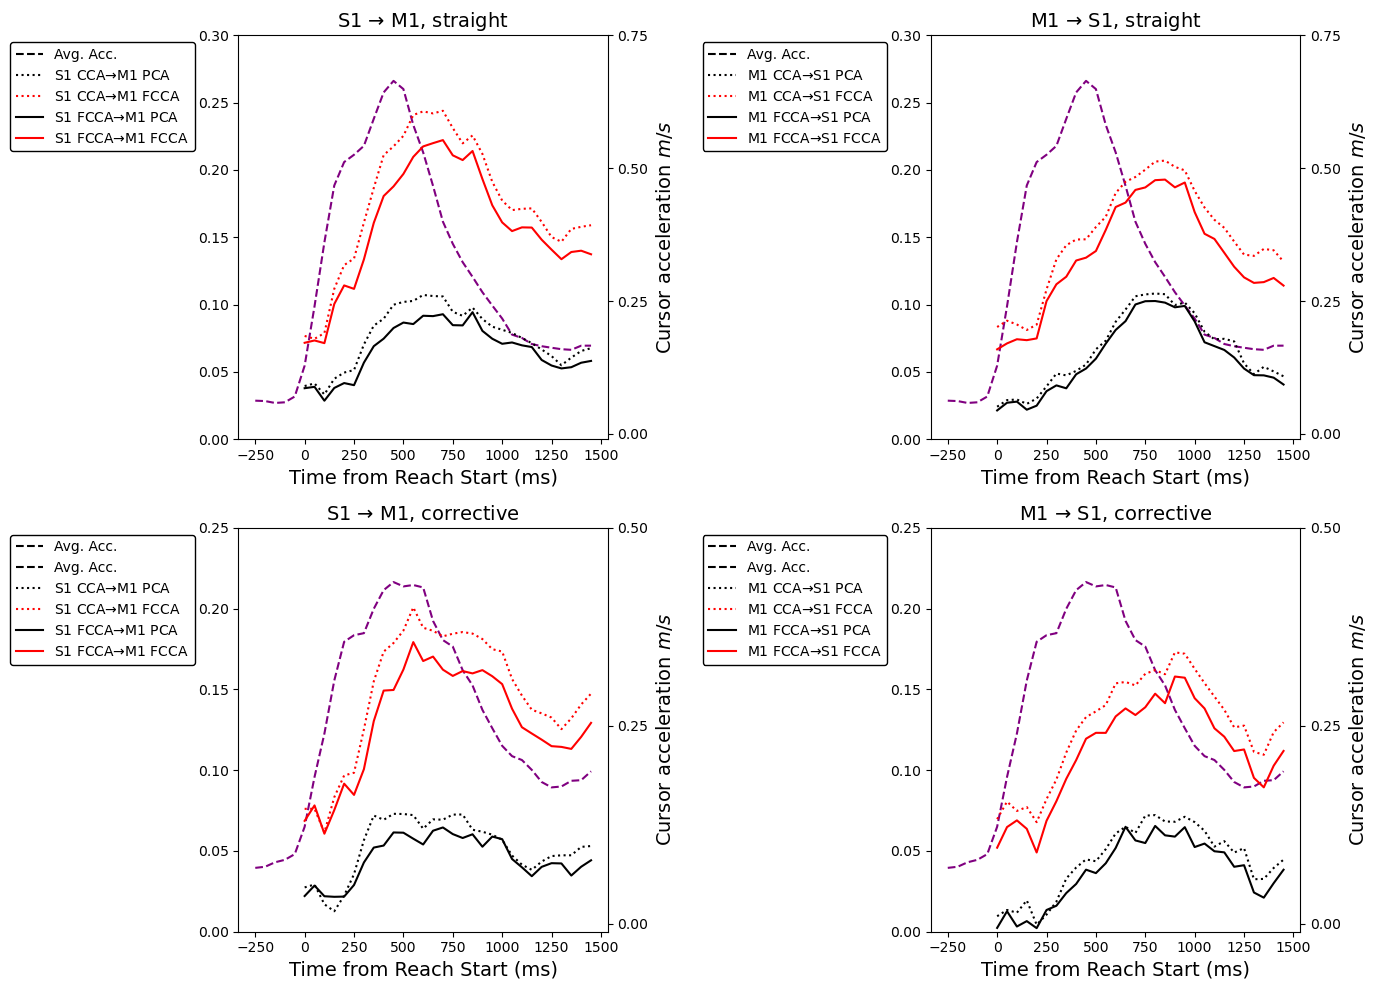

In [16]:
# Abridged version: Keep only across area traces..., remove CCA traces
#fig, ax = plt.subplots(1, 3, figsize=(12, 4))
fig, ax = plt.subplots(2, 2, figsize=(14, 10))

#windows = dvt_df.iloc[0]['window']
#window_centers = np.linspace(0, 35, 15)[0:9]

DIM = 4
ntr = np.array(ntr)
# Dense windows
window_centers = np.arange(30)
#df_ = apply_df_filters(dvt_df, error_thresh=1, error_op='le', filter_type=0, q=0, op='le', dim=DIM)
df_ = dvt_df

a = []
for i in range(2):
    for j in range(2):  
        a.append(ax[i, j].twinx())

# Filter transition times by those that survived all windows ()
d = apply_df_filters(df_, didx=7)
# error_filter = d.iloc[0]['error_filter']
# reach_filter = d.iloc[0]['reach_filter']
# window_filter = d.iloc[0]['window_filter']

for a_ in a:
    a_.set_ylabel('Cursor acceleration ' r'$m/s$', fontsize=14)

# Flatten
velall = np.array([elem for v in vel_all for elem in v])
ntr = np.array([len(v) for v in vel_all])
aall = [elem for ac in acc_all for elem in ac]
velall = np.array(velall)
accall = np.array(aall)
# Use fill between to plot the confidence bands
#a.fill_between(50 * np.arange(-5, 23), np.mean(acc_all, axis=0) - np.std(acc_all, axis=0), np.mean(acc_all, axis=0) + np.std(acc_all, axis=0), color='k', alpha=0.1)

for a_ in a[0:2]:
    a_.plot(50 * np.arange(-5, 30), np.mean(accall, axis=0), linestyle='--', color='purple')

# Dummy for legend
for i in range(2):
    for j in range(2):
        ax[i, j].plot(np.nan, linestyle='--', color='k', label='Avg. Acc.') 
#ax.plot(np.nan, linestyle='--', color='k', label='Avg. Vel.') 

# Segment in the same way as in the .py file to allow for comparison

rdict = {'rS1M1': {}, 'rM1S1': {}, 'rS1': {}, 'rM1': {}}
features = {'rS1M1': ['xcca', 'xpca', 'xfcca'], 'rM1S1': ['ycca', 'ypca', 'yfcca'], 'rS1': ['xcca', 'xpca', 'xfcca'], 'rM1': ['ycca', 'ypca', 'yfcca']}
targets = {'rS1M1': ['ycca', 'ypca', 'yfcca'], 'rM1S1': ['xcca', 'xpca', 'xfcca'], 'rS1': ['xcca', 'xpca', 'xfcca'], 'rM1': ['ycca', 'ypca', 'yfcca']}

legend_map = {'xcca':'S1 CCA', 'xpca': 'S1 PCA', 'xfcca': 'S1 FCCA', 'ycca': 'M1 CCA', 'ypca': 'M1 PCA', 'yfcca': 'M1 FCCA'}


# S1 -> M1
for k, v in features.items():
    for f in v:
        for t in targets[k]:
            rdict[k]['r2_%s_%s' % (f, t)] = []

for data_idx in np.unique(df_['didx'].values):
    d = apply_df_filters(df_, didx=data_idx)

    for ke in rdict.keys():
        r = {}
        for f in features[ke]:
            for t in targets[ke]:
                r['r2_%s_%s' % (f, t)] = []

        wc = []
        for k in range(d.shape[0]):
            win = d.iloc[k]['window']
            if win.ndim == 1:
                wc.extend([np.mean(win)])
            else:
                wc.extend(np.mean(win, axis=1))

            idx = 0
            for i, f in enumerate(features[ke]):
                for j, t in enumerate(targets[ke]):
                    if f == t:
                        continue
                    r['r2_%s_%s' % (f, t)].extend(np.nanmean(d.iloc[k]['_'.join(['r2', ke.split('r')[1]])][:, :, idx+1, 0, 0], axis=1))
                    idx += 2
                    
        win_order = np.argsort(wc)
        for k, v in r.items():
            f = k.split('_')[1]
            t = k.split('_')[2]
            if f == t:
                continue
            r[k] = np.array(v)[win_order]

        for f in features[ke]:
            for t in targets[ke]:
                rdict[ke]['r2_%s_%s' % (f, t)].append(r['r2_%s_%s' % (f, t)])

for k, v in features.items():
    for f in v:
        for t in targets[k]:
            rdict[k]['r2_%s_%s' % (f, t)] = np.array(rdict[k]['r2_%s_%s' % (f, t)]).T      


def plot_trace(r2, col, linestyle, label, axis):
    # axis.fill_between(50 * window_centers, np.array([np.sum(np.multiply(r, ntr))/np.sum(ntr) for r in r2]) - np.array([np.sqrt(np.var(r) * np.sum(ntr**2)/np.sum(ntr)**2) for r in r2]), 
    #                 np.array([np.sum(np.multiply(r, ntr))/np.sum(ntr) for r in r2]) + np.array([np.sqrt(np.var(r) * np.sum(ntr**2)/np.sum(ntr)**2) for r in r2]),
    #                 color=col, alpha=0.25, zorder=100)

    axis.plot(50 * window_centers, [np.sum(np.multiply(r, ntr))/np.sum(ntr) for r in r2], '-', color=col, label=label, linestyle=linestyle)

colors = ['k', 'r', 'k', 'r']
ls = [':', ':', '-', '-']

# Remove CCA traces
idx = 0
for i, (key, value) in enumerate(rdict['rS1M1'].items()):
    if 'ycca' in key or 'xpca' in key:
        continue

    label = legend_map[key.split('_')[1]] + r'$\to$' + legend_map[key.split('_')[2]]
    plot_trace(value, colors[idx], ls[idx], label, ax[0, 0])
    idx += 1

idx = 0
for i, (key, value) in enumerate(rdict['rM1S1'].items()):
    if 'xcca' in key or 'ypca' in key:
        continue

    label = legend_map[key.split('_')[1]] + r'$\to$' + legend_map[key.split('_')[2]]
    plot_trace(value, colors[idx], ls[idx], label, ax[0, 1])
    idx += 1


colors = ['k', 'r', 'k', 'r']
ls = [':', ':', '-', '-']

for a_ in a:
    a_.set_ylim([-0.01, 0.75])  
    a_.set_yticks([0., 0.25, 0.5, 0.75])
    a_.set_frame_on(True) # make sure there is any background

#ax.set_xlim([0, 950])
#ax.set_ylabel('Prediction ' + r'$r^2$', fontsize=14)
#ax.set_xlabel('Time from Reach Start (ms)', fontsize=14)
#ax.set_title('Projection Dimension %d' % DIM, fontsize=14)
for j in range(2):
    lg = ax[0, j].legend(fontsize=10, ncol=1, frameon=True,  edgecolor=(0, 0, 0, 1.), bbox_to_anchor=(-0.1, 1.0))
    lg.get_frame().set_alpha(1.)

    ax[0, j].set_zorder(1) # make it on top
    ax[0, j].set_frame_on(False) # make it transparent
    ax[0, j].set_xlabel('Time from Reach Start (ms)', fontsize=14)

    ax[0, j].set_ylim([0, 0.3])

ax[0, 0].set_title('S1 ' + r'$\to$' + ' M1, straight', fontsize=14)
ax[0, 1].set_title('M1 ' + r'$\to$' + ' S1, straight', fontsize=14)

# ax.vlines(50 * np.arange(-5, 25)[np.argmax(np.mean(accall, axis=0))], 0, 0.725, linestyles='dotted', color='#535454', alpha=0.75)

# Find the local peak time of the green trace
# trace = np.array([np.sum(np.multiply(r, ntr))/np.sum(ntr) for r in r2_S1toM1C])
# pk = scipy.signal.find_peaks(trace)

# ax.vlines(50 * np.arange(20)[pk[0][1]], 0, 0.725, linestyles='dashed', color='g', alpha=0.75)

# lg1 = ax[1].legend(loc='lower right', fontsize=10, bbox_to_anchor=(0.14, -0.015, 0.25, 0.25), frameon=True, edgecolor=(0, 0, 0, 1.), facecolor=(1, 1, 1, 1.))
# lg2 = ax[2].legend(loc='lower left', fontsize=10, frameon=True, edgecolor=(0, 0, 0, 1.), facecolor=(1, 1, 1, 1.))

####################################################### COrrective

# Filter transition times by those that survived all windows ()
d = apply_df_filters(df_, didx=7)
# error_filter = d.iloc[0]['error_filter']
# reach_filter = d.iloc[0]['reach_filter']
# window_filter = d.iloc[0]['window_filter']

for a_ in a[2:]:
    a_.set_ylabel('Cursor acceleration ' r'$m/s$', fontsize=14)

# Flatten
velall = np.array([elem for v in vel_allc for elem in v])
ntr = np.array([len(v) for v in vel_allc])
aall = [elem for ac in acc_allc for elem in ac]
velall = np.array(velall)
accall = np.array(aall)
# Use fill between to plot the confidence bands
#a.fill_between(50 * np.arange(-5, 23), np.mean(acc_all, axis=0) - np.std(acc_all, axis=0), np.mean(acc_all, axis=0) + np.std(acc_all, axis=0), color='k', alpha=0.1)

for a_ in a[2:]:
    a_.plot(50 * np.arange(-5, 30), np.mean(accall, axis=0), linestyle='--', color='purple')

# Dummy for legend
for i in range(2):
    for j in range(2):
        ax[i, j].plot(np.nan, linestyle='--', color='k', label='Avg. Acc.') 
#ax.plot(np.nan, linestyle='--', color='k', label='Avg. Vel.') 

# Segment in the same way as in the .py file to allow for comparison

rdict = {'rS1M1': {}, 'rM1S1': {}, 'rS1': {}, 'rM1': {}}
features = {'rS1M1': ['xcca', 'xpca', 'xfcca'], 'rM1S1': ['ycca', 'ypca', 'yfcca'], 'rS1': ['xcca', 'xpca', 'xfcca'], 'rM1': ['ycca', 'ypca', 'yfcca']}
targets = {'rS1M1': ['ycca', 'ypca', 'yfcca'], 'rM1S1': ['xcca', 'xpca', 'xfcca'], 'rS1': ['xcca', 'xpca', 'xfcca'], 'rM1': ['ycca', 'ypca', 'yfcca']}

legend_map = {'xcca':'S1 CCA', 'xpca': 'S1 PCA', 'xfcca': 'S1 FCCA', 'ycca': 'M1 CCA', 'ypca': 'M1 PCA', 'yfcca': 'M1 FCCA'}


# S1 -> M1
for k, v in features.items():
    for f in v:
        for t in targets[k]:
            rdict[k]['r2_%s_%s' % (f, t)] = []

for data_idx in np.unique(df_['didx'].values):
    d = apply_df_filters(df_, didx=data_idx)

    for ke in rdict.keys():
        r = {}
        for f in features[ke]:
            for t in targets[ke]:
                r['r2_%s_%s' % (f, t)] = []

        wc = []
        for k in range(d.shape[0]):
            win = d.iloc[k]['window']
            if win.ndim == 1:
                wc.extend([np.mean(win)])
            else:
                wc.extend(np.mean(win, axis=1))

            idx = 0
            for i, f in enumerate(features[ke]):
                for j, t in enumerate(targets[ke]):
                    if f == t:
                        continue
                    r['r2_%s_%s' % (f, t)].extend(np.nanmean(d.iloc[k]['_'.join(['r2', ke.split('r')[1]])][:, :, idx+1, 0, 1], axis=1))
                    idx += 2
                    
        win_order = np.argsort(wc)
        for k, v in r.items():
            f = k.split('_')[1]
            t = k.split('_')[2]
            if f == t:
                continue
            r[k] = np.array(v)[win_order]

        for f in features[ke]:
            for t in targets[ke]:
                rdict[ke]['r2_%s_%s' % (f, t)].append(r['r2_%s_%s' % (f, t)])

for k, v in features.items():
    for f in v:
        for t in targets[k]:
            rdict[k]['r2_%s_%s' % (f, t)] = np.array(rdict[k]['r2_%s_%s' % (f, t)]).T      


def plot_trace(r2, col, linestyle, label, axis):
    # axis.fill_between(50 * window_centers, np.array([np.sum(np.multiply(r, ntr))/np.sum(ntr) for r in r2]) - np.array([np.sqrt(np.var(r) * np.sum(ntr**2)/np.sum(ntr)**2) for r in r2]), 
    #                 np.array([np.sum(np.multiply(r, ntr))/np.sum(ntr) for r in r2]) + np.array([np.sqrt(np.var(r) * np.sum(ntr**2)/np.sum(ntr)**2) for r in r2]),
    #                 color=col, alpha=0.25, zorder=100)

    axis.plot(50 * window_centers, [np.sum(np.multiply(r, ntr))/np.sum(ntr) for r in r2], '-', color=col, label=label, linestyle=linestyle)

colors = ['k', 'r', 'k', 'r']
ls = [':', ':', '-', '-']

idx = 0
for i, (key, value) in enumerate(rdict['rS1M1'].items()):
    if 'ycca' in key or 'xpca' in key:
        continue

    label = legend_map[key.split('_')[1]] + r'$\to$' + legend_map[key.split('_')[2]]
    plot_trace(value, colors[idx], ls[idx], label, ax[1, 0])
    idx += 1

idx = 0
for i, (key, value) in enumerate(rdict['rM1S1'].items()):
    if 'xcca' in key or 'ypca' in key:
        continue

    label = legend_map[key.split('_')[1]] + r'$\to$' + legend_map[key.split('_')[2]]
    plot_trace(value, colors[idx], ls[idx], label, ax[1, 1])
    idx += 1

colors = ['g', 'g', 'k', 'k', 'r', 'r']# Flatten
velall = np.array([elem for v in vel_all for elem in v])
ntr = np.array([len(v) for v in vel_all])
aall = [elem for ac in acc_all for elem in ac]
velall = np.array(velall)

ls = ['--', ':', '-', ':', '-', '--']

# plot_trace(r2_M1CtoPCA, 'k', 'M1CC' + r'$\to$' + ' PCA')
# plot_trace(r2_M1CtoFCA, 'r', 'M1CC' + r'$\to$' + ' FCCA')
# plot_trace(r2_S1toM1C, 'g', 'S1CC' + r'$\to$' + ' M1CC')
#plot_trace(r2f - r2p, 'g', r'$\Delta$' + ' FCCA/PCA decoding')

for a_ in a[2:]:
    a_.set_ylim([-0.01, 0.5])  
    a_.set_yticks([0., 0.25, 0.5])
    a_.set_frame_on(True) # make sure there is any background

#ax.set_xlim([0, 950])
#ax.set_ylabel('Prediction ' + r'$r^2$', fontsize=14)
#ax.set_xlabel('Time from Reach Start (ms)', fontsize=14)
#ax.set_title('Projection Dimension %d' % DIM, fontsize=14)
for j in range(2):
    lg = ax[1, j].legend(fontsize=10, ncol=1, frameon=True,  edgecolor=(0, 0, 0, 1.), bbox_to_anchor=(-0.1, 1.0))
    lg.get_frame().set_alpha(1.)

    ax[1, j].set_zorder(1) # make it on top
    ax[1, j].set_frame_on(False) # make it transparent
    ax[1, j].set_xlabel('Time from Reach Start (ms)', fontsize=14)

    ax[1, j].set_ylim([0, 0.25])

ax[1, 0].set_title('S1 ' + r'$\to$' + ' M1, corrective', fontsize=14)
ax[1, 1].set_title('M1 ' + r'$\to$' + ' S1, corrective', fontsize=14)

fig.tight_layout()
fig.savefig('/home/akumar/nse/neural_control/figs/cca/decoding_vs_t_allpairwise_strcorr.pdf', bbox_inches='tight', pad_inches=0)